In [29]:
import csv 
import glob
import os

import astropy.units as u
from astropy.table import Table, Column
from astropy.io import ascii
from astropy.io.ascii import Csv
from astropy.io.votable.tree import Param,Info
from astropy.io.votable import from_table, writeto
from astropy.io import fits, votable
from astropy.wcs import WCS
from astropy.table import QTable
import matplotlib.pyplot as plt
import numpy as np
import numpy.core.records as rec

from spectral_cube import SpectralCube
import radio_beam
import aplpy
import astropy.units as u


from RadioAbsTools import cube_tools, spectrum_tools



# Extract many absorpton spectra from ASKAP SMC Data

This notebook produces spectra for each cutout subcube proved for SB 8906.

In [2]:
def output_spectra(velocity, opacity, flux, filename, 
                   sigma_tau):
    """
    Write the spectrum (velocity, flux and opacity) to a votable format file.

    :param spectrum: The spectrum to be output.
    :param opacity:  The opacity to be output.
    :param filename:  The filename to be created
    :param longitude: The galactic longitude of the target object
    :param latitude: The galactic latitude of the target object
    """
    table = Table(meta={'name': filename, 'id': 'opacity'})
    table.add_column(Column(name='velocity', data=velocity, unit='m/s'))
    table.add_column(Column(name='opacity', data=opacity))
    table.add_column(Column(name='flux', data=spectrum.flux, unit='Jy', description='Flux per beam'))
    table.add_column(Column(name='sigma_opacity', data=sigma_tau, description='Noise in the absorption profile'))

    votable = from_table(table)
    writeto(votable, filename)



In [3]:
def read_targets():
    ids=[]
    comp_names=[]
    ras=[]
    decs=[]
    beams=[]
    i=1
    with open('targets.csv', 'r') as csvfile:
        tgt_reader = csv.reader(csvfile, delimiter=',',
                                quotechar='"', quoting=csv.QUOTE_MINIMAL)
        for row in tgt_reader:
            if (tgt_reader.line_num == 1):
                # skip header
                continue

            #print (row)
            ids.append(i)
            comp_names.append(row[1])
            ras.append(float(row[2]))
            decs.append(float(row[3]))
            beams.append(row[4:])

            i+=1

            
    table = Table()
    table.add_column(Column(name='id', data=ids))
    table.add_column(Column(name='comp_name', data=comp_names))
    table.add_column(Column(name='ra', data=ras))
    table.add_column(Column(name='dec', data=decs))
    table.add_column(Column(name='beams', data=beams))

    return table



In [48]:
def plot_mom0(fname, comp_name, out_folder, src_ra, src_dec, src_maj, src_min, src_pa):
    cube = SpectralCube.read(fname)
    cube.beam_threshold = 0.1
    m0 = cube.moment0().to(u.Jy*u.km/(u.beam*u.s))
    m0.write('moment-0.fits', overwrite=True)

    fig = aplpy.FITSFigure('moment-0.fits')
    fig.show_grayscale()#pmax=100)
    fig.add_colorbar()
    fig.colorbar.set_axis_label_text('Brightness (Jy km / s / beam)')
    fig.add_beam()
    fig.set_theme('publication')

    # Plot ellipse for each source
    a_deg = src_maj*u.arcsec.to(u.deg)
    b_deg = src_min*u.arcsec.to(u.deg)
    fig.show_ellipses(src_ra, src_dec, a_deg, b_deg, angle=src_pa, edgecolor='red') #, 

    figname = '{}/{}_mom0.'.format(out_folder, comp_name)
    fig.savefig(figname+'.pdf')
    fig.savefig(figname+'.png')


### Identify the sources that we have cutouts for

In [77]:
folder = 'sb8906/cutouts/'
file_list = glob.glob(folder + 'J*_sl.fits')
file_list.sort()
len(file_list)

264

In [78]:
max_spectra=1000
#targets = ascii.read('targets.csv', format='csv', quotechar='"')
targets = read_targets()
targets

<Table length=354>
  id  ...                              beams                             
int64 ...                              object                            
----- ... ---------------------------------------------------------------
    1 ...                                           ['00A', '00B', '00C']
    2 ...               ['24A', '25A', '30A', '18B', '24B', '25B', '24C']
    3 ...        ['31A', '32A', '26B', '31B', '32B', '25C', '26C', '31C']
    4 ...                                                  ['03A', '02C']
    5 ...                                    ['35A', '35B', '34C', '35C']
    6 ...                                                         ['23C']
    7 ...                                    ['11A', '11B', '11C', '17C']
    8 ...                                    ['35A', '34B', '35B', '34C']
    9 ...                                    ['34A', '34B', '33C', '34C']
   10 ...               ['11A', '17A', '05B', '11B', '05C', '10C', '11C']
  ... ...                                                             ...
  345 ...                                                  ['00A', '00B']
  346 ...                                                  ['04A', '04C']
  347 ... ['20A', '26A', '27A', '20B', '26B', '27B', '19C', '20C', '26C']
  348 ...        ['19A', '25A', '26A', '19B', '20B', '18C', '19C', '25C']
  349 ...               ['18A', '19A', '12B', '13B', '18B', '12C', '18C']
  350 ...                                    ['11A', '11B', '05C', '11C']
  351 ...        ['08A', '14A', '15A', '08B', '14B', '07C', '08C', '14C']
  352 ...               ['34A', '28B', '29B', '34B', '28C', '33C', '34C']
  353 ...                                           ['32B', '33B', '32C']
  354 ...                      ['18A', '24A', '25A', '18B', '18C', '24C']

In [79]:
# Read and filter catalogue
src_votable = votable.parse('AS037_Continuum_Component_Catalogue_8906_100.votable', pedantic=False)
selavy_table = src_votable.get_first_table().to_table()
selavy_table

<Table masked=True length=3555>
  id   catalogue_id first_sbid ...  comment  quality_level released_date
                               ...                                      
int64     int64       int32    ... bytes1000    bytes15       bytes24   
------ ------------ ---------- ... --------- ------------- -------------
624901          100       8906 ...           NOT_VALIDATED              
624900          100       8906 ...           NOT_VALIDATED              
624899          100       8906 ...           NOT_VALIDATED              
624898          100       8906 ...           NOT_VALIDATED              
624897          100       8906 ...           NOT_VALIDATED              
624896          100       8906 ...           NOT_VALIDATED              
624895          100       8906 ...           NOT_VALIDATED              
624894          100       8906 ...           NOT_VALIDATED              
624893          100       8906 ...           NOT_VALIDATED              
   ...          ...        ... ...       ...           ...           ...
621356          100       8906 ...           NOT_VALIDATED              
621355          100       8906 ...           NOT_VALIDATED              
621354          100       8906 ...           NOT_VALIDATED              
621353          100       8906 ...           NOT_VALIDATED              
621352          100       8906 ...           NOT_VALIDATED              
621351          100       8906 ...           NOT_VALIDATED              
621350          100       8906 ...           NOT_VALIDATED              
621349          100       8906 ...           NOT_VALIDATED              
621348          100       8906 ...           NOT_VALIDATED              
621347          100       8906 ...           NOT_VALIDATED

### For each cutout:
1. Get source params from Selavy catalogue
2. Produce moment map
3. Produce plot of moment map with source highlighted
4. Extract spectrum for source
5. Classify spectrum
6. Save to votable file

In [80]:
def get_source(file_list, target):
    
    fname = '{}{}_sl.fits'.format(folder, tgt['comp_name'])
    if not fname in file_list:
        return None
    
    comp_cat_row= selavy_table[selavy_table['component_name']==target['comp_name']][0]
    src = {'ra':comp_cat_row['ra_deg_cont'], 'dec':comp_cat_row['dec_deg_cont'], 
           'a':comp_cat_row['maj_axis'], 'b':comp_cat_row['min_axis'], 'pa': comp_cat_row['pos_ang'],
          'comp_name': target['comp_name'], 'fname': fname, 'flux_peak': comp_cat_row['flux_peak']}
    return src
    

In [81]:
def save_spectrum(velocity, opacity, flux, filename, 
                   sigma_tau):
    """
    Write the spectrum (velocity, flux and opacity) to a votable format file.

    :param spectrum: The spectrum to be output.
    :param opacity:  The opacity to be output.
    :param filename:  The filename to be created
    :param longitude: The galactic longitude of the target object
    :param latitude: The galactic latitude of the target object
    """
    table = Table(meta={'name': filename, 'id': 'opacity'})
    table.add_column(Column(name='velocity', data=velocity, unit='m/s'))
    table.add_column(Column(name='opacity', data=opacity))
    table.add_column(Column(name='flux', data=flux, unit='Jy', description='Flux per beam'))
    table.add_column(Column(name='sigma_opacity', data=sigma_tau, description='Noise in the absorption profile'))

    votable = from_table(table)
    writeto(votable, filename)




In [82]:
def extract_spectrum(fname, src, continuum_start_vel, continuum_end_vel, num_edge_chan=10):

    hdulist = fits.open(fname)
    image = hdulist[0].data
    header = hdulist[0].header
    w = WCS(header)
    index = np.arange(header['NAXIS3'])
    velocities = w.wcs_pix2world(10,10,index[:],0,0)[2]

    img_slice = cube_tools.get_integrated_spectrum(image, w, src, velocities, continuum_start_vel, continuum_end_vel, radius=6)

    l_edge, r_edge = cube_tools.find_edges(img_slice, num_edge_chan)

    spectrum_array = rec.fromarrays(
        [np.arange(img_slice.size)[l_edge:r_edge],
         velocities[l_edge:r_edge],
         img_slice[l_edge:r_edge]],
        names='plane,velocity,flux')

    del image
    del header
    hdulist.close()

    return spectrum_array

def output_spectrum(spec_folder, src, spectrum_array, opacity, sigma_opacity):
    filename = '{}/{}_spec'.format(spec_folder, src['comp_name'])

    save_spectra(spectrum_array.velocity, opacity, spectrum_array.flux, filename+'.vot', sigma_opacity)
    spectrum_tools.plot_absorption_spectrum(spectrum_array.velocity, opacity, filename+'.png', tgt['comp_name'], continuum_start_vel, continuum_end_vel, sigma_opacity, range=None)
    spectrum_tools.plot_absorption_spectrum(spectrum_array.velocity, opacity, filename+'_zoom.png', tgt['comp_name'], continuum_start_vel, continuum_end_vel, sigma_opacity, range=(75,275))




Processing 354 cutouts into spectra

Extracting spectrum for src #1 J001932-710022


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


INFO: Auto-setting vmin to -1.255e+01 [aplpy.core]
INFO: Auto-setting vmax to  6.354e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494


Skipping missing src #2 J005813-700958
Skipping missing src #3 J011134-711413

Extracting spectrum for src #4 J002248-734007


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


INFO: Auto-setting vmin to -1.447e+00 [aplpy.core]
INFO: Auto-setting vmax to  7.041e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


Skipping missing src #5 J014114-740731

Extracting spectrum for src #6 J012430-752241


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


INFO: Auto-setting vmin to -3.481e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.131e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


Skipping missing src #7 J010218-754651

Extracting spectrum for src #8 J013742-733049


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


INFO: Auto-setting vmin to -1.356e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.156e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


Skipping missing src #9 J013329-730304
Skipping missing src #10 J005221-752539

Extracting spectrum for src #11 J005223-752547


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


INFO: Auto-setting vmin to -2.966e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.406e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


Skipping missing src #12 J011615-733851
Skipping missing src #13 J011610-733900
Skipping missing src #14 J003511-710955

Extracting spectrum for src #15 J003158-703514


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


INFO: Auto-setting vmin to -1.793e+00 [aplpy.core]
INFO: Auto-setting vmax to  7.443e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494



Extracting spectrum for src #16 J011131-754505


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


INFO: Auto-setting vmin to -1.215e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.965e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


Skipping missing src #17 J002256-723307

Extracting spectrum for src #18 J002826-703500


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


INFO: Auto-setting vmin to -1.593e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.454e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494



Extracting spectrum for src #19 J012408-730903


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


INFO: Auto-setting vmin to -1.593e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.628e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494



Extracting spectrum for src #20 J002034-705526


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


INFO: Auto-setting vmin to -1.411e+01 [aplpy.core]
INFO: Auto-setting vmax to  7.258e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494



Extracting spectrum for src #21 J012639-731501


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


INFO: Auto-setting vmin to -1.868e+00 [aplpy.core]
INFO: Auto-setting vmax to  9.992e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494



Extracting spectrum for src #22 J011136-753800


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


INFO: Auto-setting vmin to -2.345e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.934e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494



Extracting spectrum for src #23 J011134-753809


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


INFO: Auto-setting vmin to -2.050e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.898e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494



Extracting spectrum for src #24 J012207-702918


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


INFO: Auto-setting vmin to -1.170e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.875e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494



Extracting spectrum for src #25 J001807-714226


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


INFO: Auto-setting vmin to -1.615e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.421e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494


Skipping missing src #26 J004125-705743

Extracting spectrum for src #27 J013704-730412


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


INFO: Auto-setting vmin to -1.901e+00 [aplpy.core]
INFO: Auto-setting vmax to  9.849e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494



Extracting spectrum for src #28 J013701-730415


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


INFO: Auto-setting vmin to -1.817e+00 [aplpy.core]
INFO: Auto-setting vmax to  9.884e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


Skipping missing src #29 J005337-723143
Skipping missing src #30 J005422-702352
Skipping missing src #31 J005652-712300

Extracting spectrum for src #32 J011025-695503


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


INFO: Auto-setting vmin to -2.970e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.591e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494



Extracting spectrum for src #33 J001436-705332


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


INFO: Auto-setting vmin to -4.973e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.322e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494


Skipping missing src #34 J002841-704515
Skipping missing src #35 J011051-731424
Skipping missing src #36 J011056-731403
Skipping missing src #37 J011049-731425

Extracting spectrum for src #38 J011056-731409


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


INFO: Auto-setting vmin to -1.453e+01 [aplpy.core]
INFO: Auto-setting vmax to  5.839e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #39 J011049-731428

Extracting spectrum for src #40 J011357-702530


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.573e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.332e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #41 J003136-703312


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.300e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.170e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #42 J002648-704041


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.248e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.214e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #43 J004937-700132


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.288e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.146e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #44 J003947-713734
Skipping missing src #45 J003939-714145
Skipping missing src #46 J003939-714141
Skipping missing src #47 J005608-703845

Extracting spectrum for src #48 J012250-715042


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.367e+00 [aplpy.core]
INFO: Auto-setting vmax to  7.438e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #49 J012348-735032


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.593e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.223e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #50 J012350-735041


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.599e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.223e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #51 J001738-705317


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -3.138e+00 [aplpy.core]
INFO: Auto-setting vmax to  9.794e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #52 J004228-700256


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.686e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.063e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #53 J004224-700245


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.675e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.063e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #54 J003252-722933
Skipping missing src #55 J004956-723553

Extracting spectrum for src #56 J011321-752819


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.346e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.273e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #57 J002907-735348


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.433e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.282e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #58 J010131-693918


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -3.409e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.706e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #59 J010132-693913


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -3.343e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.705e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #60 J005537-743925

Extracting spectrum for src #61 J001214-711245


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -4.021e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.697e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #62 J010238-762314


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.170e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.268e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #63 J005557-722604
Skipping missing src #64 J005238-731244

Extracting spectrum for src #65 J012257-751506


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.632e+01 [aplpy.core]
INFO: Auto-setting vmax to  8.561e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #66 J001720-730552


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.670e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.356e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #67 J002223-742826


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -6.488e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.037e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #68 J005406-753404


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -4.543e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.263e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #69 J005406-753402


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -4.333e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.260e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #70 J010931-713454
Skipping missing src #71 J003801-725210
Skipping missing src #72 J003754-725156

Extracting spectrum for src #73 J005715-704045


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.830e+00 [aplpy.core]
INFO: Auto-setting vmax to  9.468e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #74 J003405-702551


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.904e+00 [aplpy.core]
INFO: Auto-setting vmax to  7.349e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #75 J003410-702518


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -3.286e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.062e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #76 J003401-702626


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.364e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.028e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #77 J004647-695714


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.929e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.641e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #78 J004644-695710


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.594e+00 [aplpy.core]
INFO: Auto-setting vmax to  9.252e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #79 J004639-695711


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.752e+00 [aplpy.core]
INFO: Auto-setting vmax to  9.559e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #80 J003140-743447


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.443e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.216e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #81 J004226-730420

Extracting spectrum for src #82 J004226-730417


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.214e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.137e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #83 J010251-753523


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.754e+00 [aplpy.core]
INFO: Auto-setting vmax to  9.661e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #84 J005732-741243

Extracting spectrum for src #85 J011132-730209


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.951e+00 [aplpy.core]
INFO: Auto-setting vmax to  9.386e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #86 J011629-731438

Extracting spectrum for src #87 J002336-735531


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -5.907e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.688e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #88 J002336-735526


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -5.518e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.685e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #89 J005448-725352

Extracting spectrum for src #90 J010533-721330


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -5.427e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.374e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #91 J005013-755230


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -9.757e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.256e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #92 J011108-692612


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -5.136e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.295e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #93 J011414-700944


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -7.171e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.255e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #94 J012322-703740


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -5.802e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.068e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #95 J005530-702626


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -9.303e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.085e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #96 J012758-720535


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -5.262e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.240e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #97 J010344-694051


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -7.054e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.614e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #98 J005015-730325
Skipping missing src #99 J011635-712603

Extracting spectrum for src #100 J005611-710707


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.722e+01 [aplpy.core]
INFO: Auto-setting vmax to  9.170e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #101 J002919-722810

Extracting spectrum for src #102 J010811-754156


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -6.725e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.139e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #103 J010901-731815


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -8.186e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.533e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #104 J003836-695321


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -5.850e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.734e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #105 J005115-713057

Extracting spectrum for src #106 J003850-731053


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -5.369e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.457e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #107 J010234-695827


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -6.715e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.670e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #108 J014810-744345


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.665e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.876e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 5 to 44 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #109 J013453-722444


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.666e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.331e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #110 J004047-714600

Extracting spectrum for src #111 J003917-694842


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.512e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.098e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #112 J012924-733152


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.720e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.664e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #113 J005534-721055


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.151e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.599e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #114 J005540-721048


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.560e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.615e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #115 J004519-695517


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -7.387e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.042e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #116 J005703-721635


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -4.757e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.656e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #117 J010815-692354


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.113e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.543e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #118 J010536-740005


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -6.260e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.391e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #119 J010029-713825


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -3.676e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.879e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #120 J013147-734941

Extracting spectrum for src #121 J013913-750040


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -9.708e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.822e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 5 to 44 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #122 J004934-721900


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -8.064e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.777e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #123 J003945-695848


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -7.730e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.154e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #124 J012059-753818


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.140e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.582e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #125 J001157-705801


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.408e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.337e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #126 J002238-742715


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.118e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.727e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #127 J004555-704645


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -7.932e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.930e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #128 J004704-714956

Extracting spectrum for src #129 J002121-710822


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -3.938e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.040e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #130 J004808-741205

Extracting spectrum for src #131 J011146-703529


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -5.018e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.416e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #132 J010748-705214


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -5.848e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.197e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #133 J002638-725000

Extracting spectrum for src #134 J002410-735713


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -4.451e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.112e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #135 J002412-735717


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -4.557e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.108e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #136 J014918-740112


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -3.966e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.378e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 5 to 44 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #137 J002143-741500


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.437e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.046e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #138 J005518-714449


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -5.363e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.636e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #139 J002621-743740


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.325e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.836e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #140 J001334-715727


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -6.895e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.485e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #141 J005848-743513

Extracting spectrum for src #142 J013238-722138


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -8.364e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.852e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #143 J012235-733812


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -7.315e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.047e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #144 J010344-695829

Extracting spectrum for src #145 J003809-735023


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -4.406e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.341e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #146 J005731-744213

Extracting spectrum for src #147 J002443-745600


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.160e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.536e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #148 J005948-705028


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -7.860e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.321e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #149 J010839-724715


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -6.864e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.062e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #150 J013032-731740


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -6.490e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.504e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #151 J003224-730658

Extracting spectrum for src #152 J001858-734224


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.128e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.256e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #153 J011157-734128

Extracting spectrum for src #154 J011610-742813


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -6.807e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.159e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #155 J010708-714305
Skipping missing src #156 J011432-732142

Extracting spectrum for src #157 J011616-732652


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.209e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.664e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #158 J004028-703512


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.259e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.203e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #159 J004725-712727

Extracting spectrum for src #160 J002448-705544


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -4.747e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.394e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #161 J002447-715909

Extracting spectrum for src #162 J004045-702356


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -7.552e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.869e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #163 J005453-713136

Extracting spectrum for src #164 J004048-733701


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.539e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.194e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #165 J011615-732700


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.135e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.657e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #166 J012330-721814

Extracting spectrum for src #167 J012433-712644


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -7.456e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.577e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #168 J014358-743131


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.213e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.964e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 5 to 44 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #169 J003624-725342


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -8.563e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.691e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #170 J010523-753420


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.592e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.493e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #171 J012209-713953


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -7.386e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.358e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #172 J005305-692240


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -6.246e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.255e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #173 J013013-742023


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -6.467e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.309e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #174 J011405-732006


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.651e+00 [aplpy.core]
INFO: Auto-setting vmax to  7.169e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #175 J011408-732005


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.782e+00 [aplpy.core]
INFO: Auto-setting vmax to  7.191e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #176 J011403-732006


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.857e+00 [aplpy.core]
INFO: Auto-setting vmax to  7.202e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #177 J012816-751258


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -4.900e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.770e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 5 to 44 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #178 J012809-751250


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -5.694e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.473e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 5 to 44 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #179 J003936-742017

Extracting spectrum for src #180 J010511-753444


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -9.666e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.562e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #181 J010404-720144


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -3.039e+00 [aplpy.core]
INFO: Auto-setting vmax to  9.336e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #182 J010401-720206


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -3.290e+00 [aplpy.core]
INFO: Auto-setting vmax to  9.365e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #183 J010400-720142


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -3.439e+00 [aplpy.core]
INFO: Auto-setting vmax to  9.378e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #184 J003716-751410


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -6.483e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.504e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #185 J010044-695316


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -8.299e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.220e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #186 J004918-700753


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -9.001e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.616e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #187 J012036-750633


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -8.889e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.382e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #188 J011436-715235


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.272e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.950e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #189 J011435-715258


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.190e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.949e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #190 J011603-744325
Skipping missing src #191 J005217-730156

Extracting spectrum for src #192 J011805-745824


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -8.995e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.347e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #193 J004453-704843


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -7.561e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.715e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #194 J005433-700111


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.056e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.874e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #195 J001447-705322


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -5.988e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.569e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #196 J010046-745418


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.178e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.111e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #197 J004443-700906


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -6.595e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.320e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #198 J010557-714603

Extracting spectrum for src #199 J011248-701929


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -7.612e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.906e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #200 J004239-700132


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.853e+00 [aplpy.core]
INFO: Auto-setting vmax to  9.133e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #201 J005141-725544
Skipping missing src #202 J005141-725602

Extracting spectrum for src #203 J005516-753204


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -7.847e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.228e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #204 J004306-732827


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -6.130e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.942e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #205 J012353-744145

Extracting spectrum for src #206 J001858-732448


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -5.945e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.488e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #207 J011005-722648


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -3.737e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.048e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #208 J014249-735836


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -9.332e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.476e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 5 to 44 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #209 J003749-735127


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.100e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.551e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #210 J012023-721955


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -6.934e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.445e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #211 J002956-714637


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.043e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.823e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #212 J004331-721024


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -9.020e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.640e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #213 J004318-714058


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.073e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.948e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #214 J003208-735038


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -9.545e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.432e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #215 J010957-754638


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -8.498e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.253e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #216 J005658-752914


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.091e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.726e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #217 J002724-703156


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -7.958e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.177e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #218 J011600-710440


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -7.756e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.617e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #219 J002141-704452


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.106e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.584e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #220 J010441-713121

Extracting spectrum for src #221 J003120-703648


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -3.757e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.052e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #222 J003131-743031


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.073e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.312e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #223 J004213-695220


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.362e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.027e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #224 J012056-733453


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -9.736e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.681e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #225 J005234-702816

Extracting spectrum for src #226 J002350-731703


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -9.320e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.390e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #227 J003524-732222


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -8.637e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.667e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #228 J010919-725600

Extracting spectrum for src #229 J005137-754807


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.410e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.304e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #230 J011357-711424


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -9.334e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.749e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #231 J004459-711438

Extracting spectrum for src #232 J005622-715110


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -6.090e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.171e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #233 J002100-711921


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -8.235e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.351e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #234 J002628-740019


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.144e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.380e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #235 J001239-713138


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -4.130e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.969e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #236 J010437-695831


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.281e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.608e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #237 J010436-695817


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.167e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.612e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #238 J002645-710007


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.107e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.097e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #239 J005636-740315

Extracting spectrum for src #240 J011332-740757


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -7.753e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.224e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #241 J004719-723946


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -8.615e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.184e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #242 J004805-760114


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.162e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.532e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #243 J012930-733310


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -4.995e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.901e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #244 J013309-742916


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.001e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.445e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 5 to 44 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #245 J002440-734541


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -9.199e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.028e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #246 J003352-703052


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.585e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.551e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #247 J005117-734000


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.169e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.993e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #248 J004205-730717


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.071e+00 [aplpy.core]
INFO: Auto-setting vmax to  7.692e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #249 J004201-730726


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.362e+00 [aplpy.core]
INFO: Auto-setting vmax to  7.717e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #250 J003944-705248


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.164e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.186e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #251 J003315-705603


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.528e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.873e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #252 J003025-731810

Extracting spectrum for src #253 J013218-715347


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -8.110e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.625e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #254 J013920-731654


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.076e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.876e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #255 J003424-721147


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -5.612e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.785e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #256 J003424-721143


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -5.329e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.791e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #257 J005436-755245


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.069e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.242e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #258 J004537-712316

Extracting spectrum for src #259 J002823-724311


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -9.604e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.553e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #260 J010621-704144


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -7.113e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.472e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #261 J003311-703125


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.378e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.202e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #262 J004954-715150
Skipping missing src #263 J010525-722523
Skipping missing src #264 J010255-713631

Extracting spectrum for src #265 J004338-720343


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.323e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.410e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #266 J005539-694022


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.272e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.286e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #267 J011816-695147


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.257e+01 [aplpy.core]
INFO: Auto-setting vmax to  6.250e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #268 J005218-722707


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -4.856e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.556e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #269 J004421-744316


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -7.704e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.490e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #270 J011454-701434


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.271e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.002e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #271 J002207-740941


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.121e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.391e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #272 J011116-701147


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -9.241e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.086e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #273 J004328-704141


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.361e+01 [aplpy.core]
INFO: Auto-setting vmax to  5.622e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #274 J004330-704148


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.486e+01 [aplpy.core]
INFO: Auto-setting vmax to  5.616e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #275 J004327-704135


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.464e+01 [aplpy.core]
INFO: Auto-setting vmax to  5.627e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #276 J013243-734413


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.426e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.795e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #277 J013632-740658


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.115e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.689e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 5 to 44 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #278 J002246-710655


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.268e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.616e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #279 J011919-710522


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.320e+00 [aplpy.core]
INFO: Auto-setting vmax to  9.542e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #280 J011917-710537


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.231e+00 [aplpy.core]
INFO: Auto-setting vmax to  9.512e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #281 J004632-705855


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.330e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.444e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #282 J010333-750657


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.881e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.052e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #283 J010330-750707


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.926e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.057e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #284 J004222-754838


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.181e+01 [aplpy.core]
INFO: Auto-setting vmax to  6.223e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #285 J005423-725257

Extracting spectrum for src #286 J012036-703855


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.581e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.806e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #287 J012038-703839


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.468e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.752e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #288 J003255-714539


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.629e+00 [aplpy.core]
INFO: Auto-setting vmax to  7.451e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #289 J003254-714551


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.692e+00 [aplpy.core]
INFO: Auto-setting vmax to  7.498e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #290 J005056-700921


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.413e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.741e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #291 J003249-741858
Skipping missing src #292 J005523-721055

Extracting spectrum for src #293 J010346-694923


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.226e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.723e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #294 J005642-725215
Skipping missing src #295 J005645-725200

Extracting spectrum for src #296 J001113-705251


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.366e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.630e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #297 J002011-710256


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.888e+00 [aplpy.core]
INFO: Auto-setting vmax to  7.441e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #298 J003824-742211

Extracting spectrum for src #299 J001926-705235


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.903e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.032e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #300 J005738-710847

Extracting spectrum for src #301 J002657-741032


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.135e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.567e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #302 J013328-743632


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -9.798e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.663e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 5 to 44 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #303 J001451-705003


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.656e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.001e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #304 J013229-734122


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.250e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.613e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #305 J002823-703419


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.472e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.620e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #306 J010913-731138
Skipping missing src #307 J005906-735204

Extracting spectrum for src #308 J013229-723958


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -5.709e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.308e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #309 J004858-752943


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.103e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.977e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #310 J005041-703937


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -9.978e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.173e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #311 J004937-705211


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -9.893e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.563e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #312 J011351-753338


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.044e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.117e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #313 J013214-733902


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.124e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.035e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #314 J010940-695555


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.813e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.698e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #315 J010941-695624


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.016e+00 [aplpy.core]
INFO: Auto-setting vmax to  7.520e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #316 J010331-700636


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.338e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.721e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #317 J014249-743444


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.213e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.577e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 5 to 44 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #318 J013800-741350


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.486e+00 [aplpy.core]
INFO: Auto-setting vmax to  7.711e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 5 to 44 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #319 J003413-733324


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -3.755e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.755e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #320 J004918-745700


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.976e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.042e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #321 J004602-744004


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.488e+00 [aplpy.core]
INFO: Auto-setting vmax to  7.673e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #322 J010458-703734


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.424e+00 [aplpy.core]
INFO: Auto-setting vmax to  7.461e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #323 J005905-704906


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.285e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.665e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #324 J005903-704854


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -2.024e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.644e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #325 J012655-751121


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.693e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.828e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 5 to 44 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #326 J004741-753011


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -7.993e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.499e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #327 J011332-693855


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.881e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.738e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #328 J011044-722848
Skipping missing src #329 J011035-722807

Extracting spectrum for src #330 J003106-710110


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.804e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.546e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #331 J011622-702955


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.100e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.536e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #332 J011623-703000


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.228e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.519e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #333 J003030-742926


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.973e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.057e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #334 J003037-742901


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.930e+00 [aplpy.core]
INFO: Auto-setting vmax to  7.397e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #335 J011551-700418


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.747e+00 [aplpy.core]
INFO: Auto-setting vmax to  7.679e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #336 J003242-733152


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.619e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.324e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #337 J001827-711353


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.425e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.557e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #338 J012547-731600


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.470e+00 [aplpy.core]
INFO: Auto-setting vmax to  7.472e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #339 J011321-752550


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.118e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.109e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #340 J012323-735606
Skipping missing src #341 J003743-710736

Extracting spectrum for src #342 J011223-741211


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -9.844e-01 [aplpy.core]
INFO: Auto-setting vmax to  5.051e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #343 J003107-710657


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.178e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.336e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 1 to 40 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #344 J010557-710456

Extracting spectrum for src #345 J001748-704446


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -7.588e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.763e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 0 to 39 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #346 J002645-744137


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.167e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.277e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #347 J010431-720725
Skipping missing src #348 J005820-713039
Skipping missing src #349 J004750-705756

Extracting spectrum for src #350 J005019-755630


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.249e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.773e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


Skipping missing src #351 J004413-724301

Extracting spectrum for src #352 J012629-732714


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.364e+00 [aplpy.core]
INFO: Auto-setting vmax to  7.195e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 4 to 43 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #353 J012733-713638


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.008e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.514e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 3 to 42 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))



Extracting spectrum for src #354 J005356-703803


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/aplpy/core.py:249: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(**kwargs)


INFO: Auto-setting vmin to -1.743e+00 [aplpy.core]
INFO: Auto-setting vmax to  9.019e+00 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]
Using bins 2 to 41 (velocity range -100000 to -60000) out of 494


/Users/jamesdempsey/projects/radioabstools/RadioAbsTools/spectrum_tools.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = figure if figure else plt.figure(figsize=(8, 4.8))


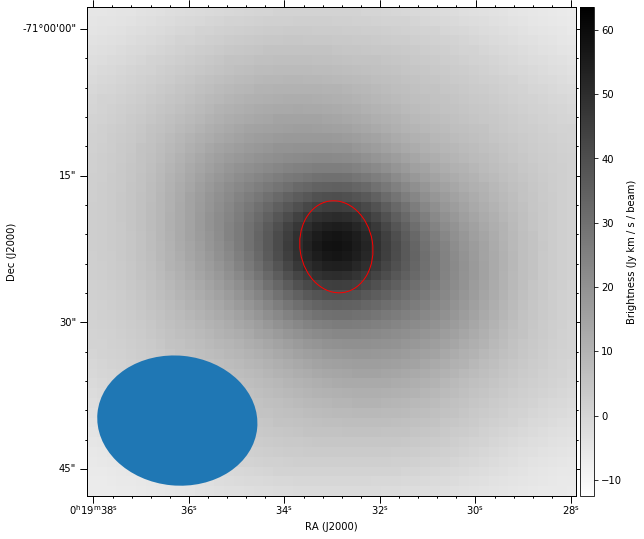

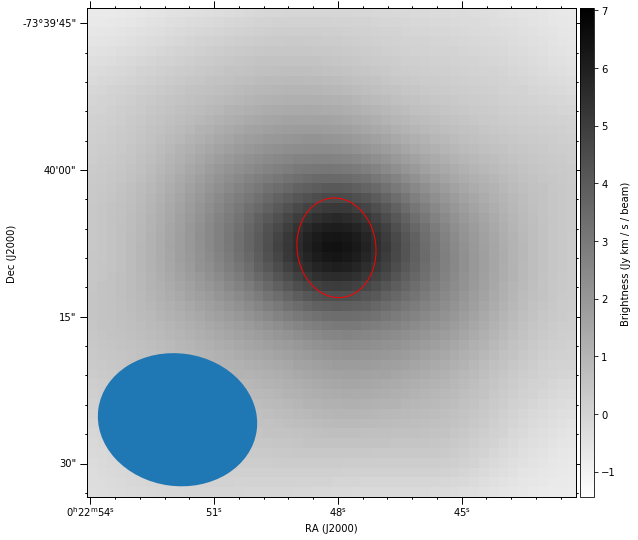

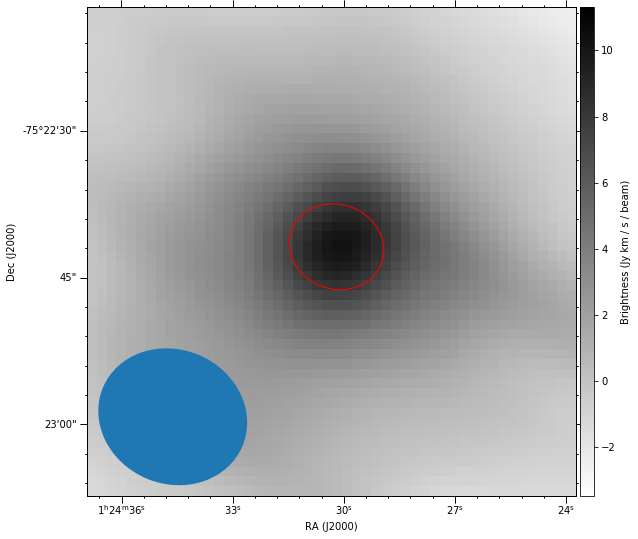

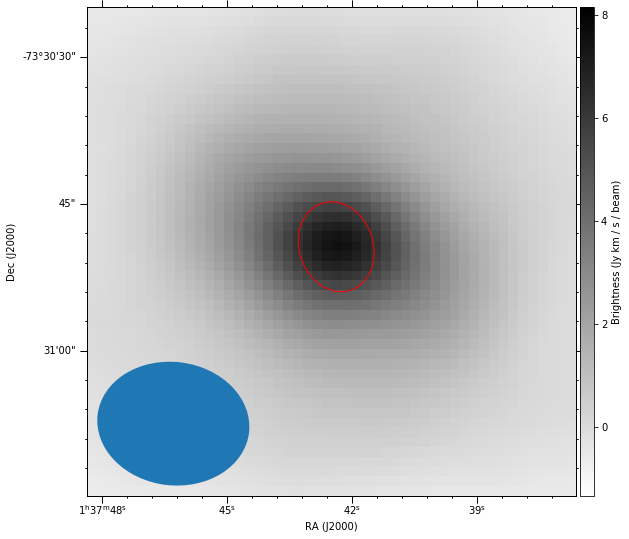

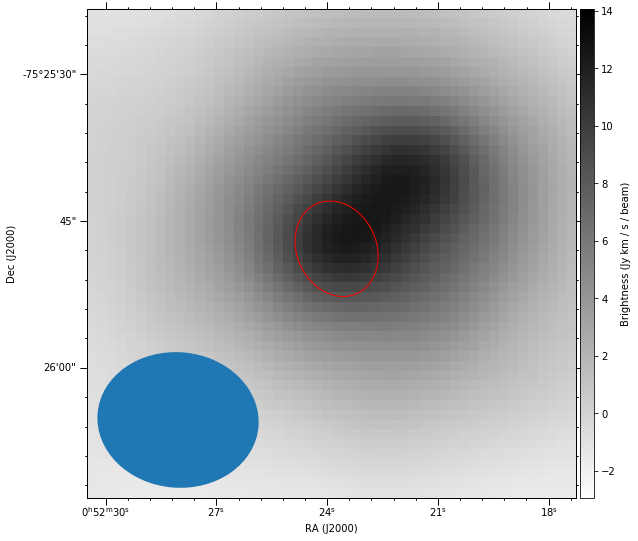

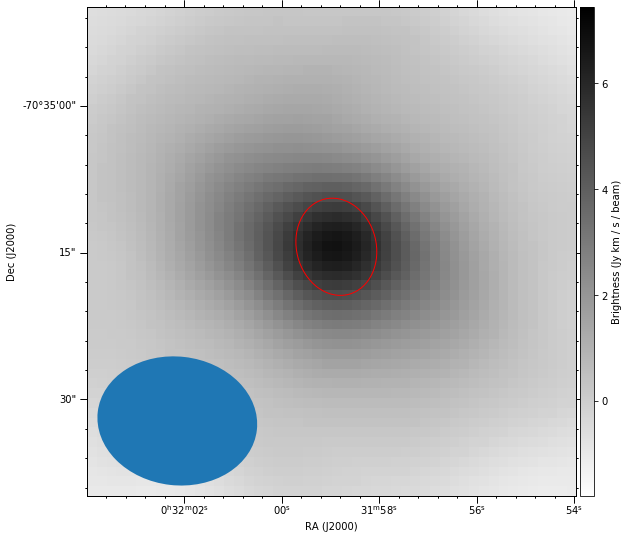

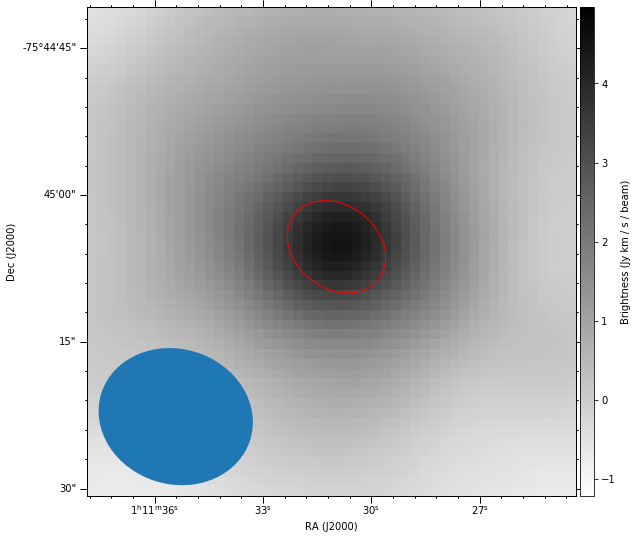

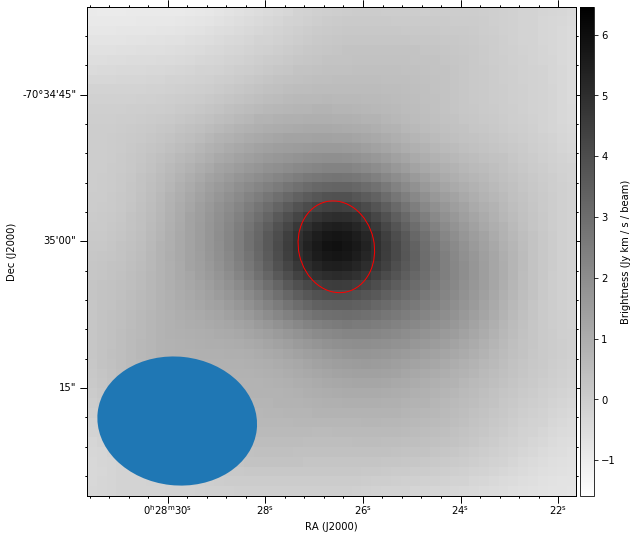

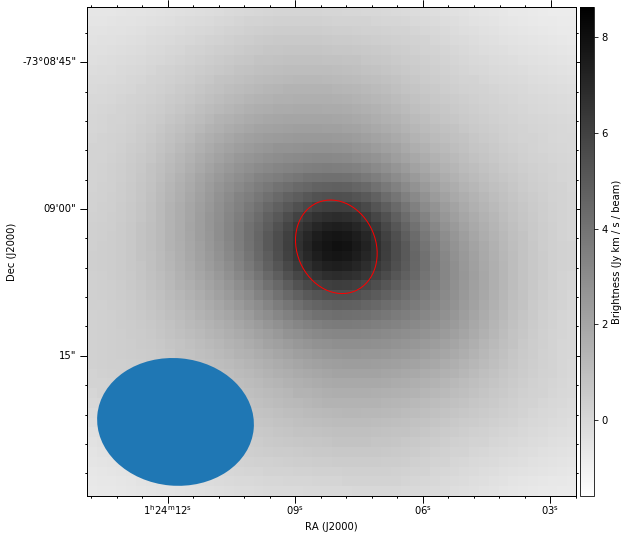

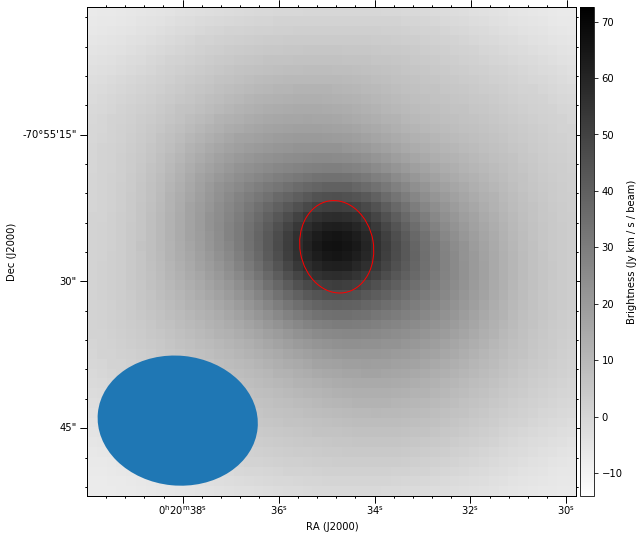

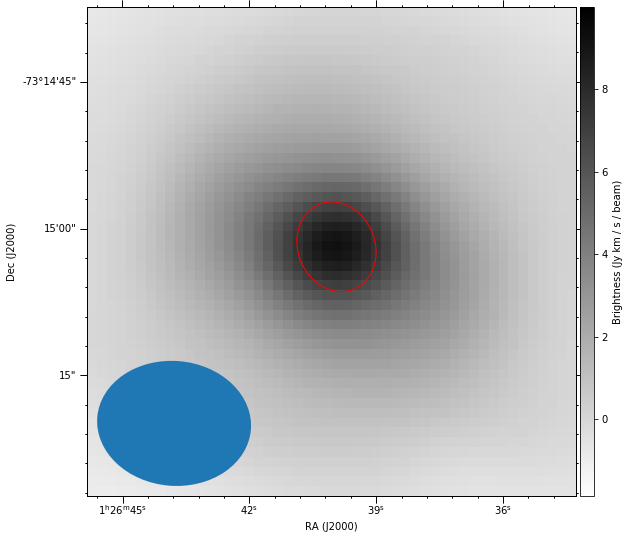

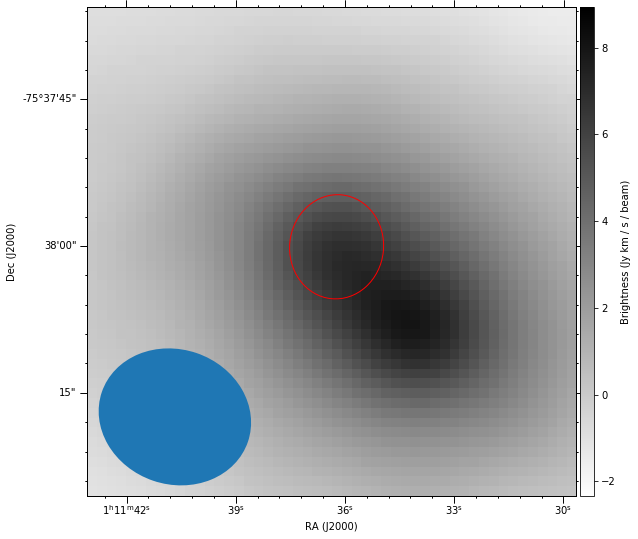

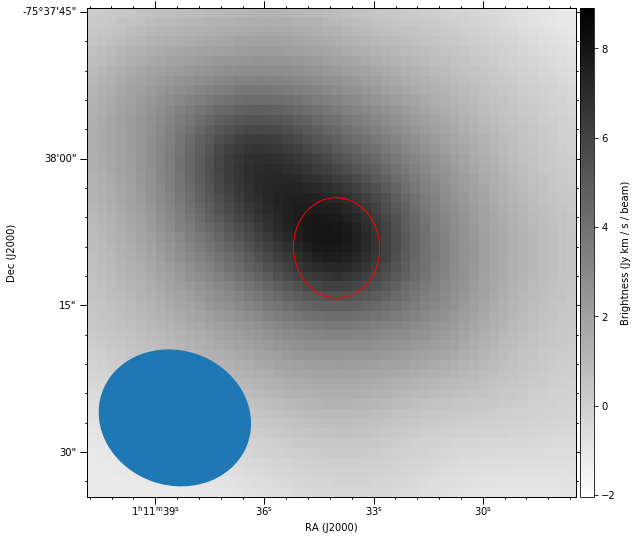

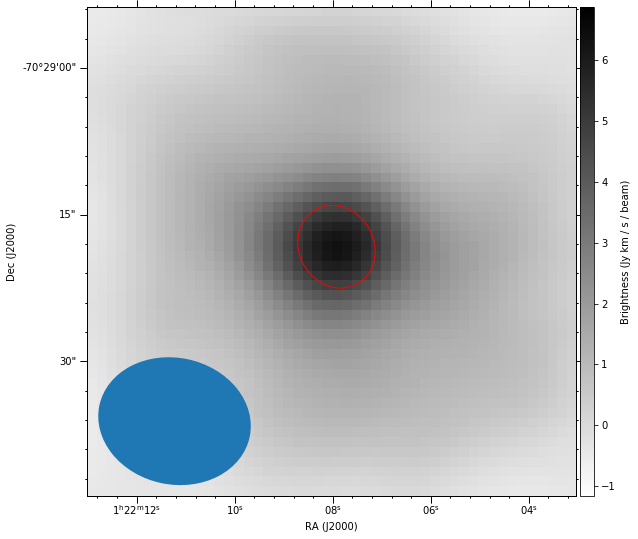

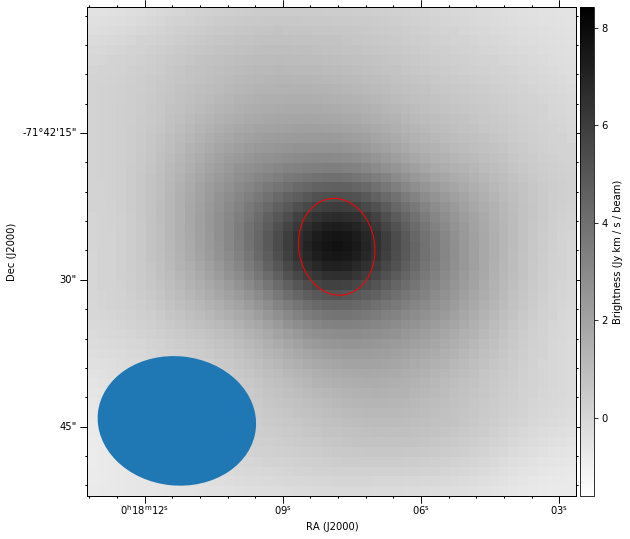

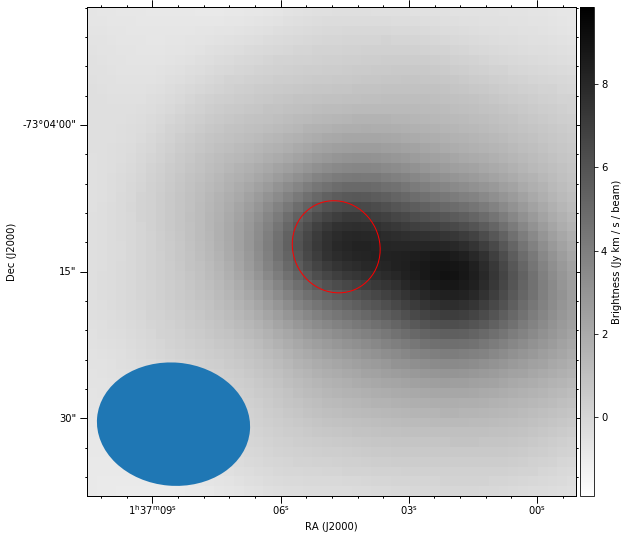

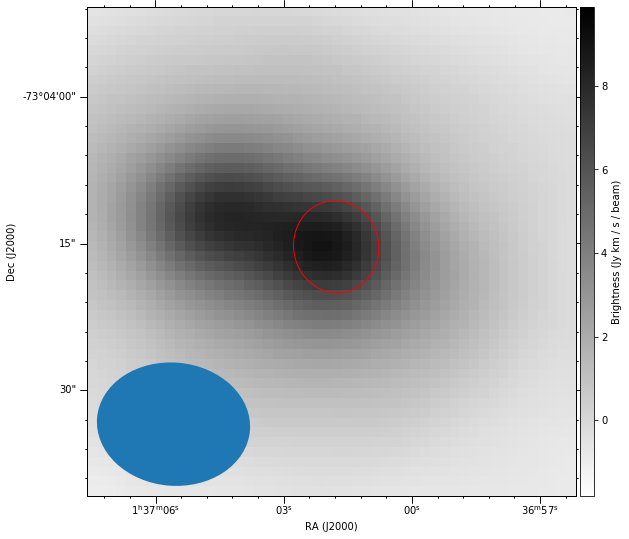

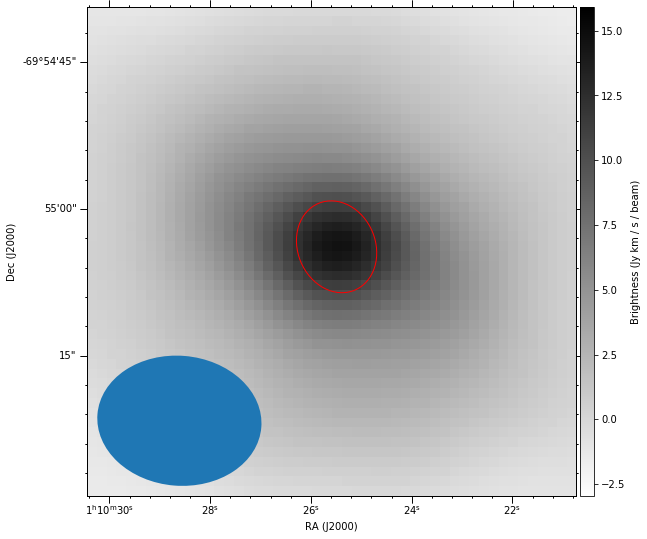

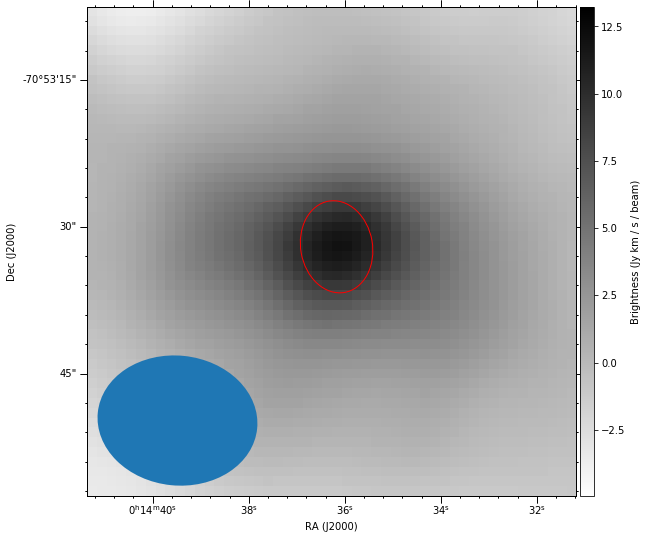

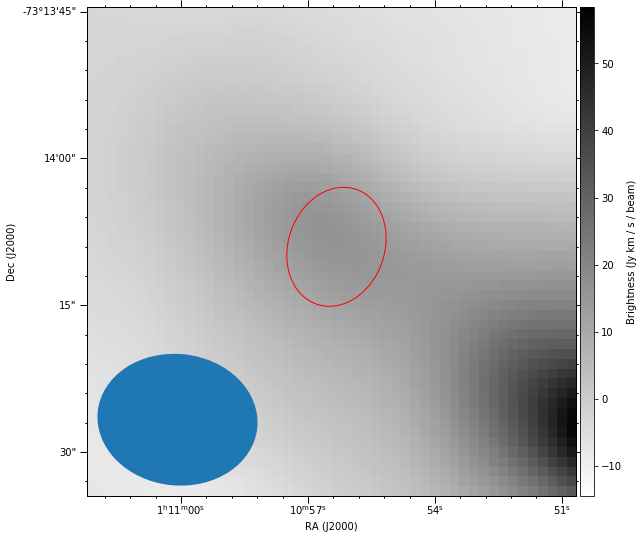

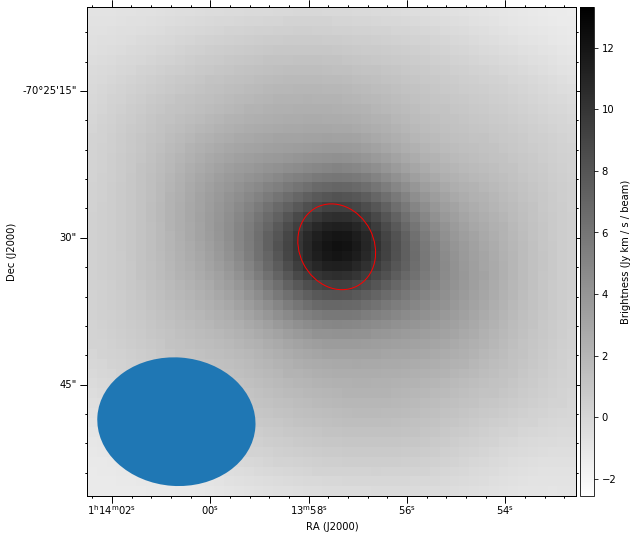

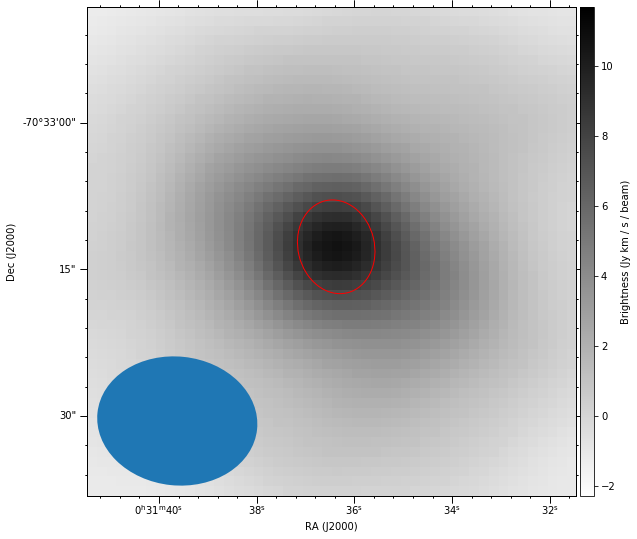

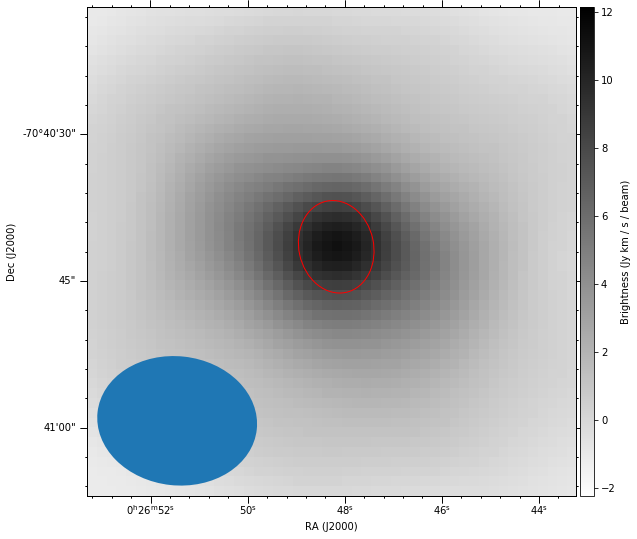

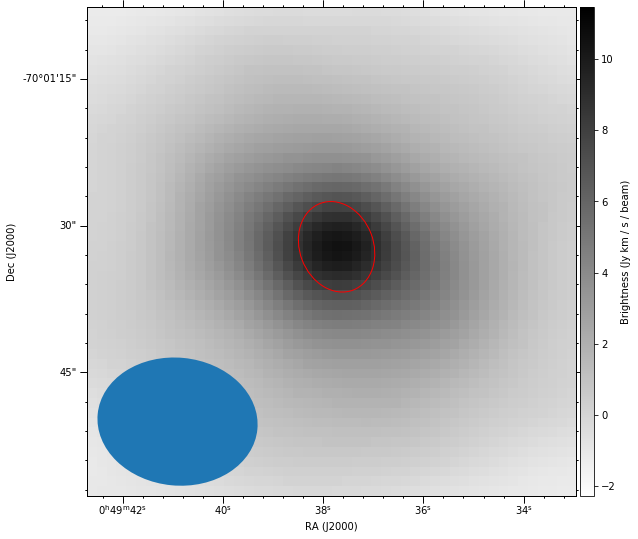

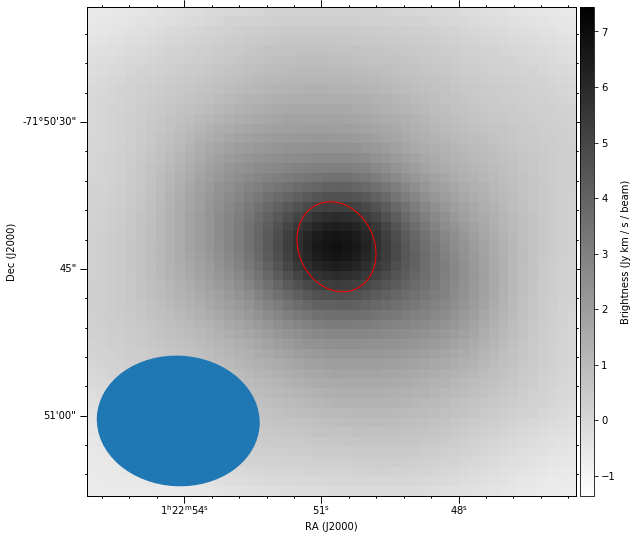

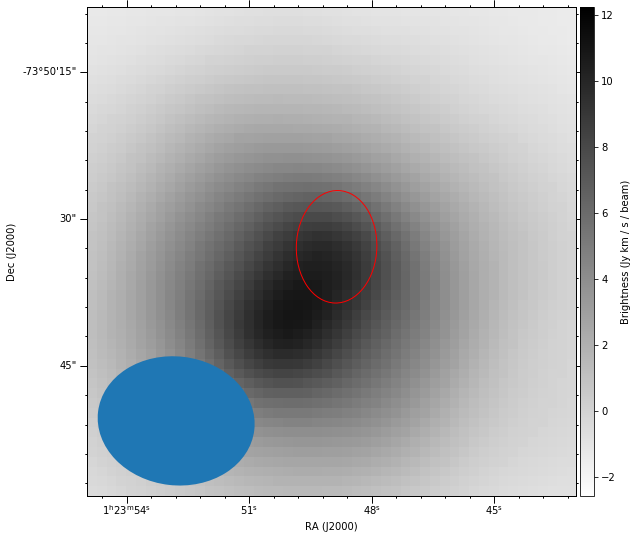

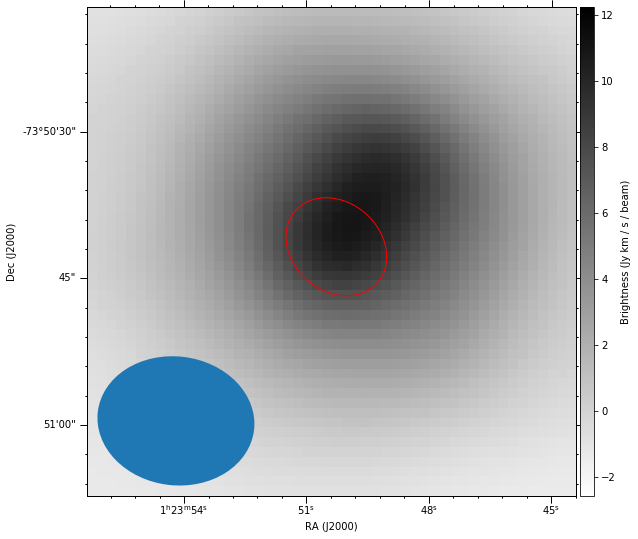

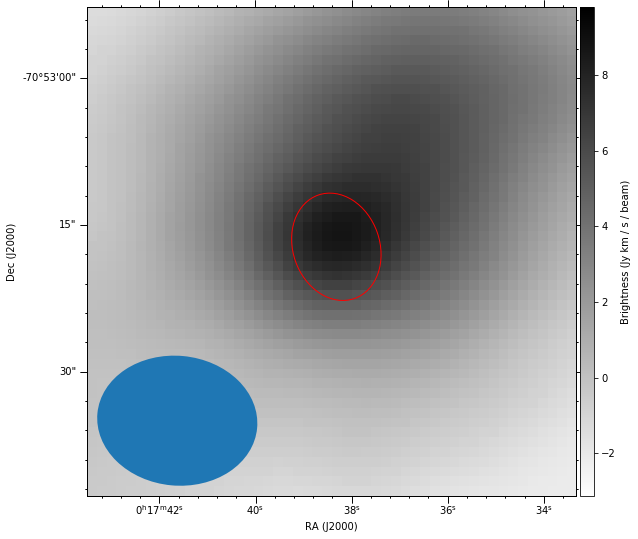

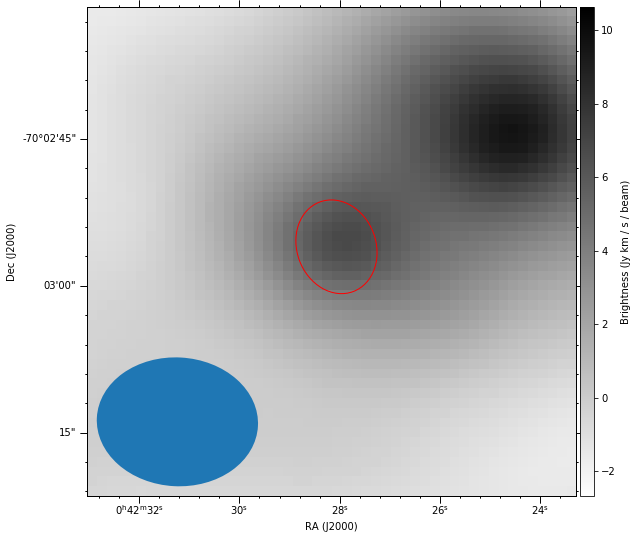

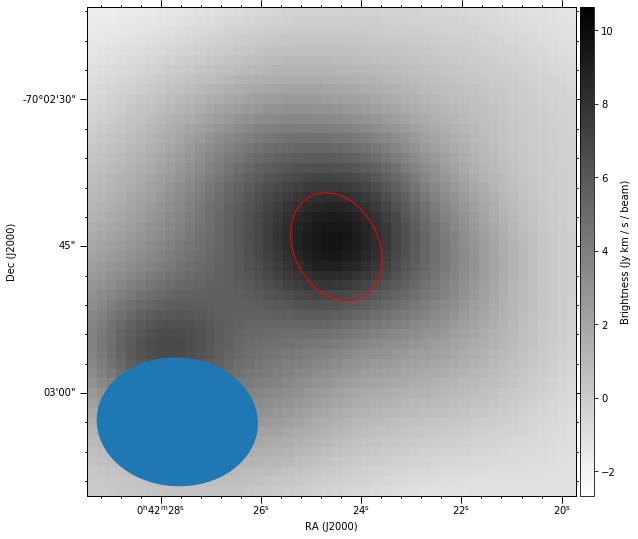

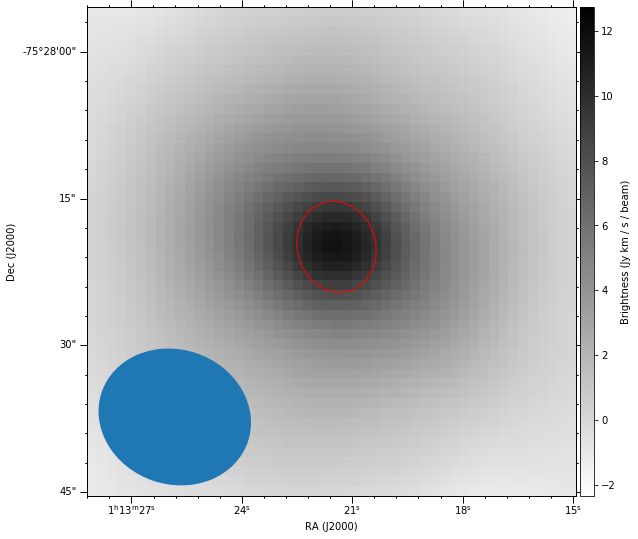

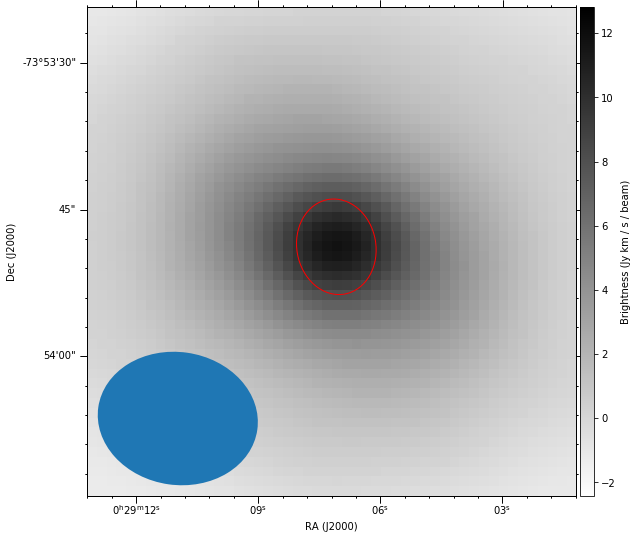

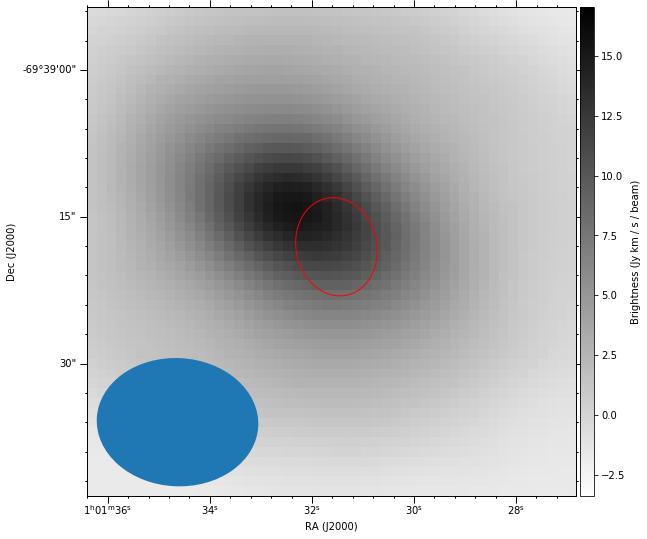

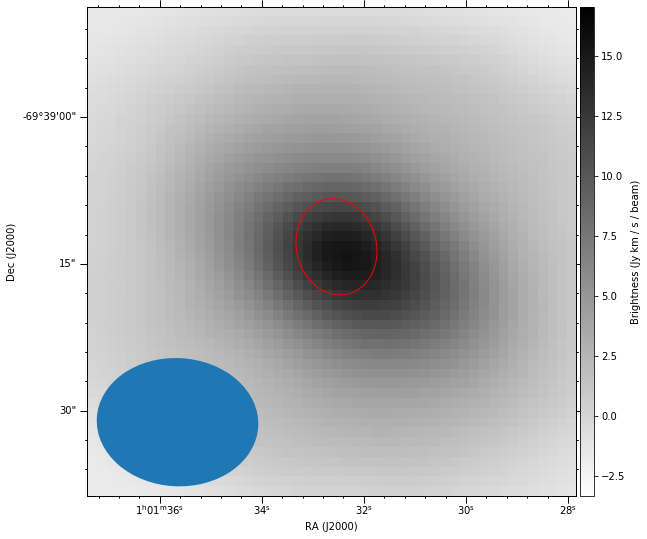

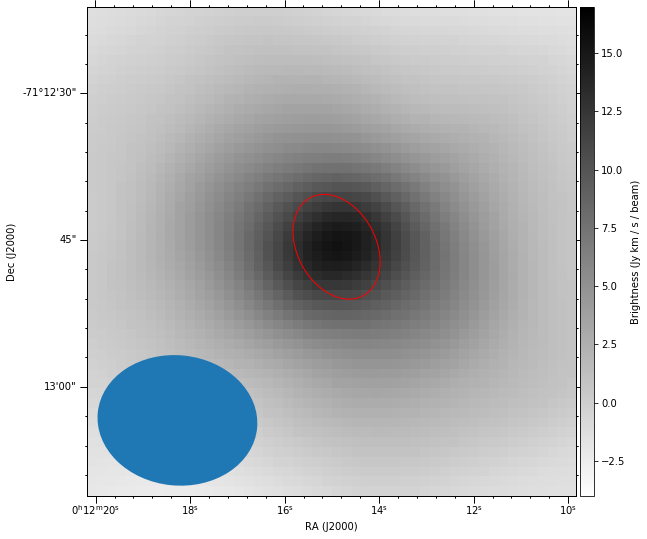

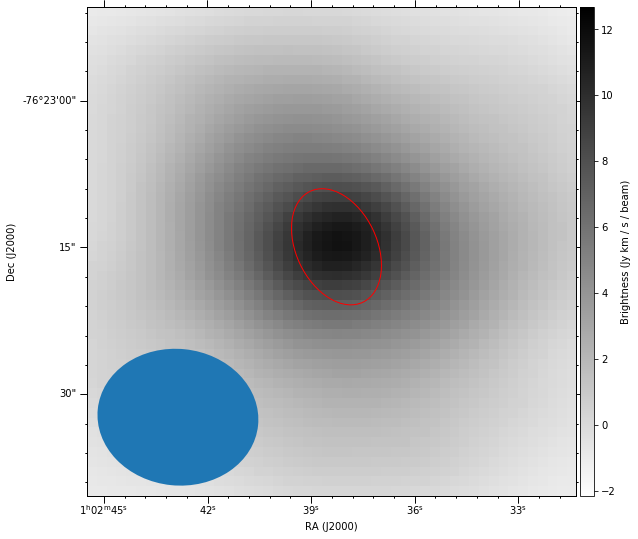

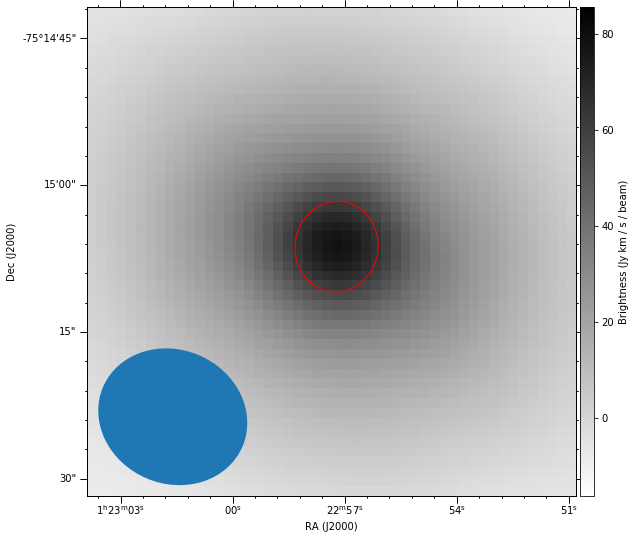

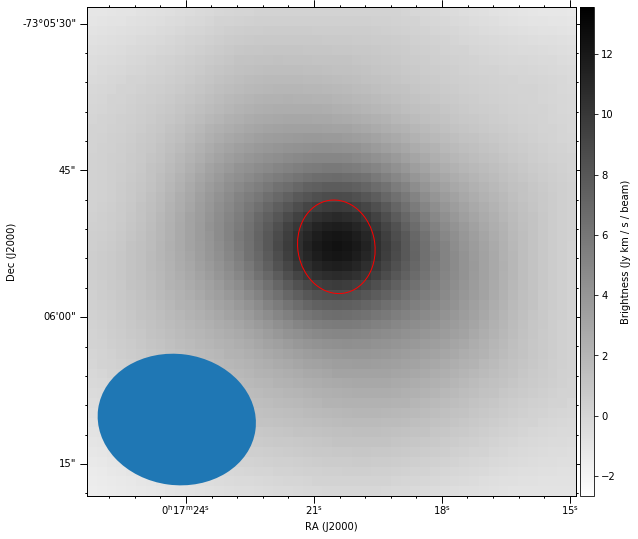

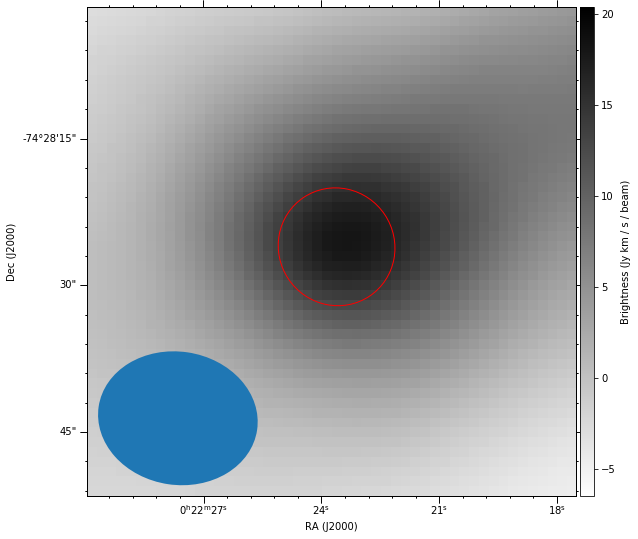

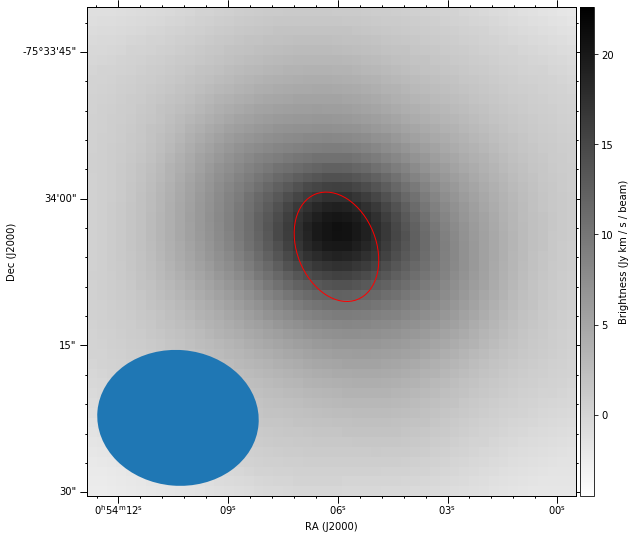

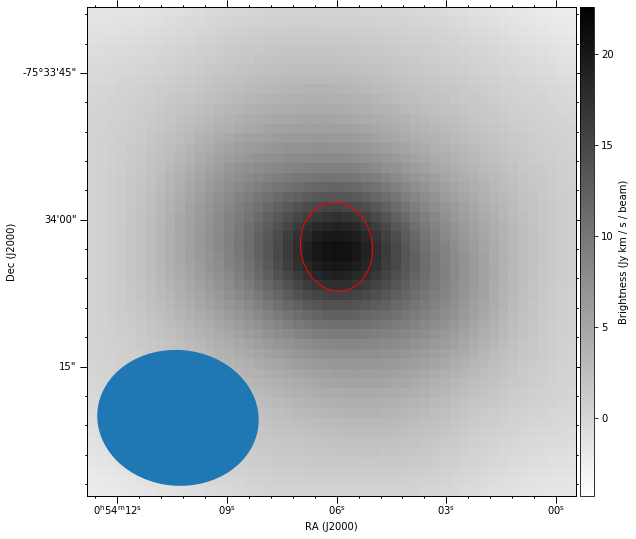

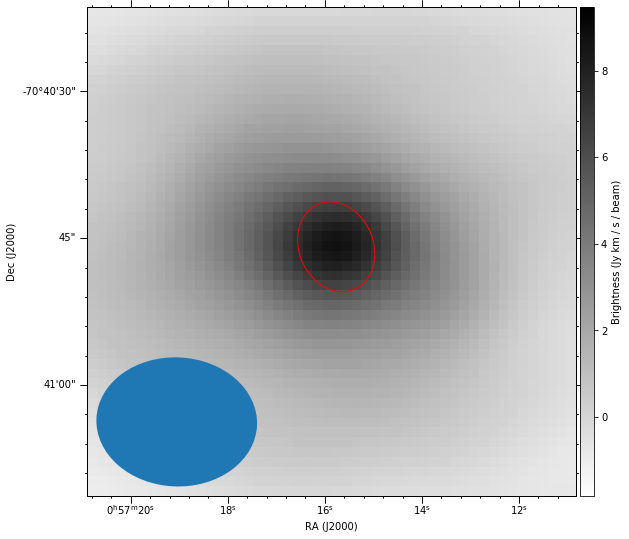

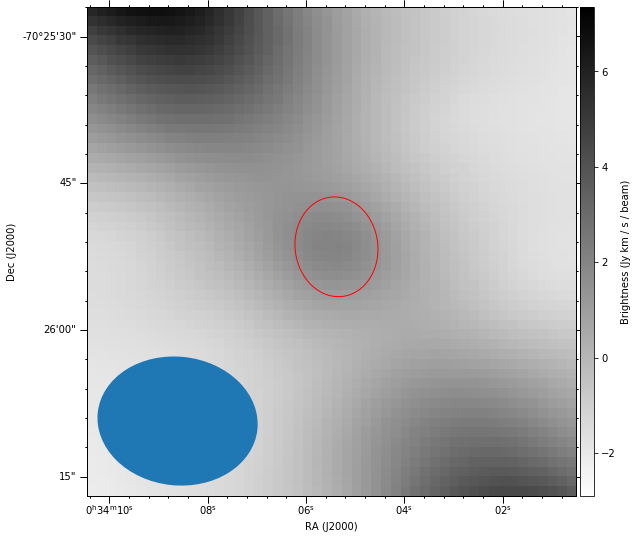

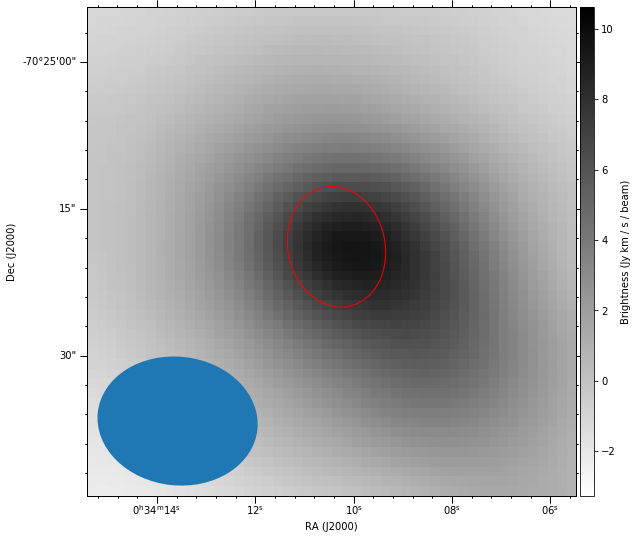

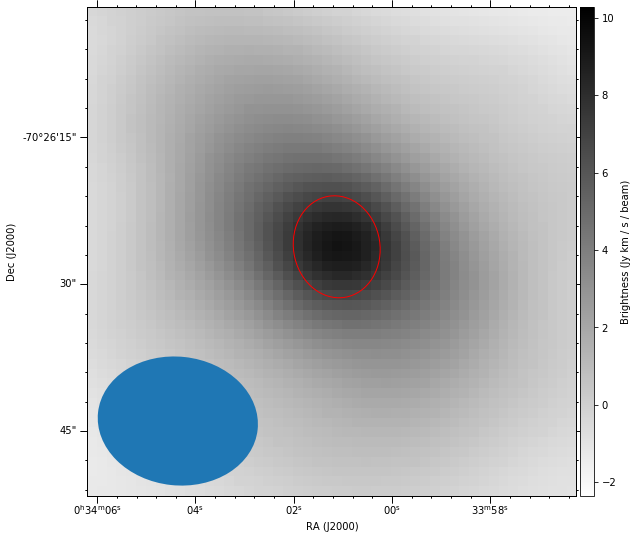

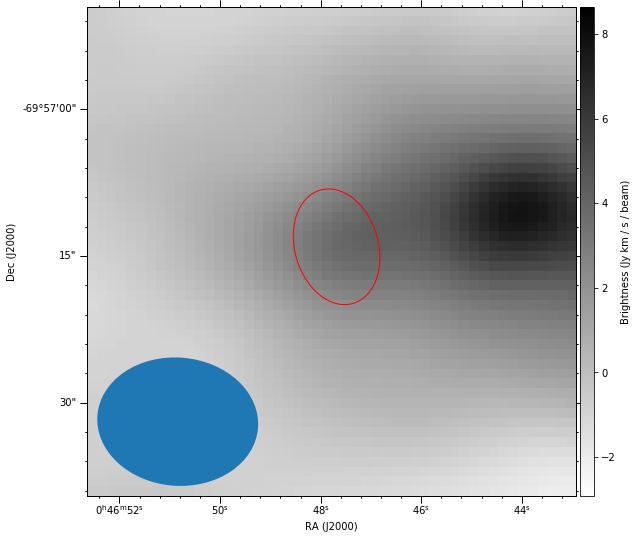

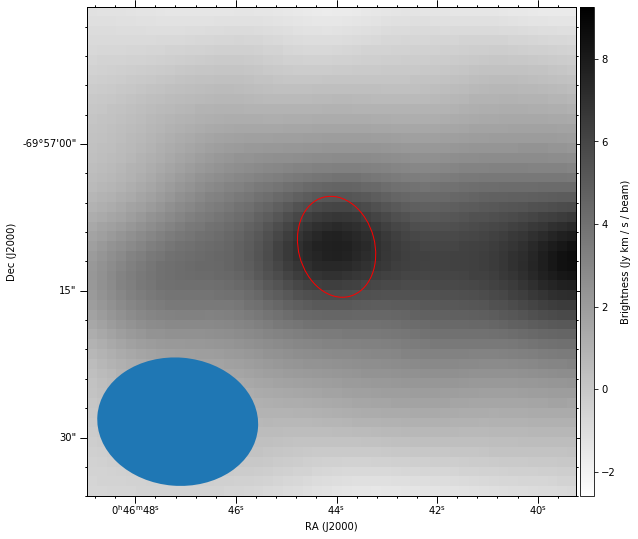

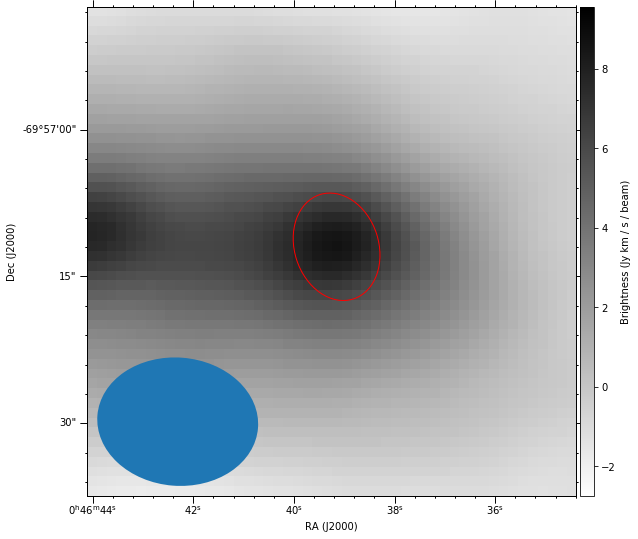

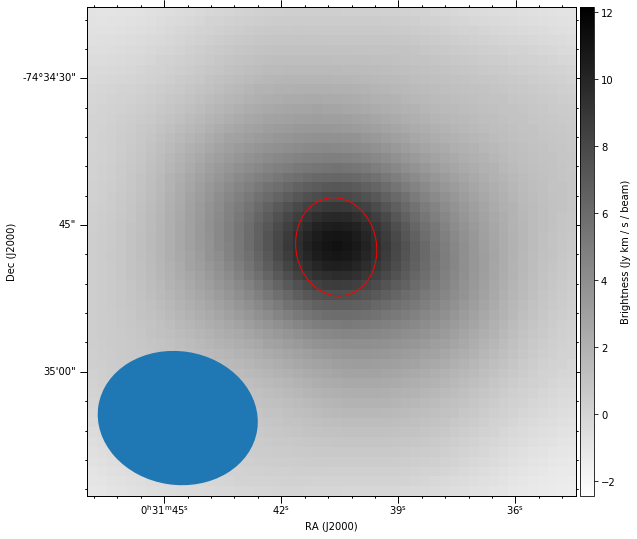

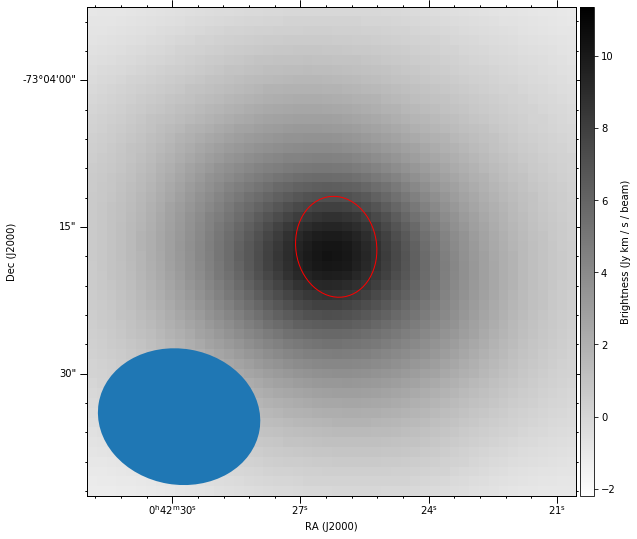

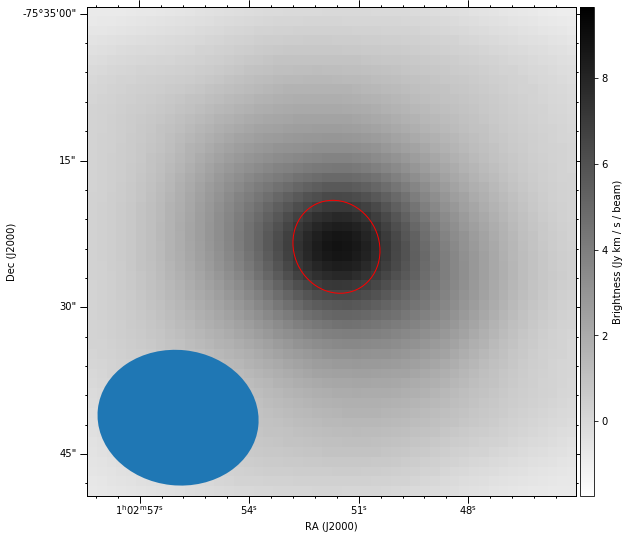

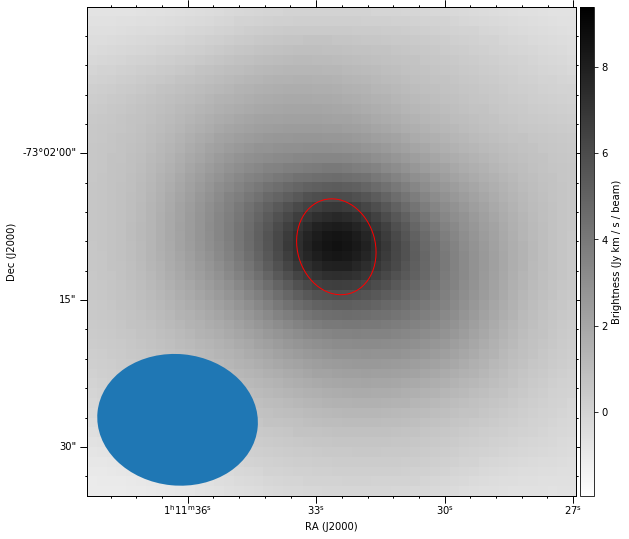

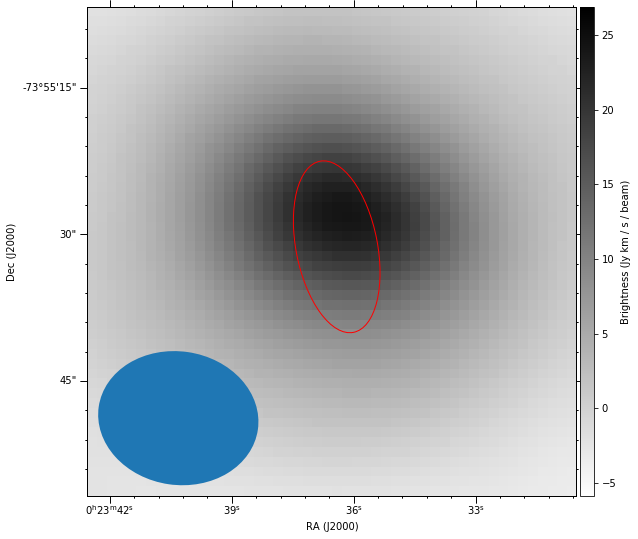

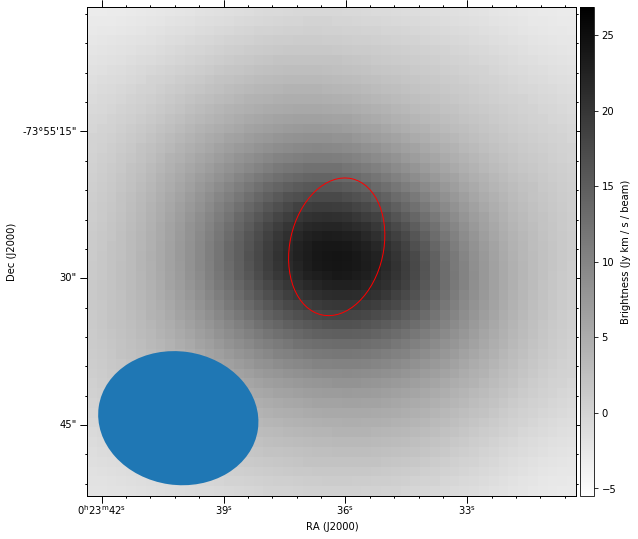

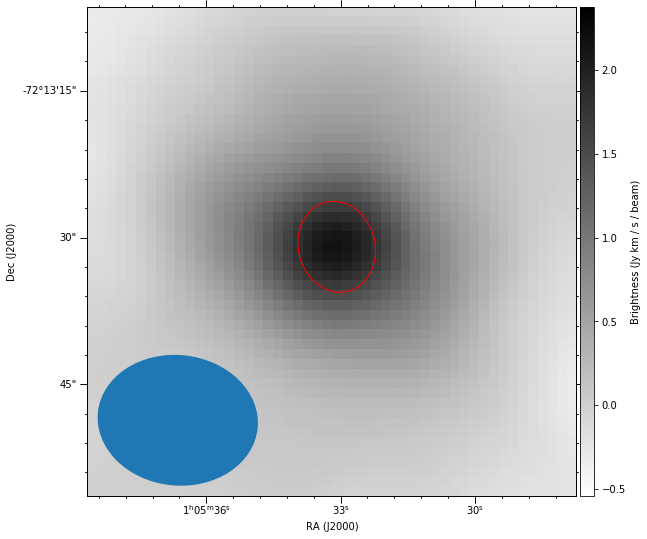

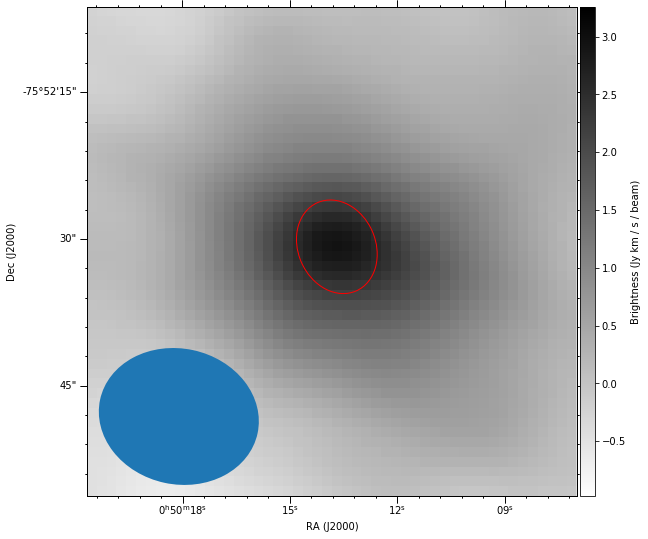

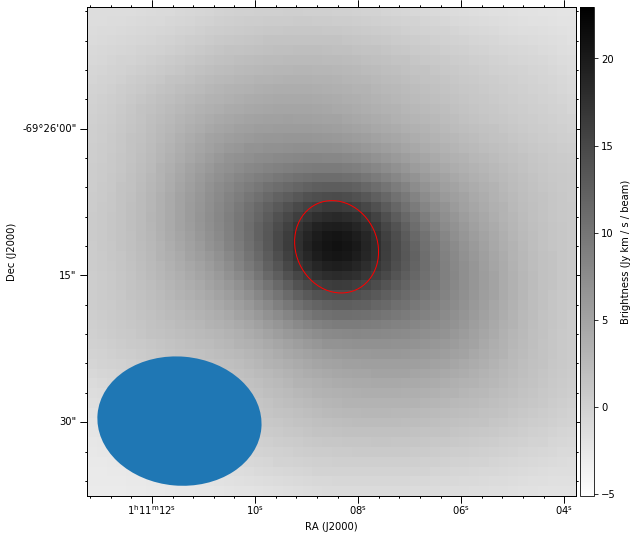

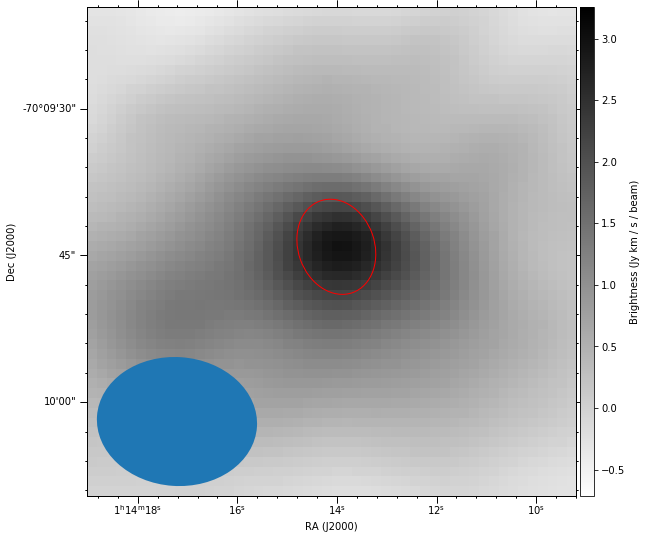

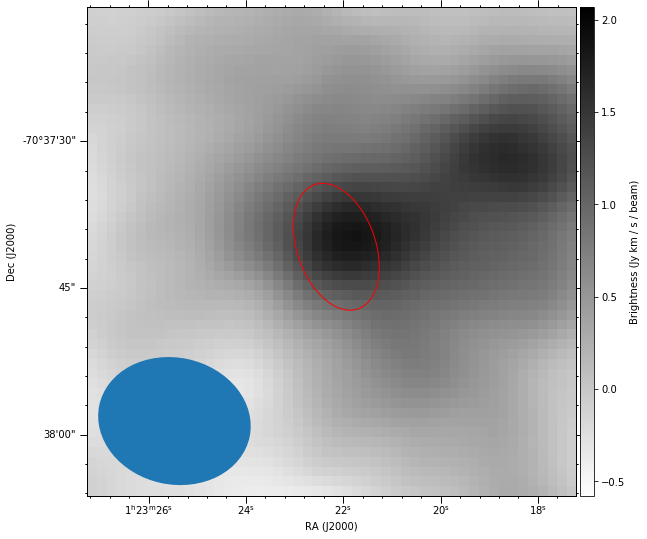

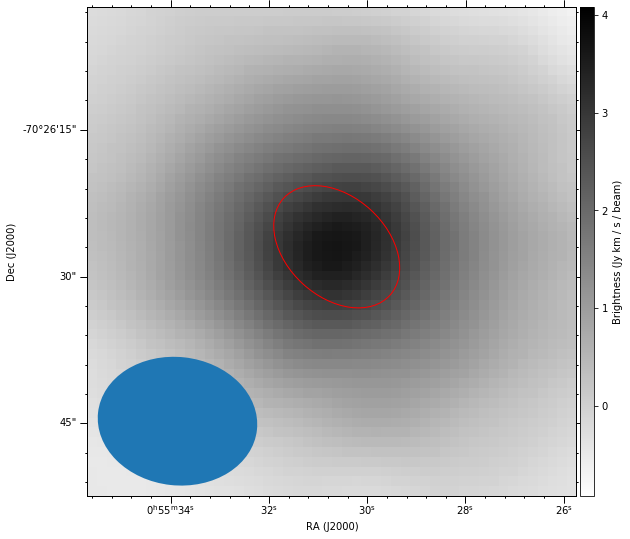

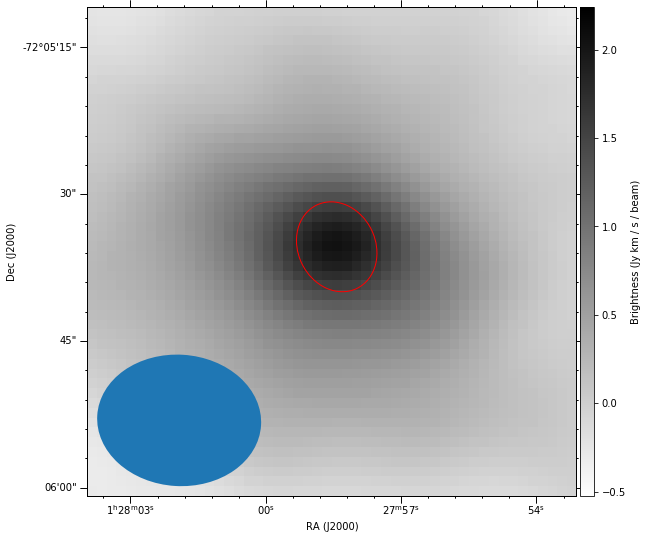

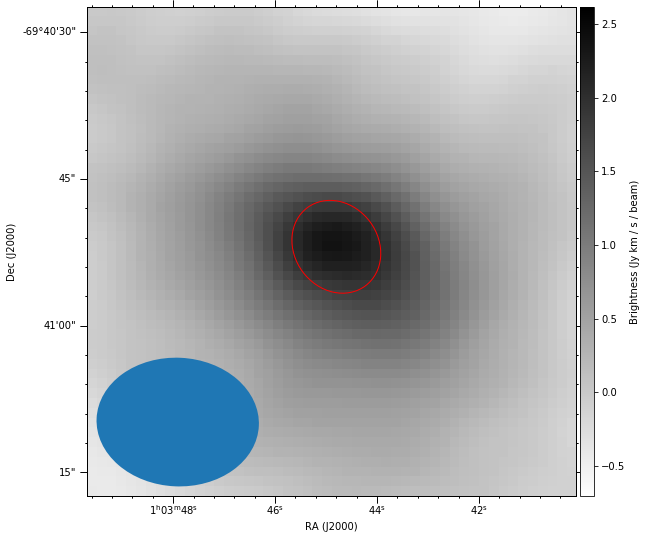

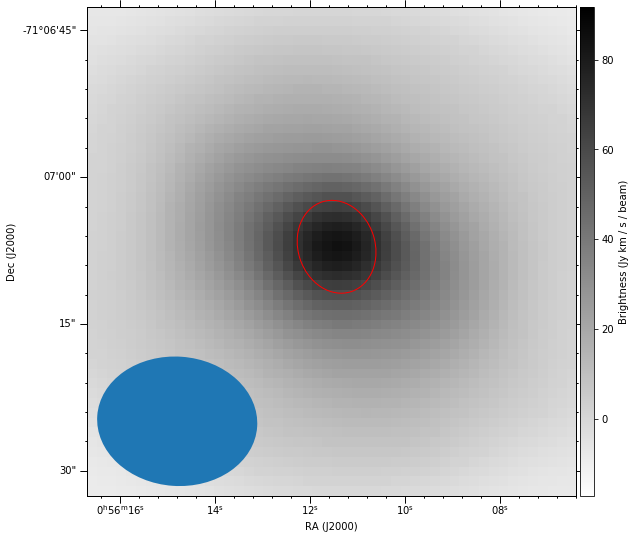

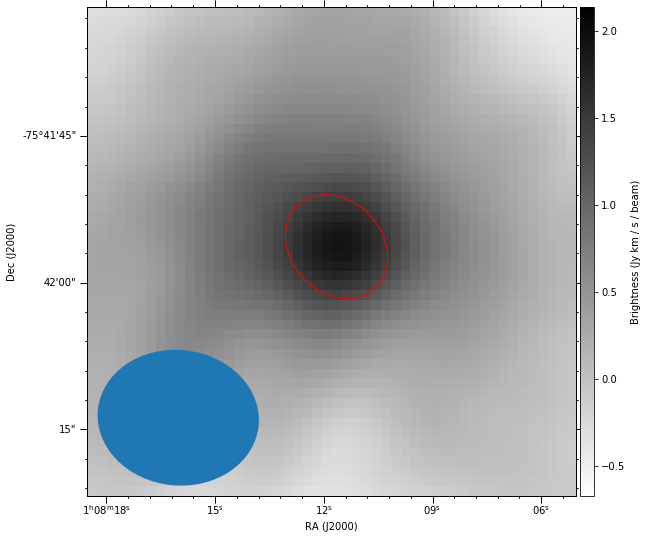

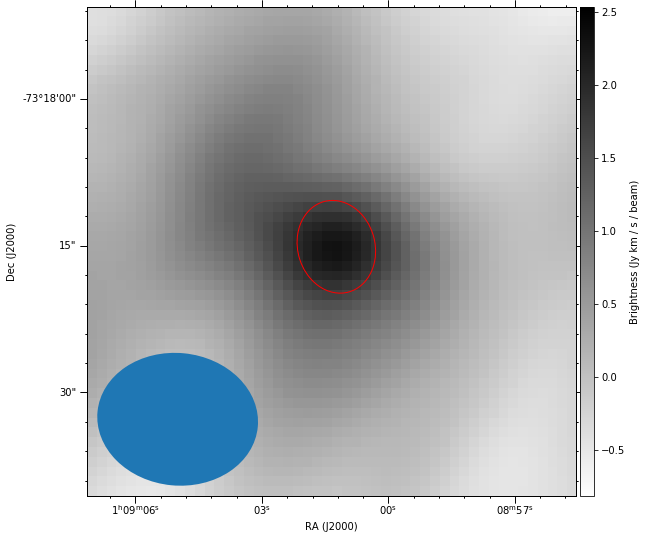

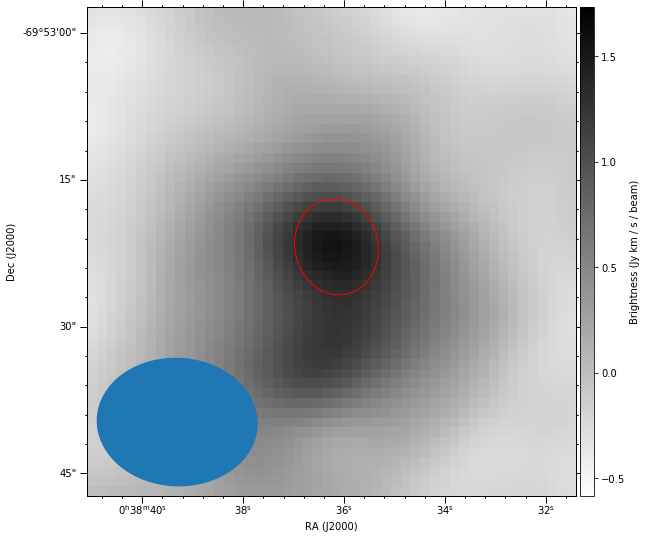

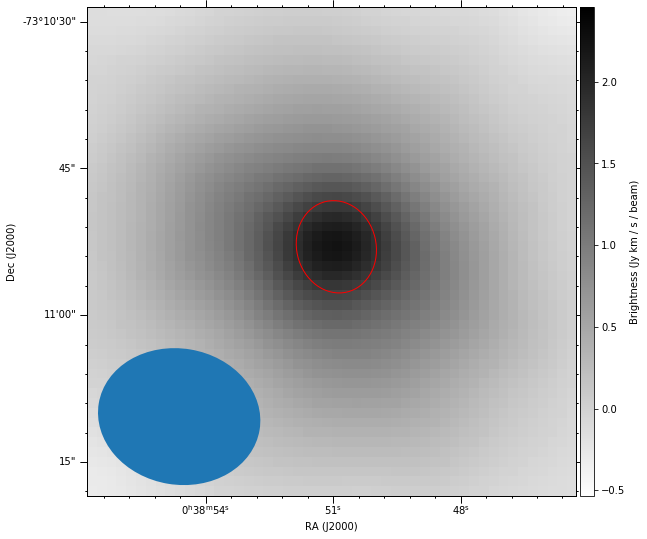

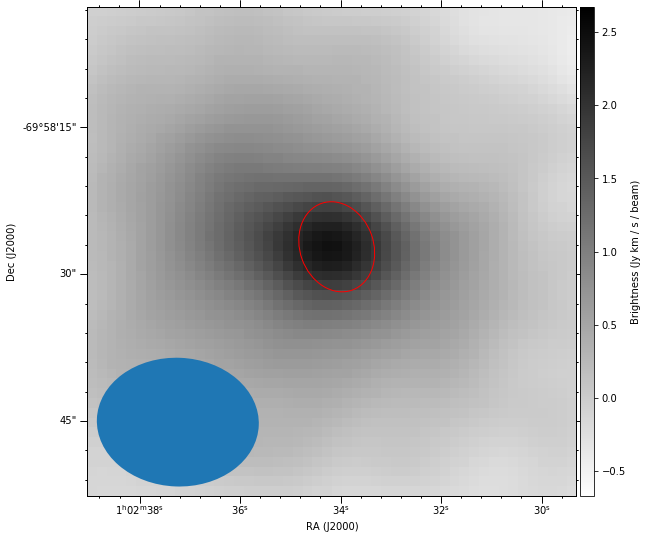

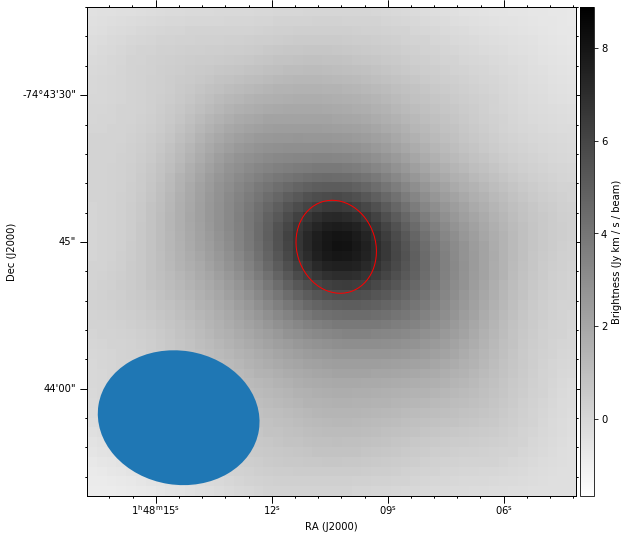

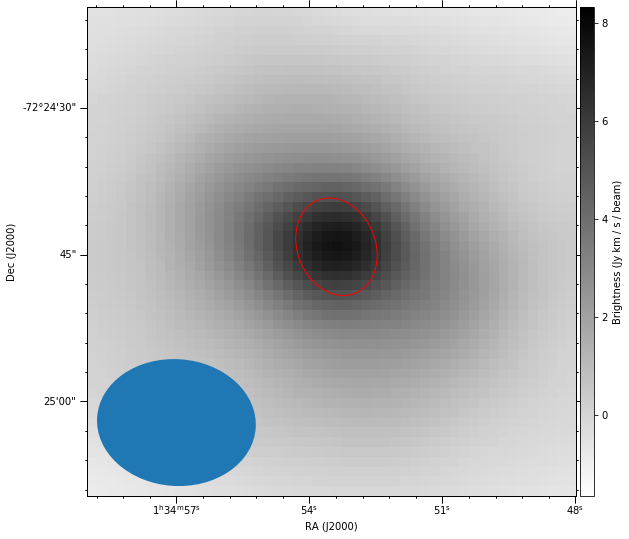

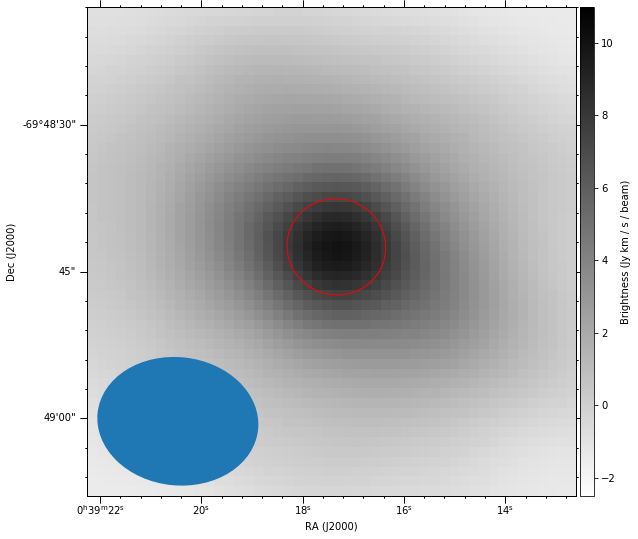

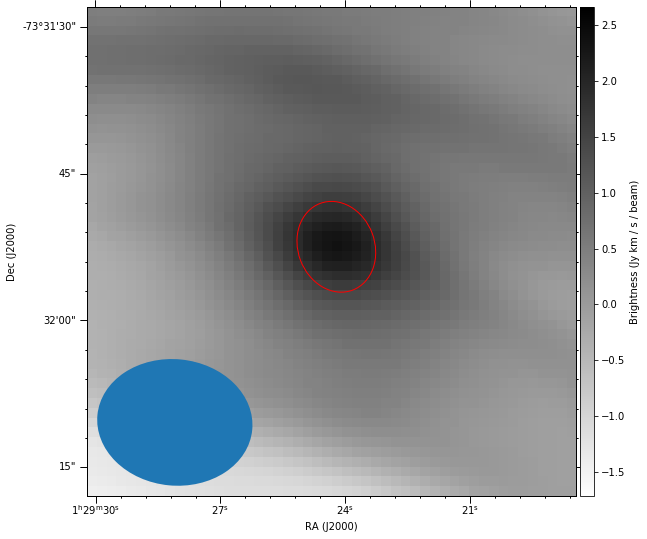

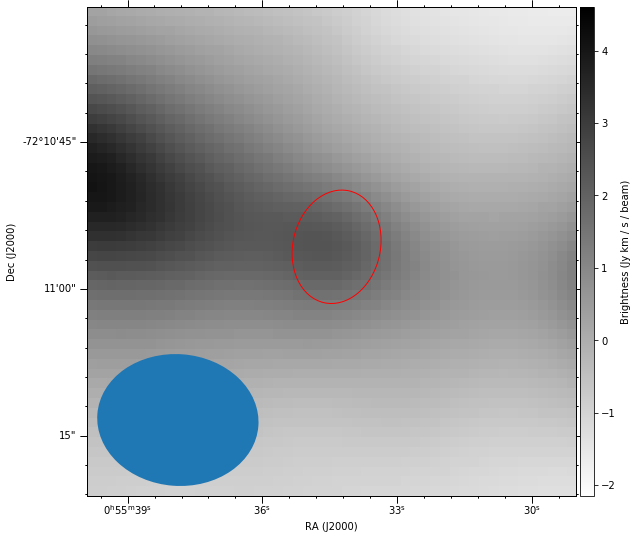

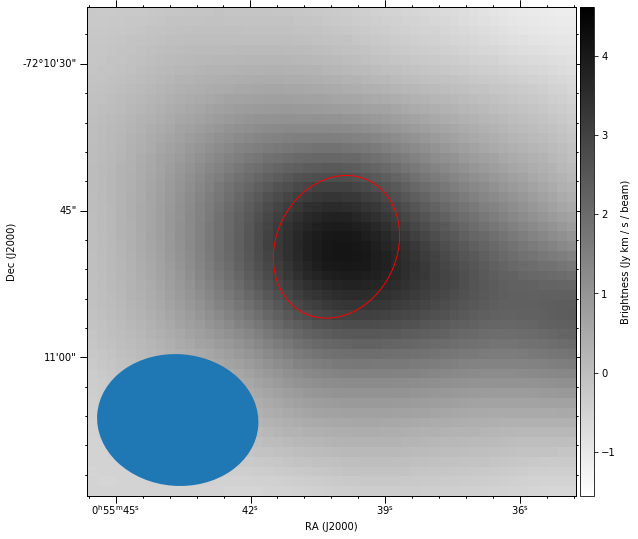

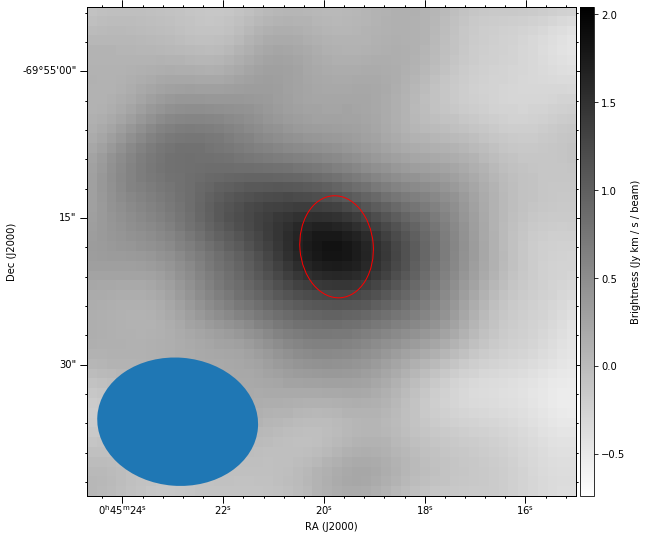

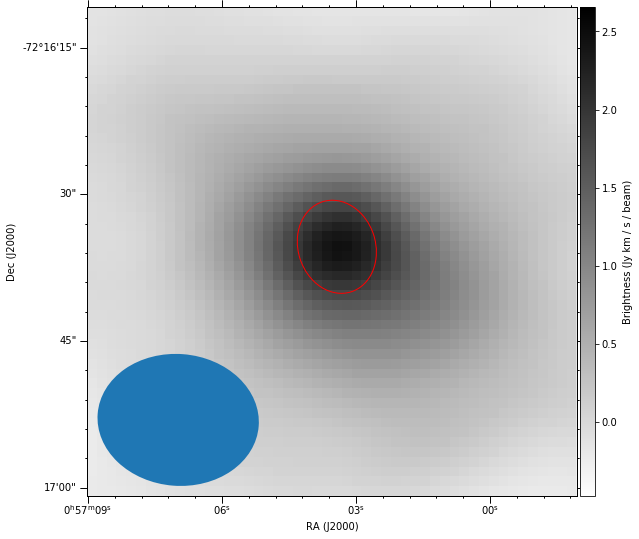

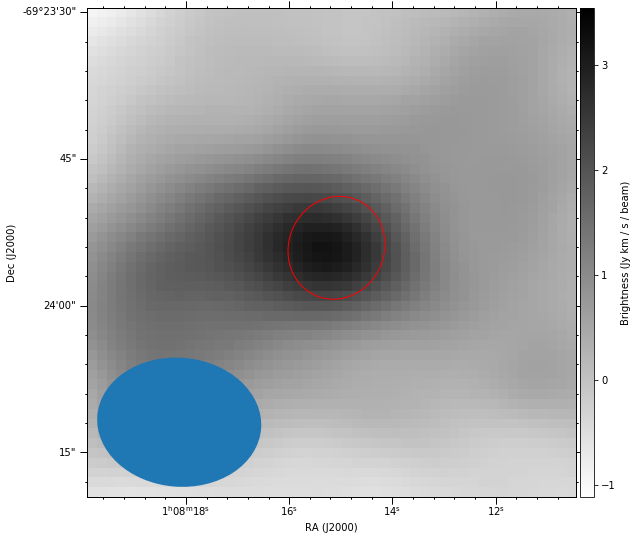

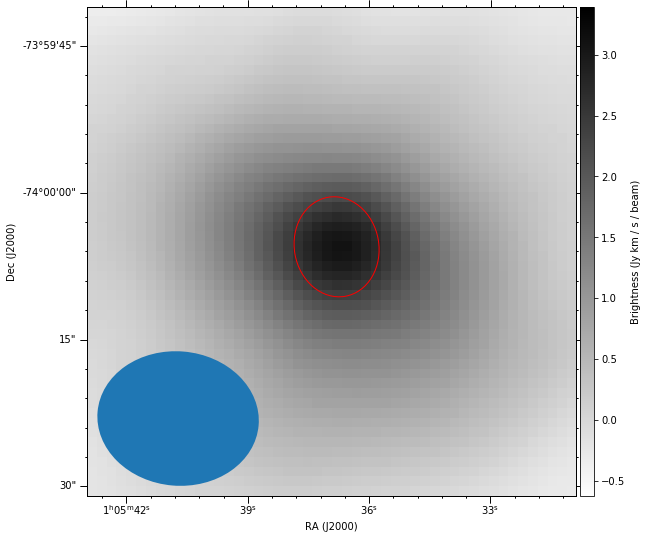

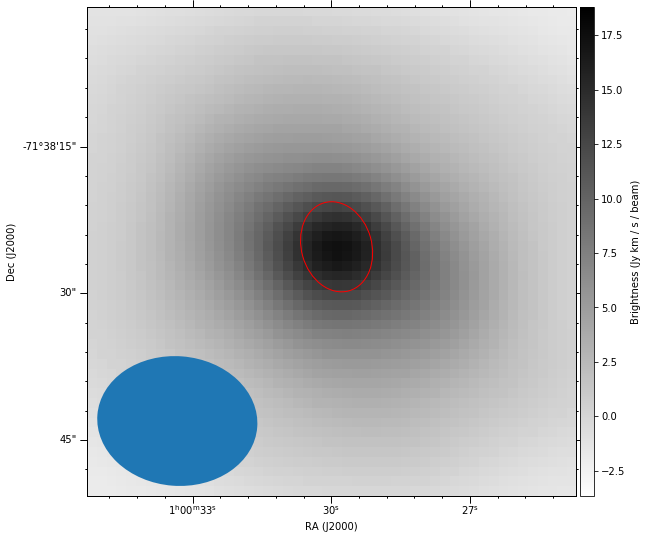

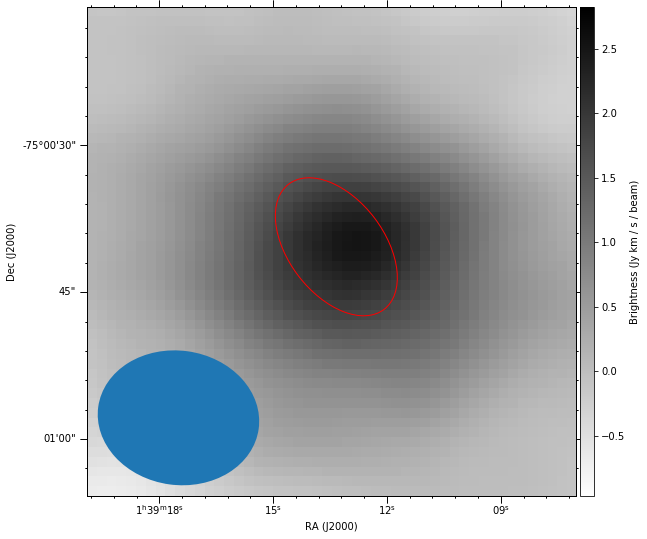

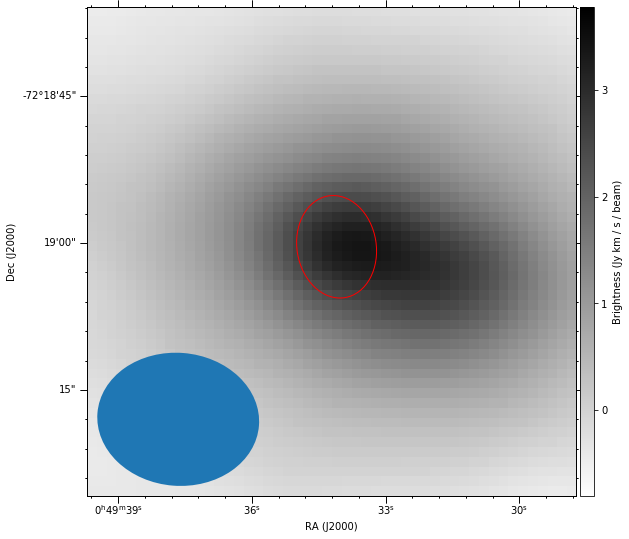

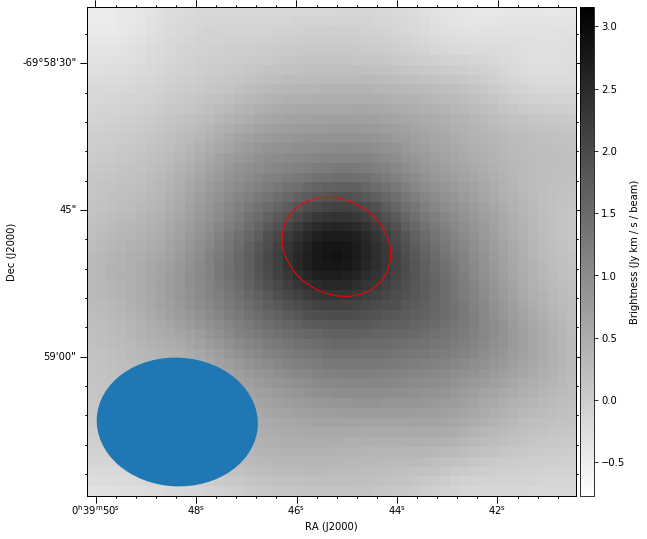

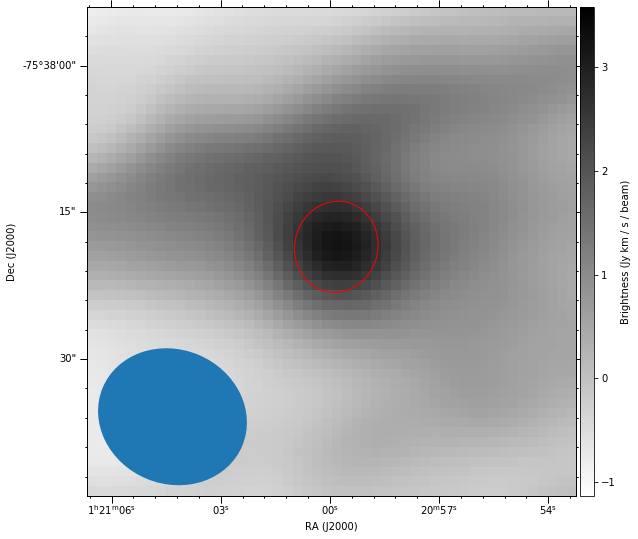

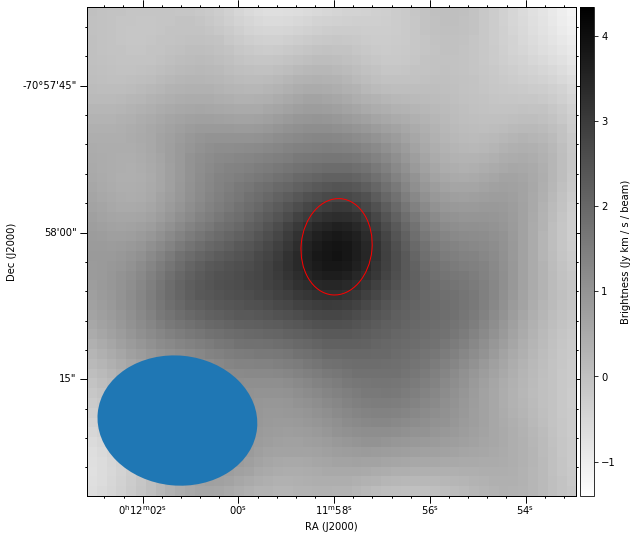

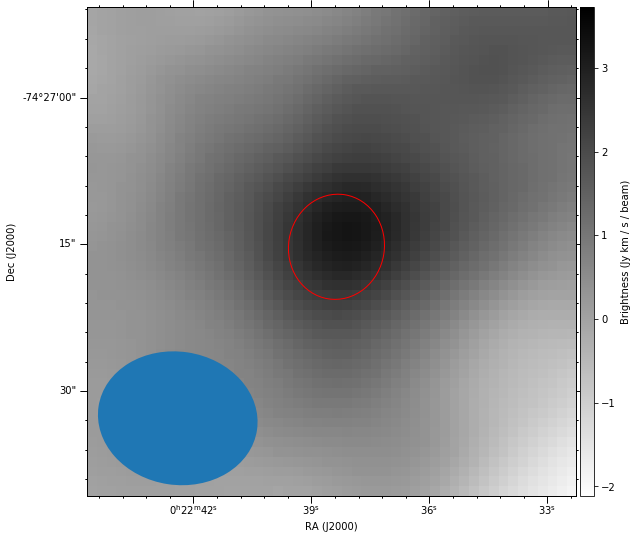

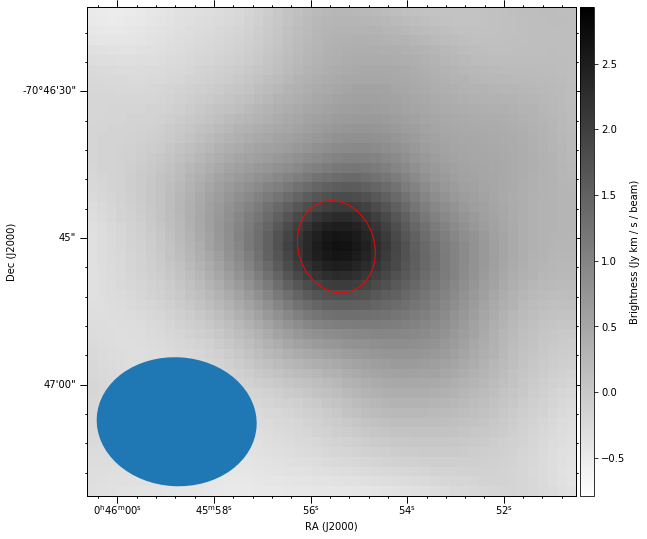

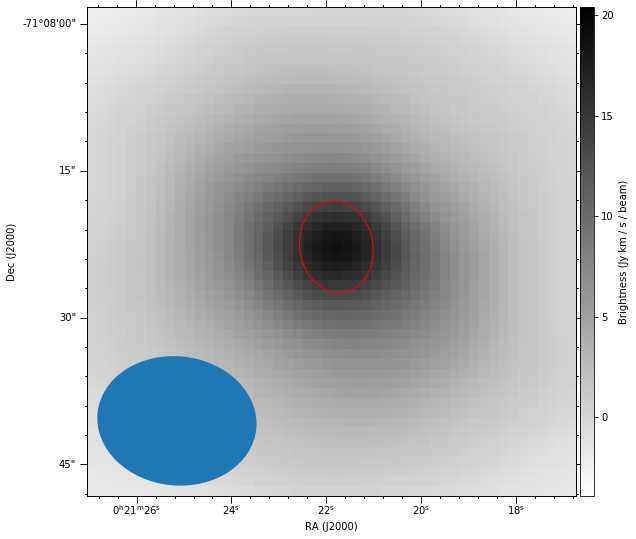

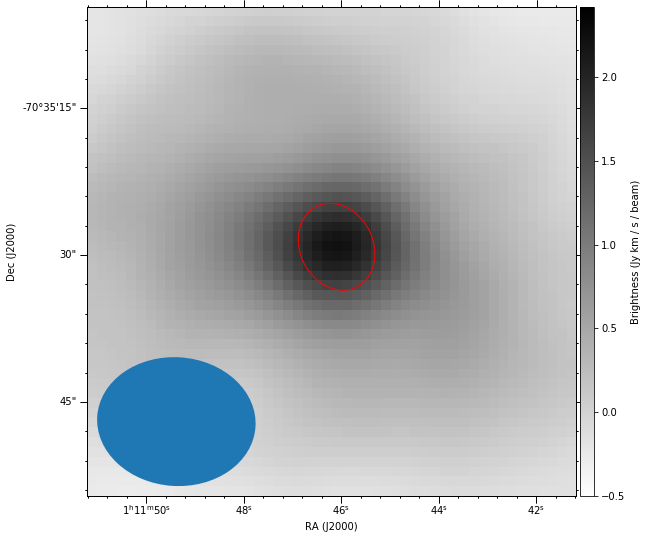

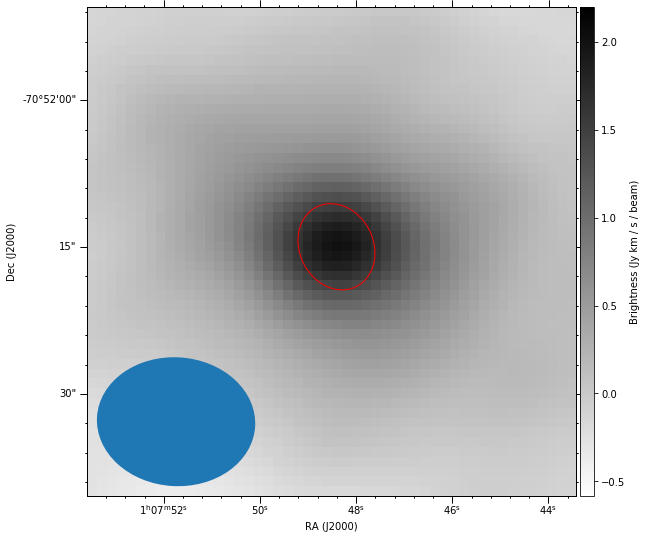

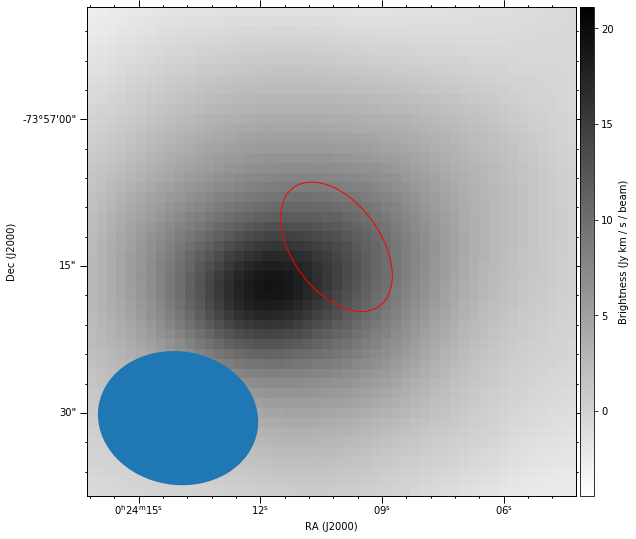

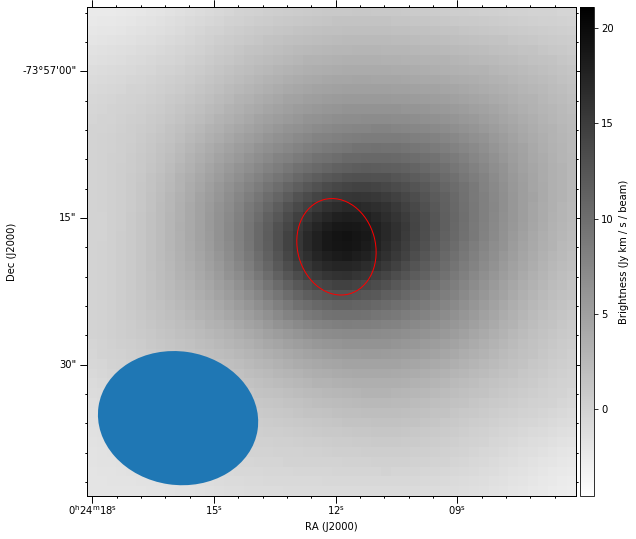

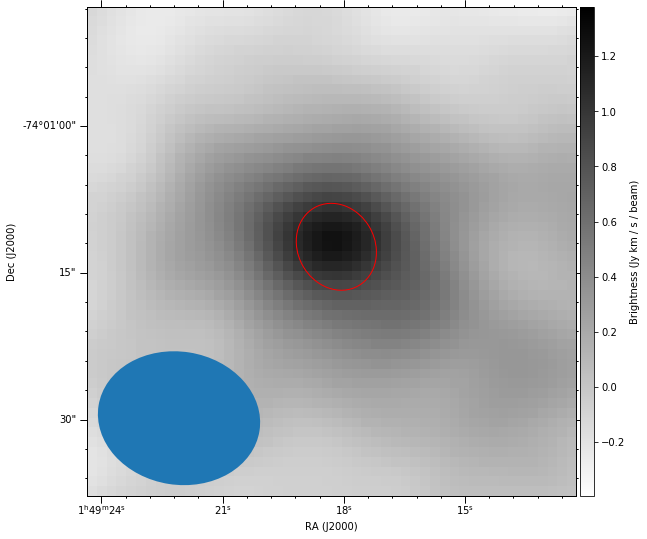

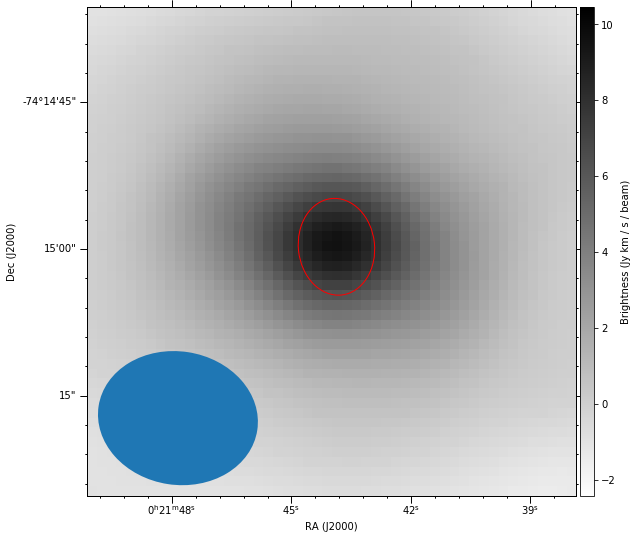

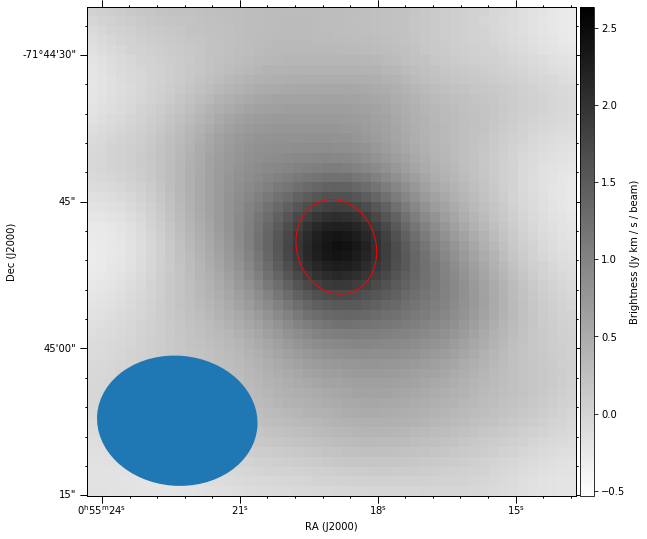

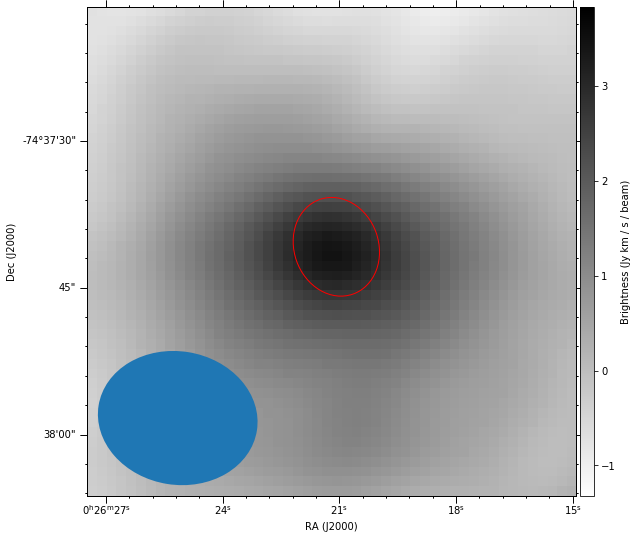

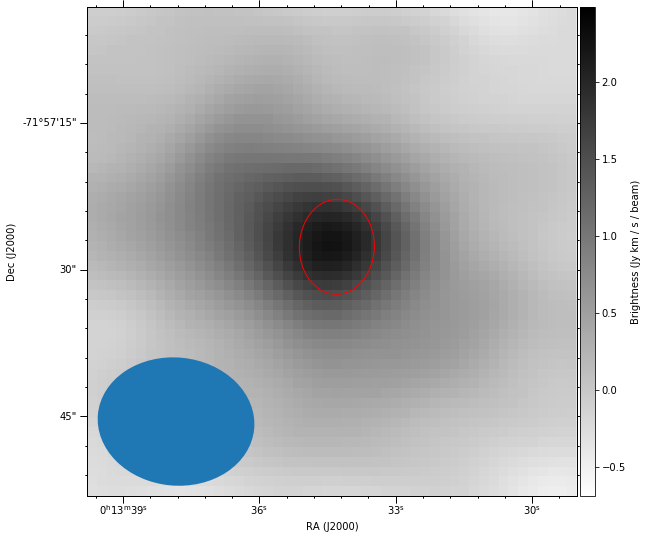

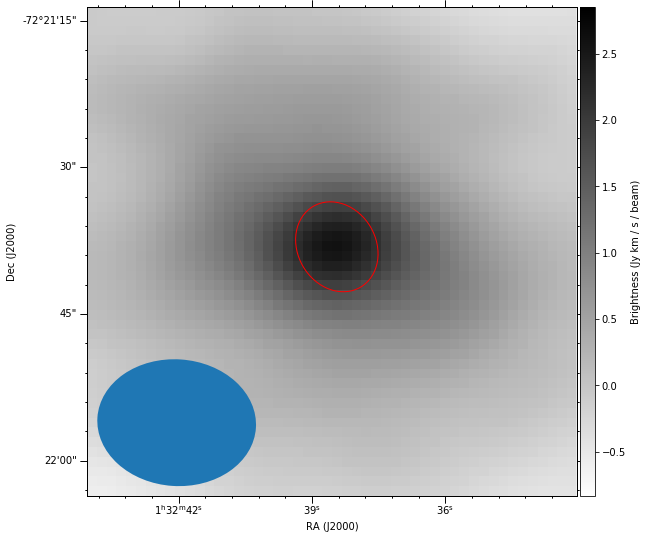

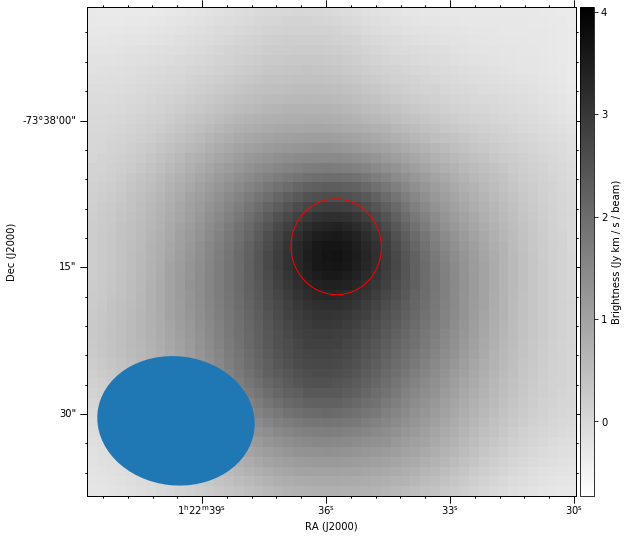

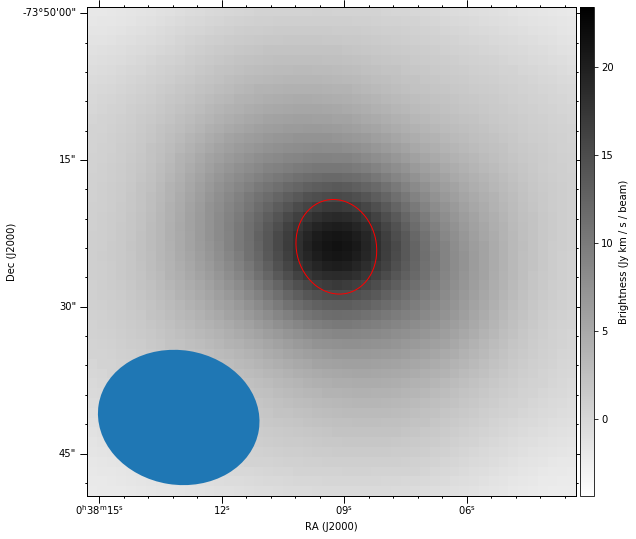

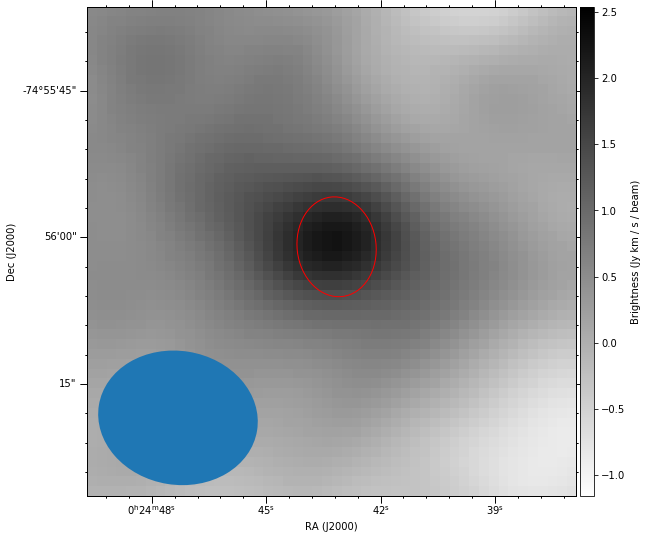

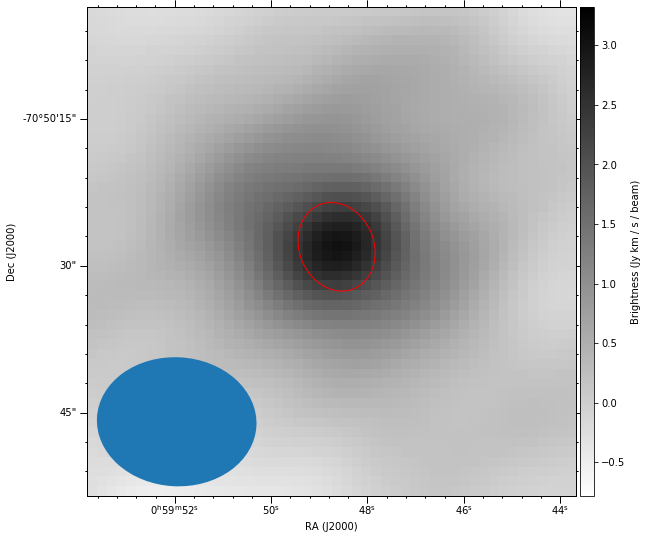

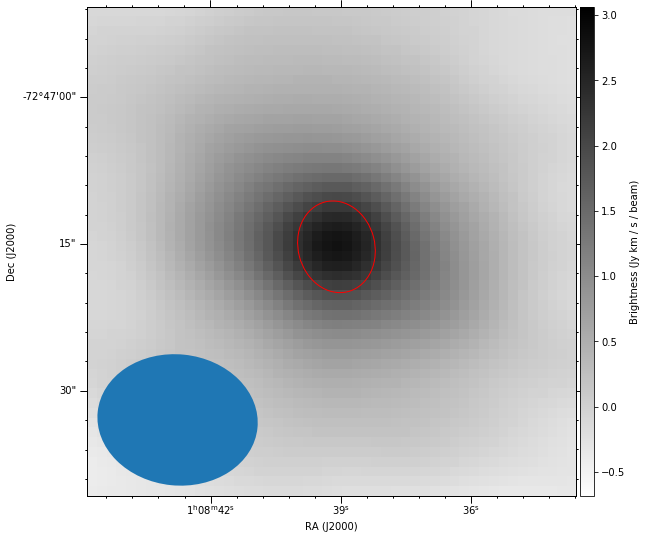

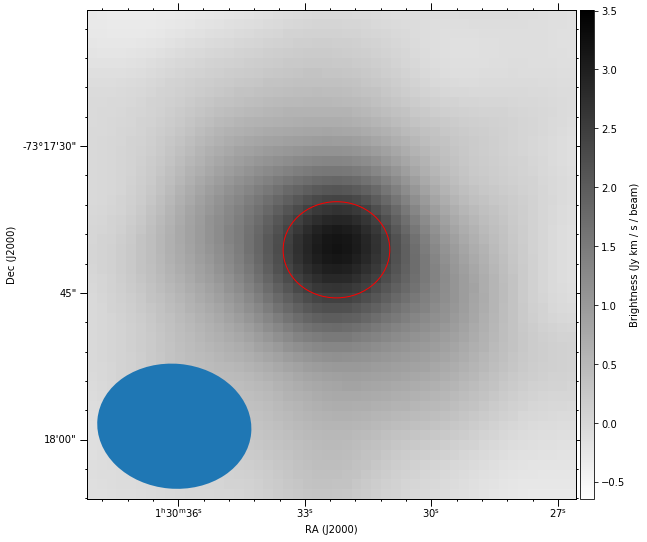

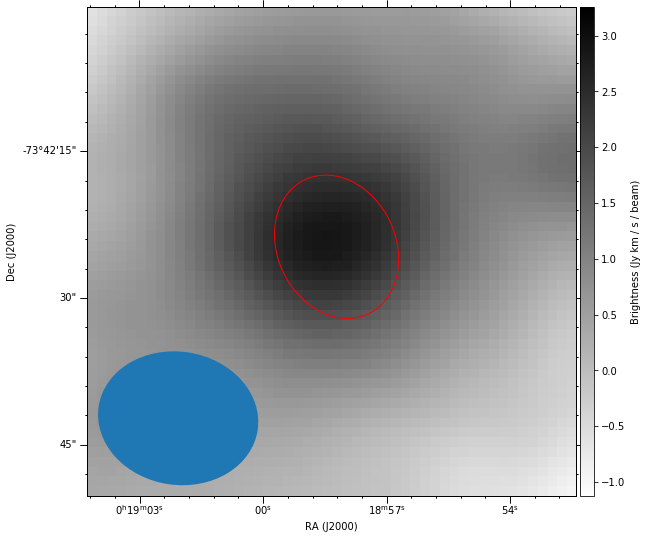

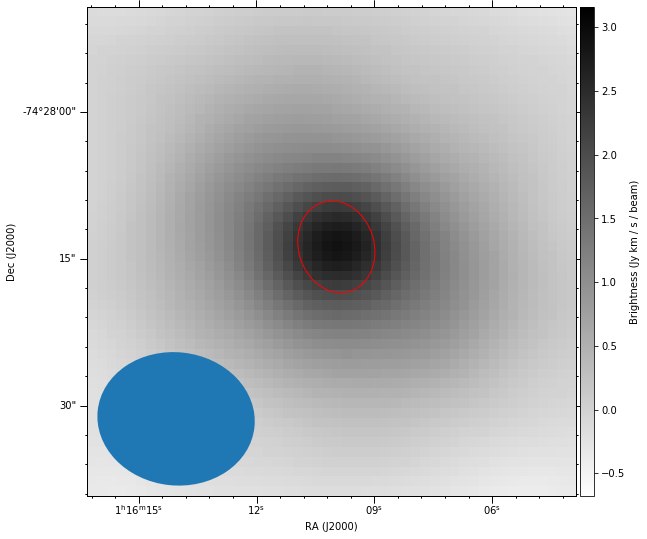

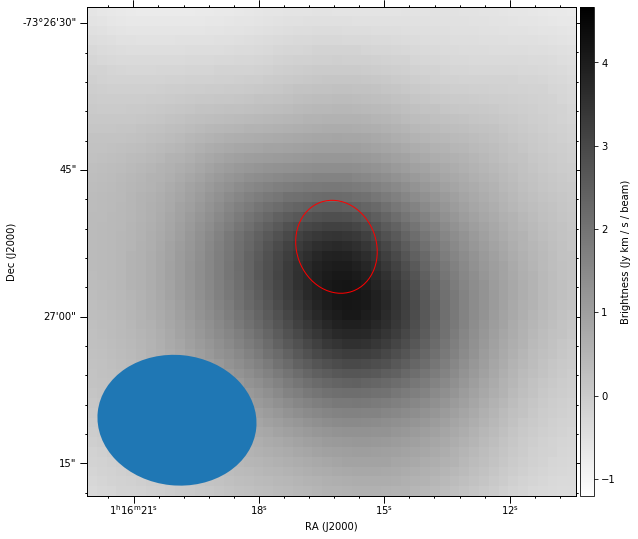

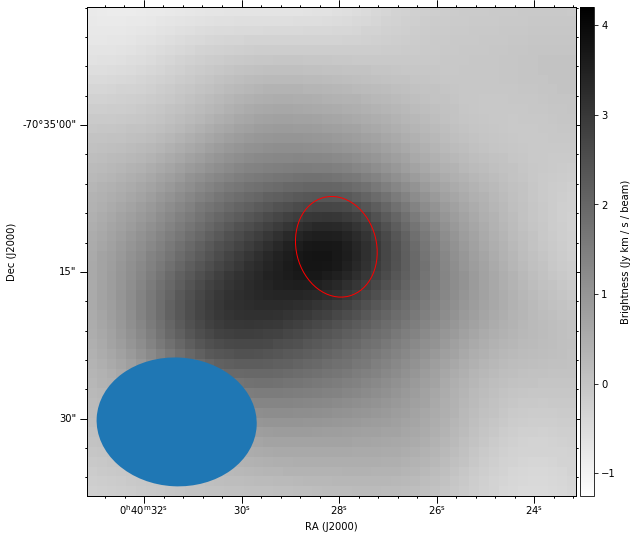

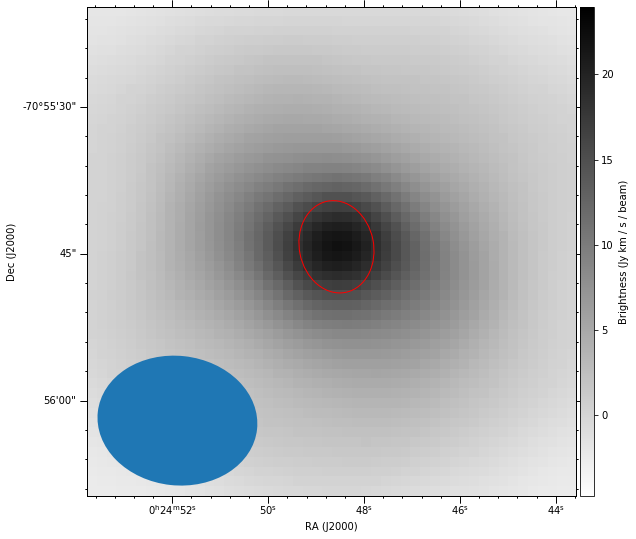

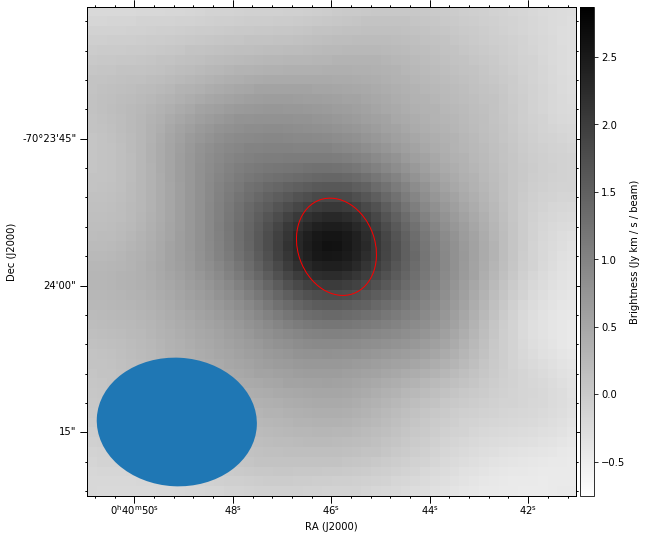

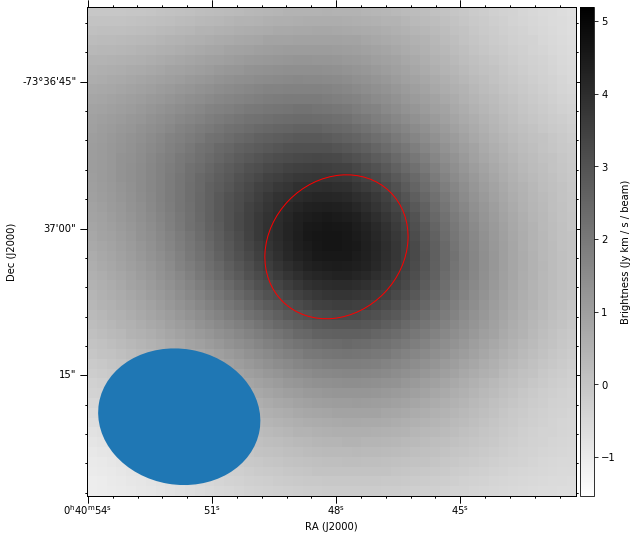

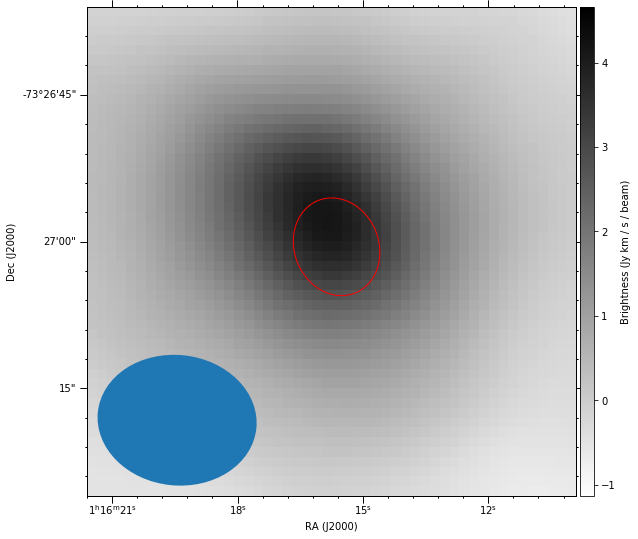

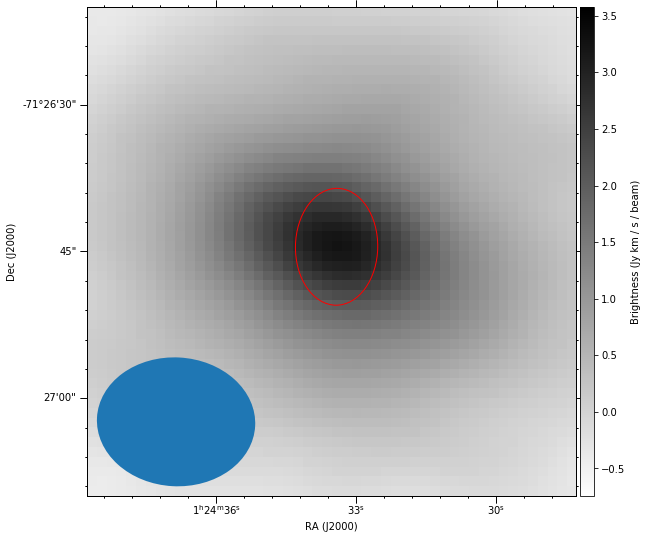

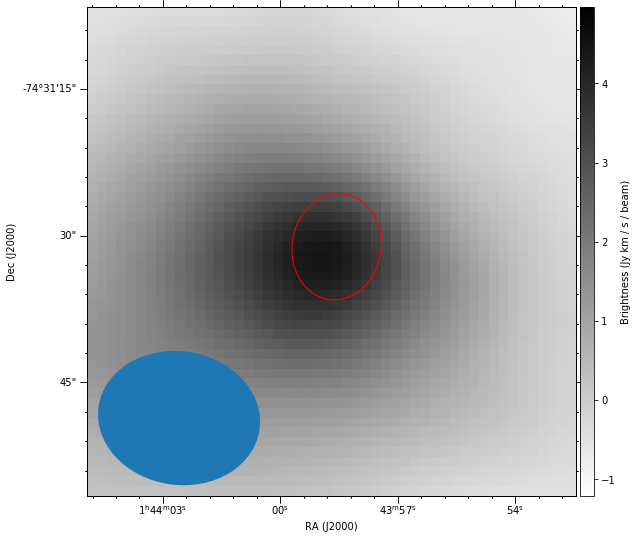

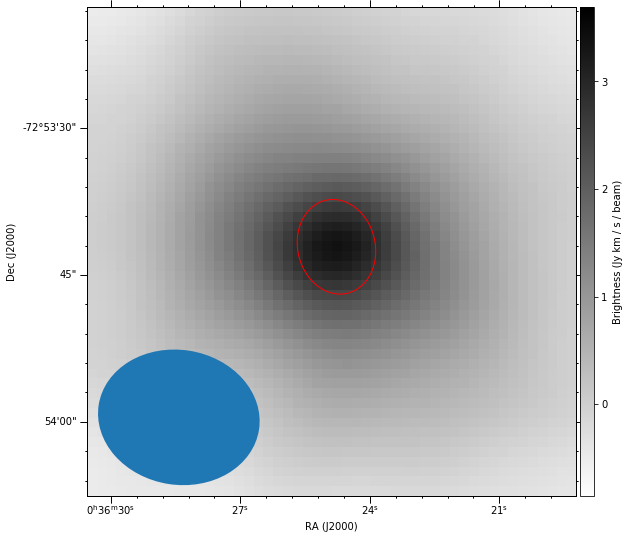

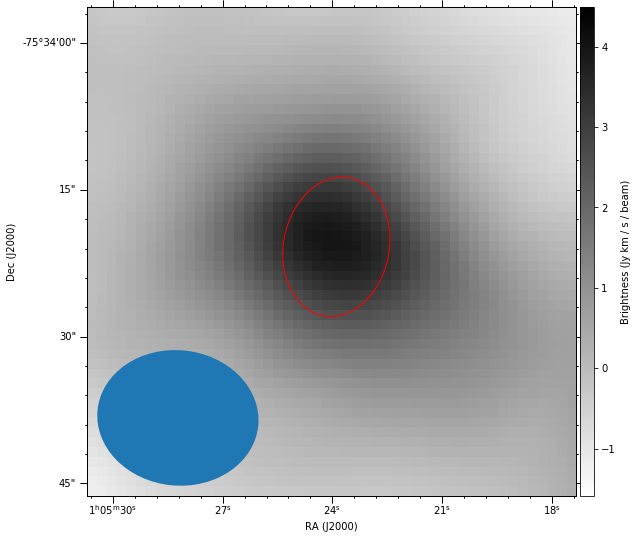

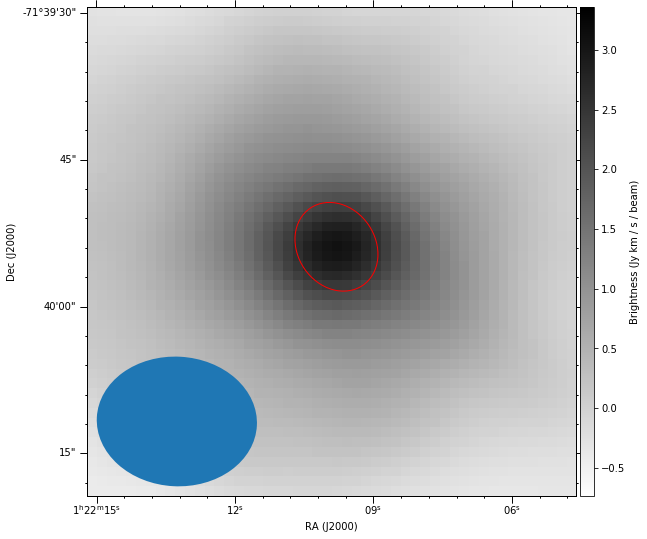

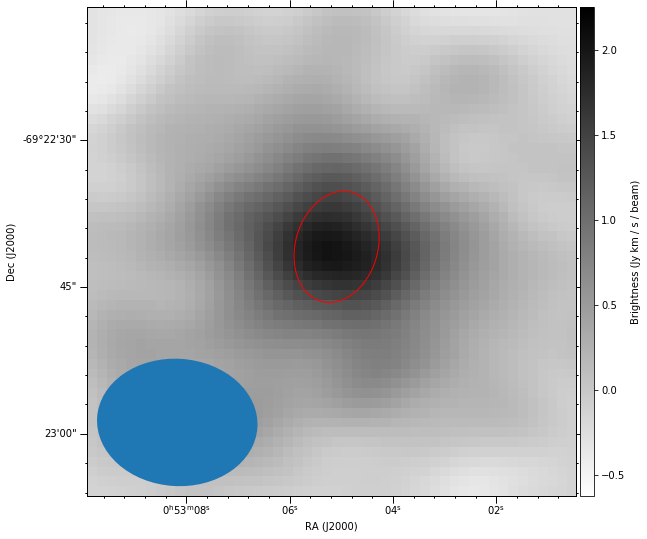

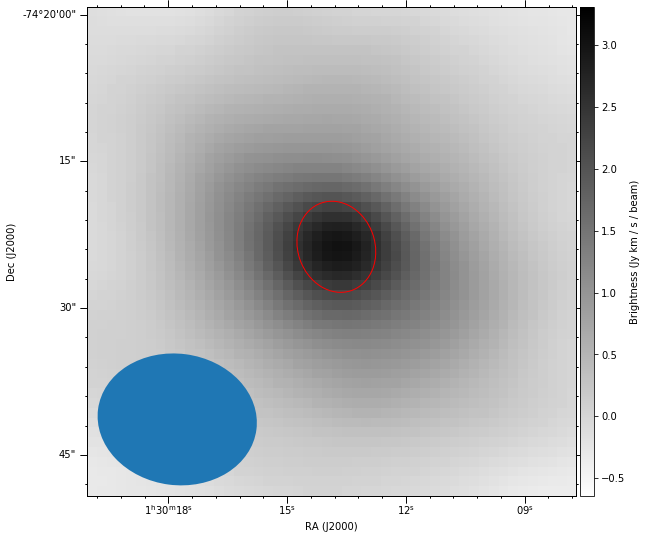

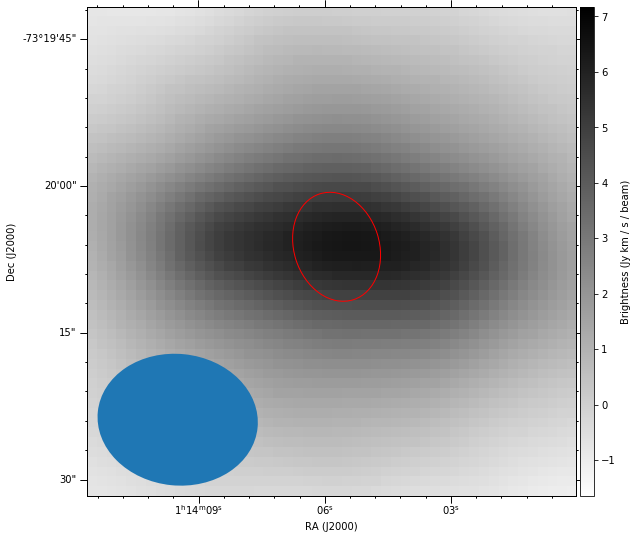

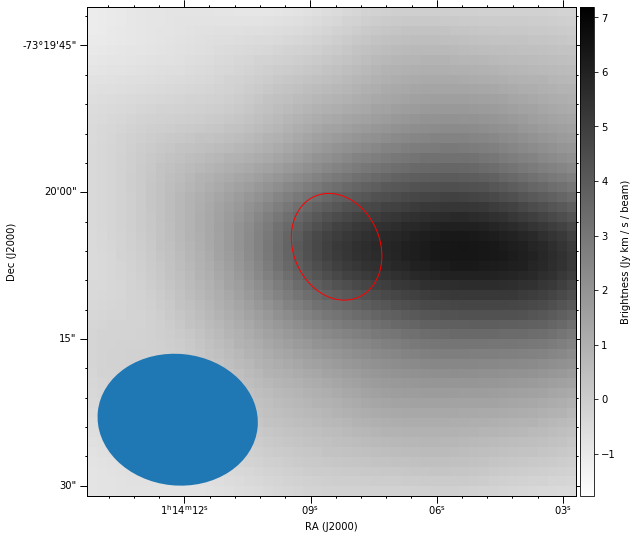

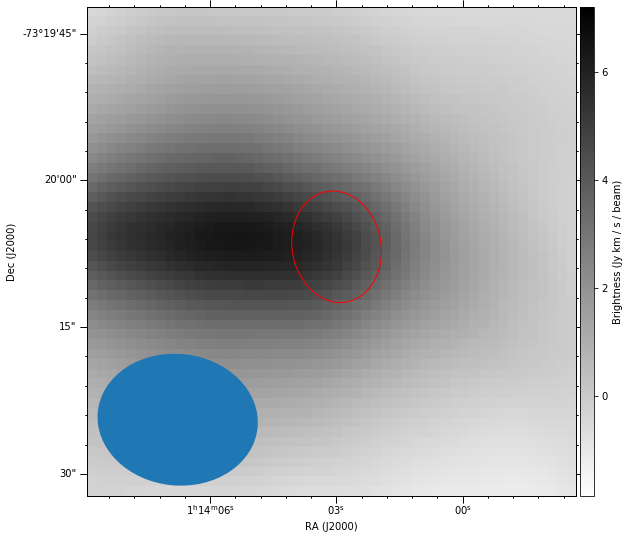

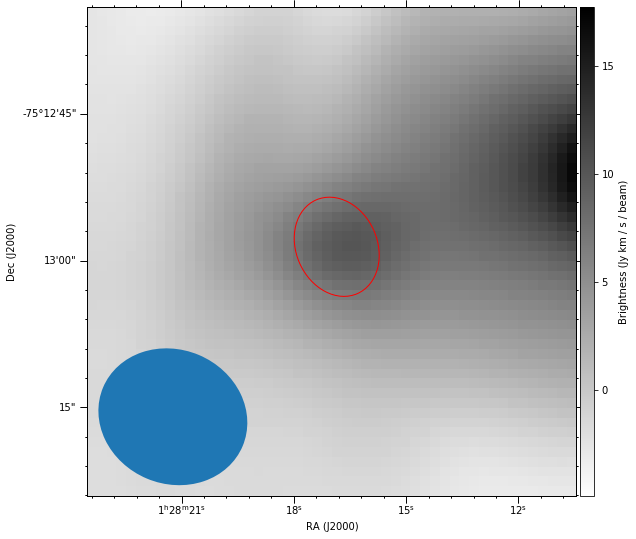

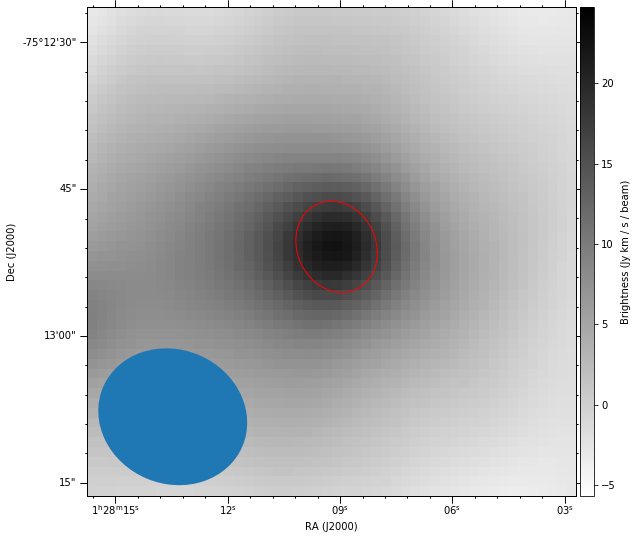

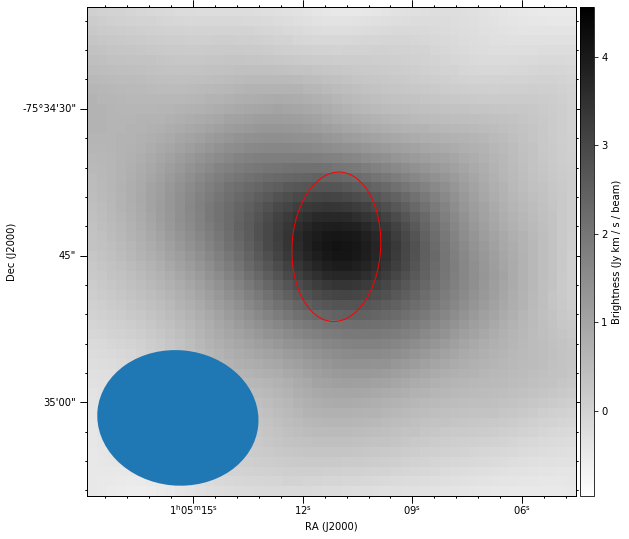

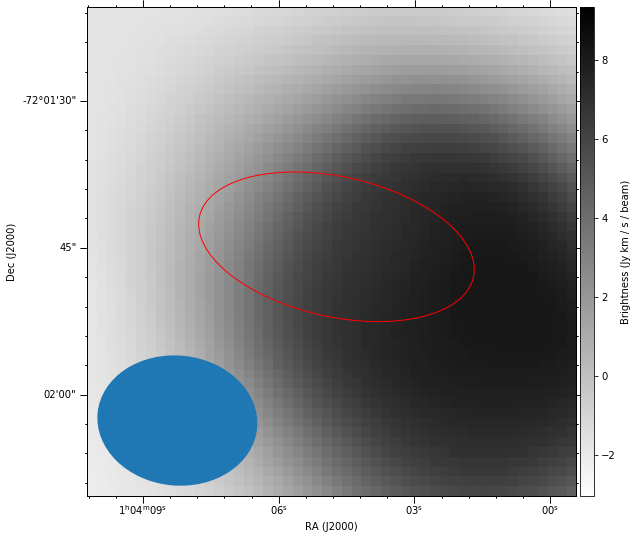

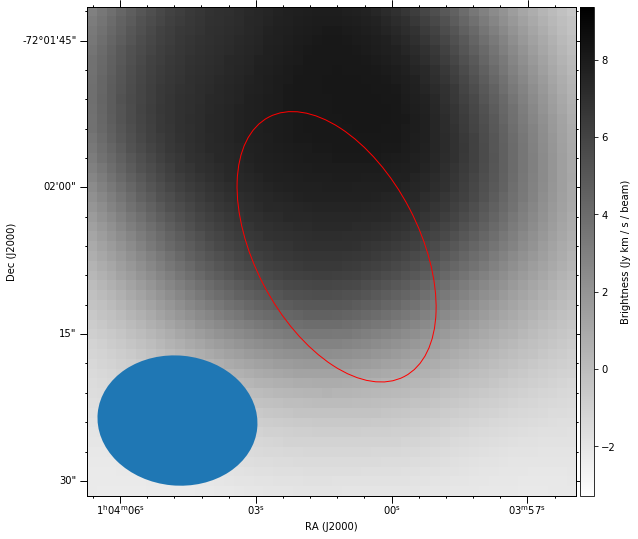

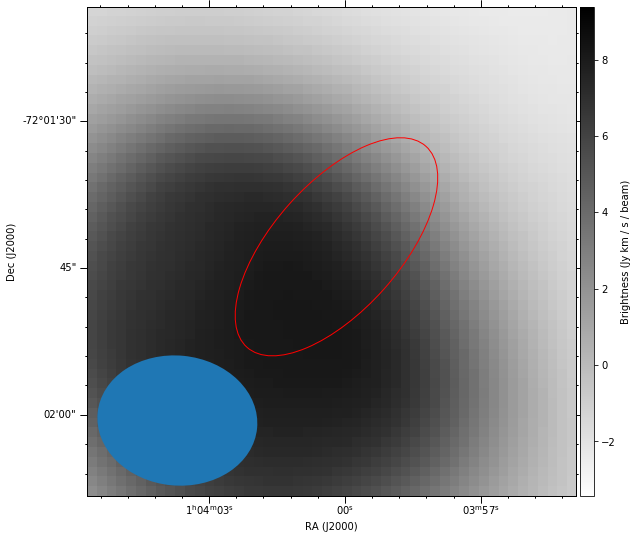

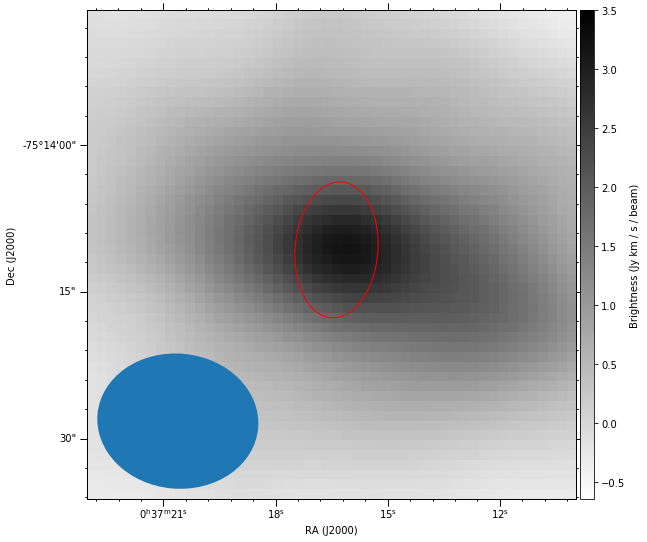

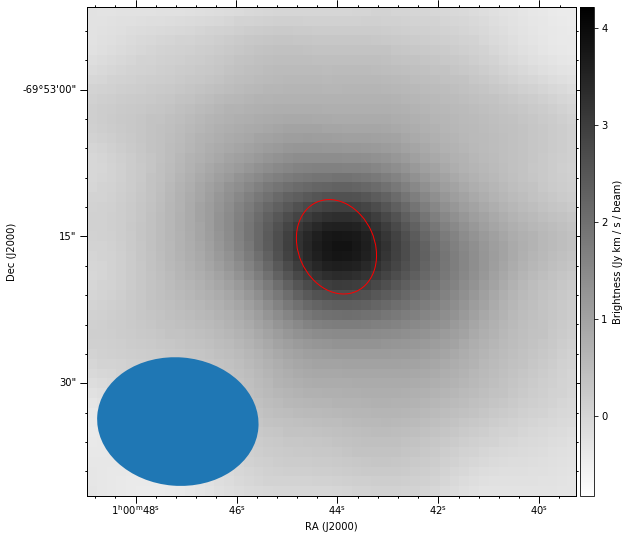

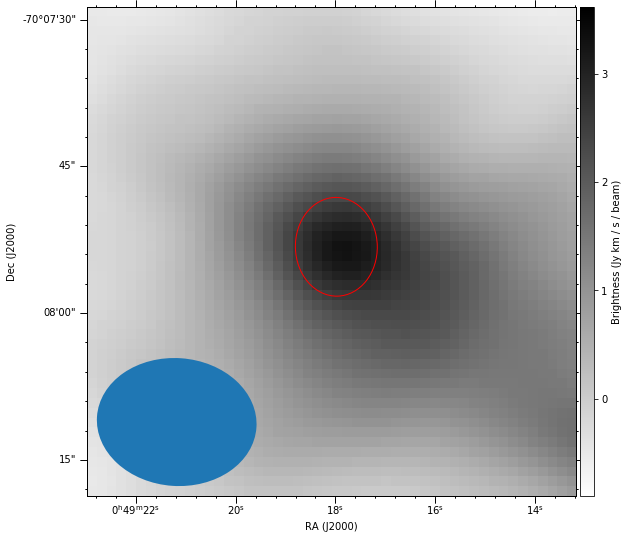

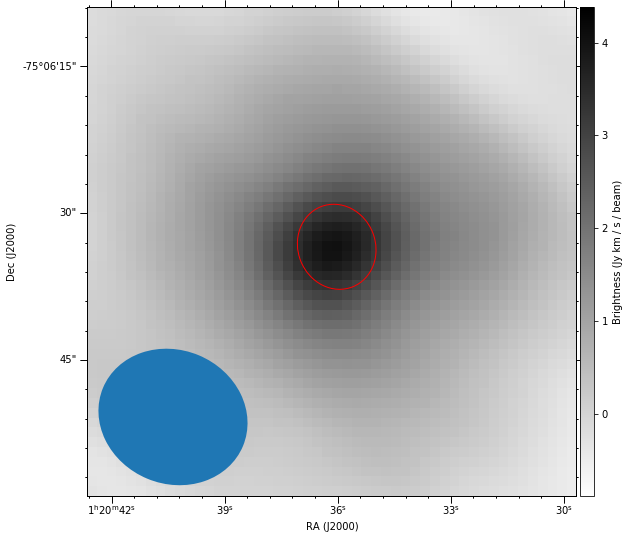

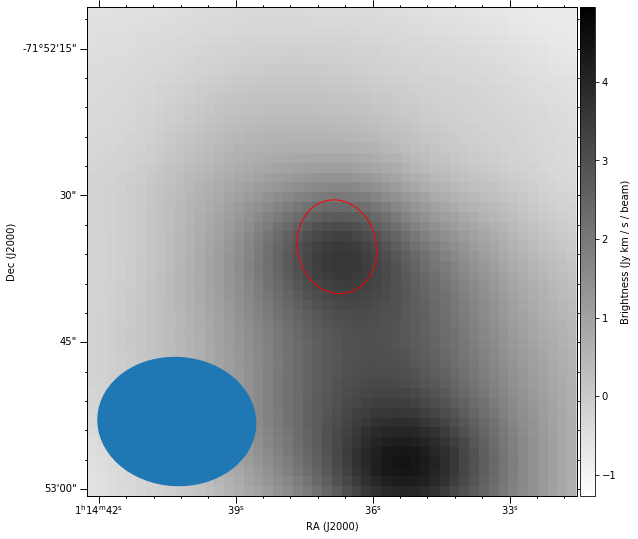

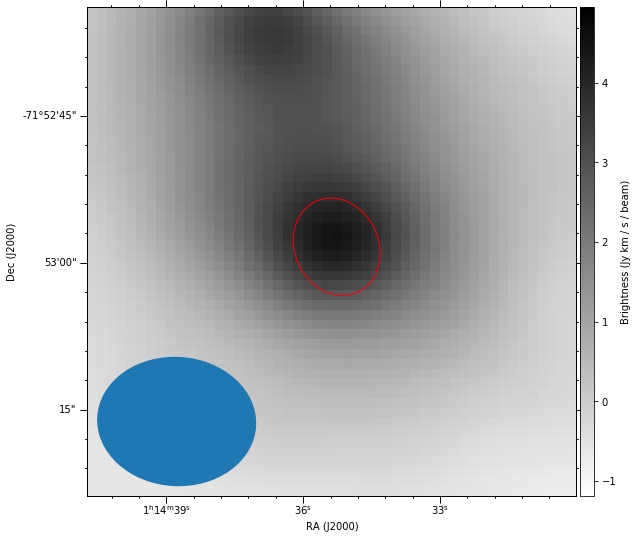

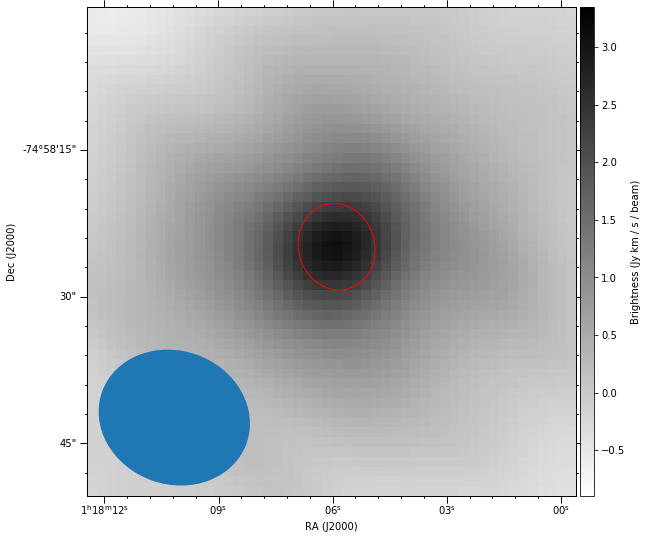

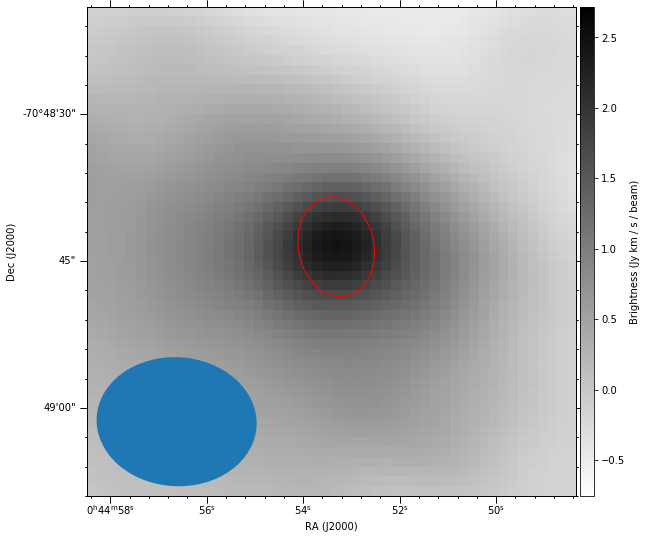

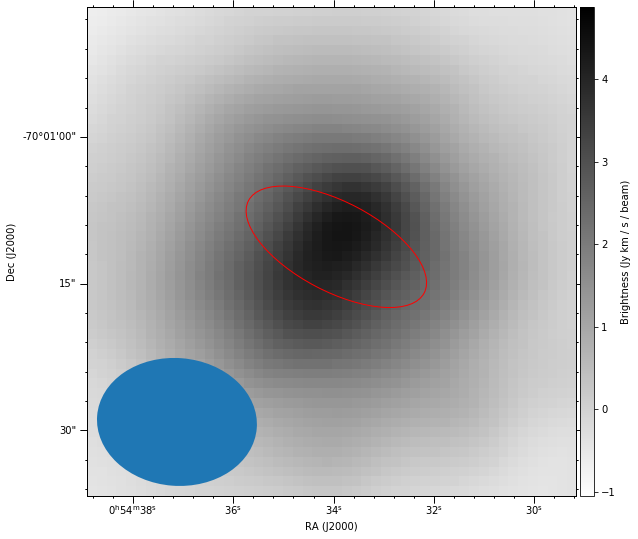

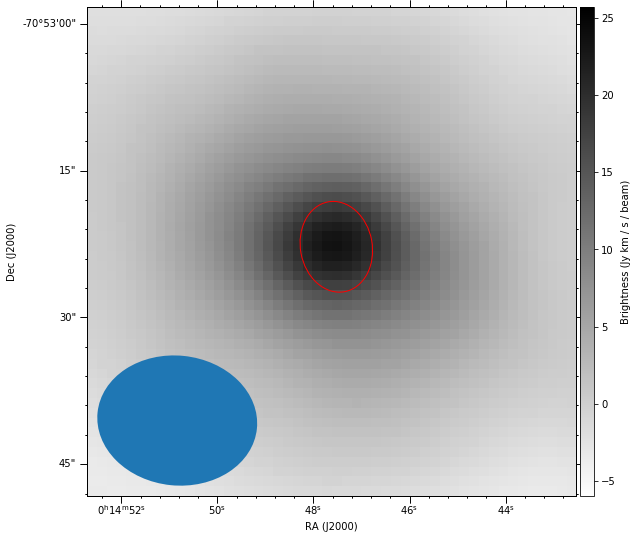

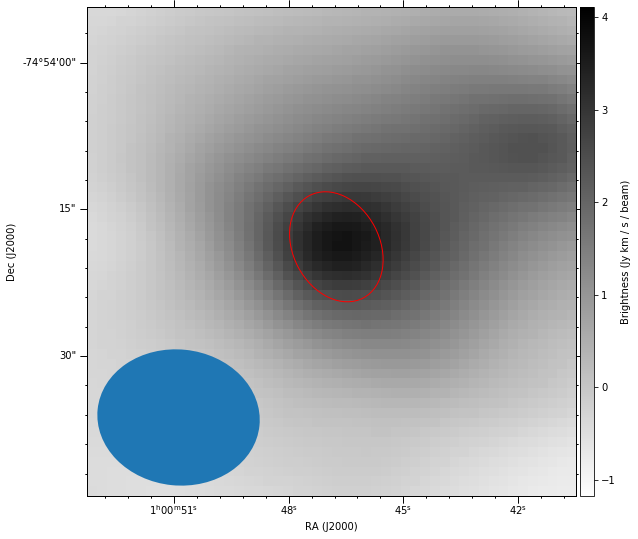

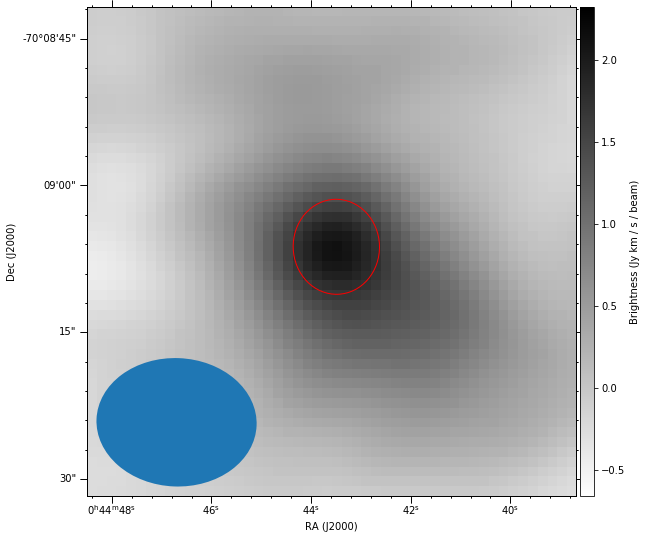

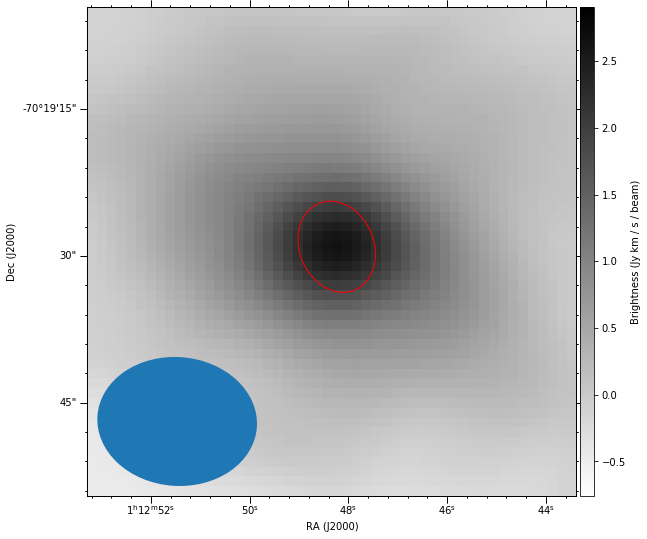

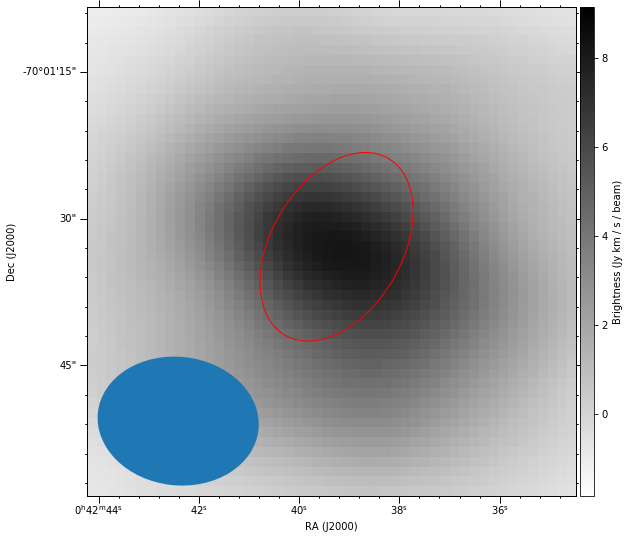

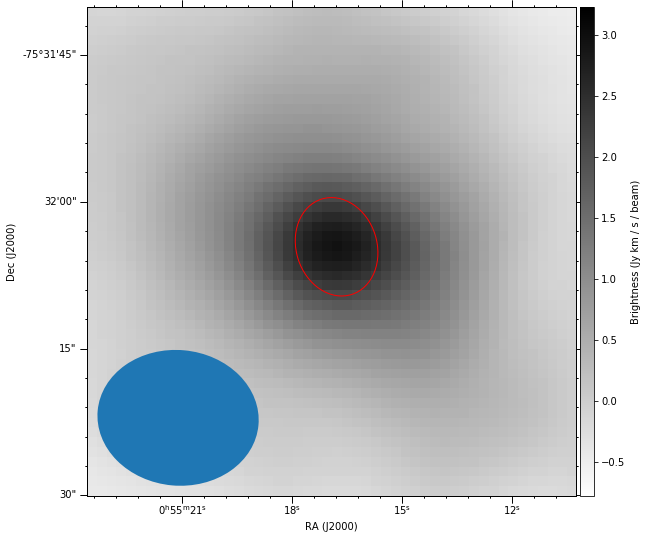

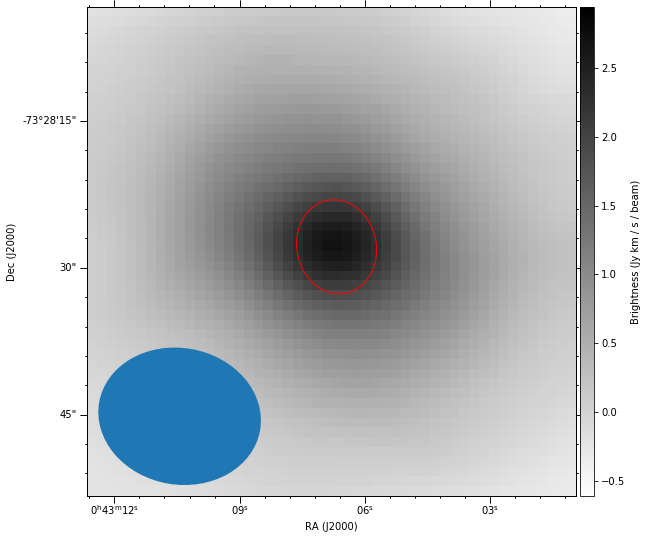

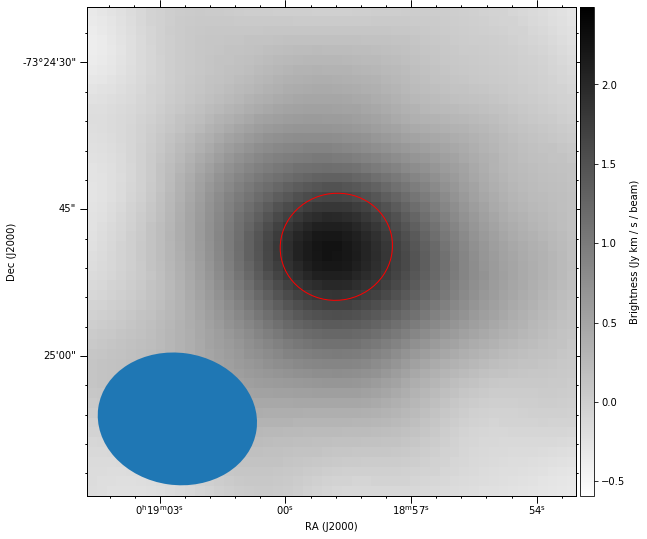

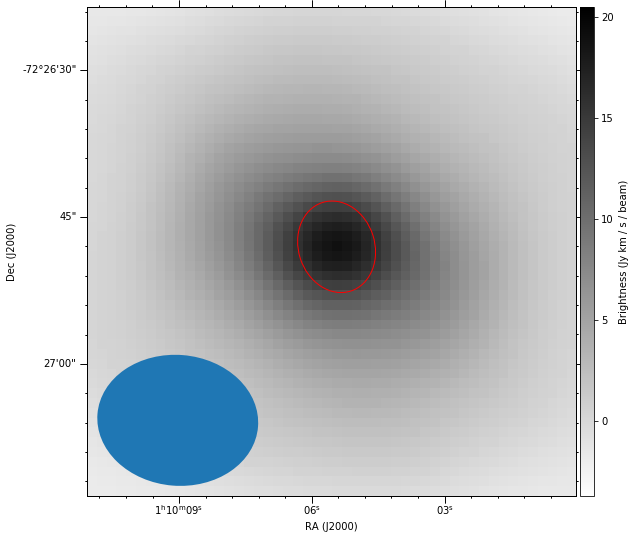

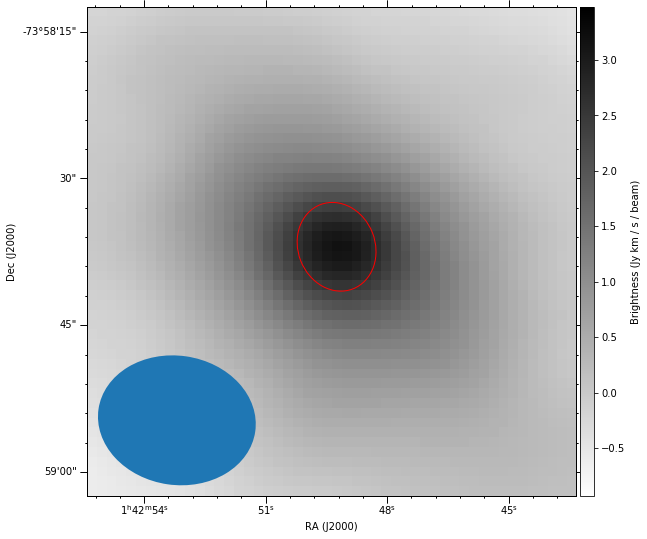

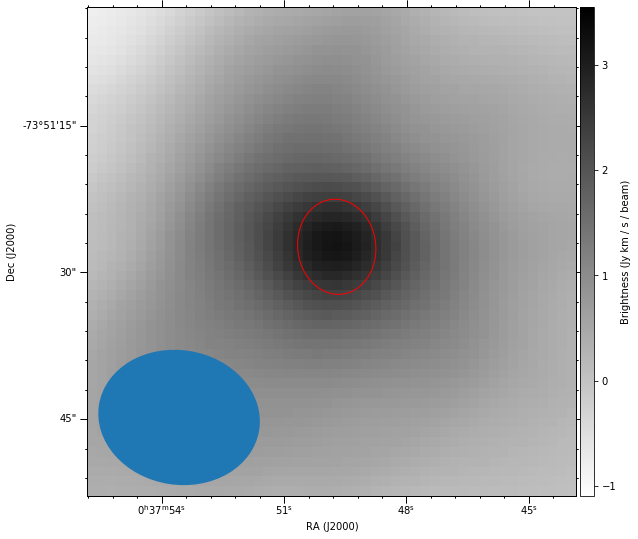

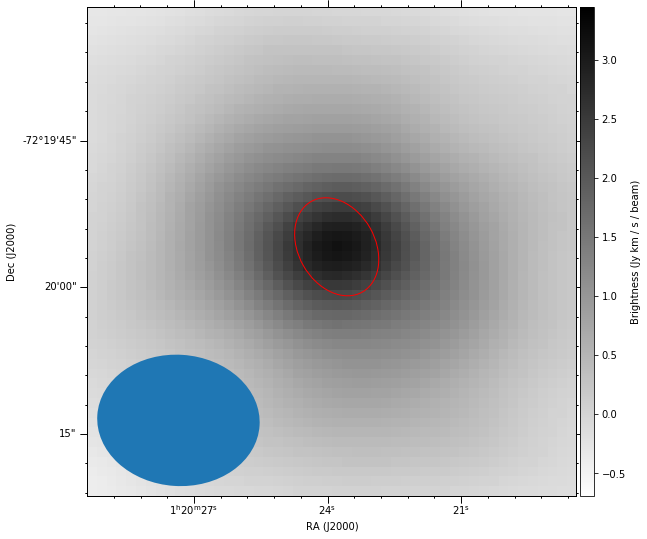

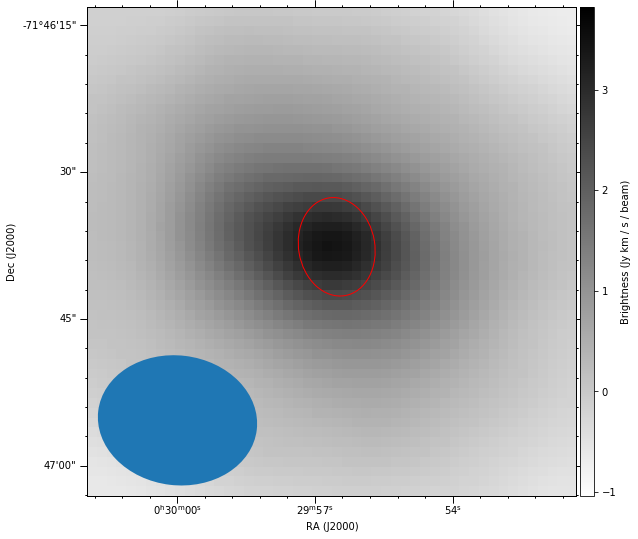

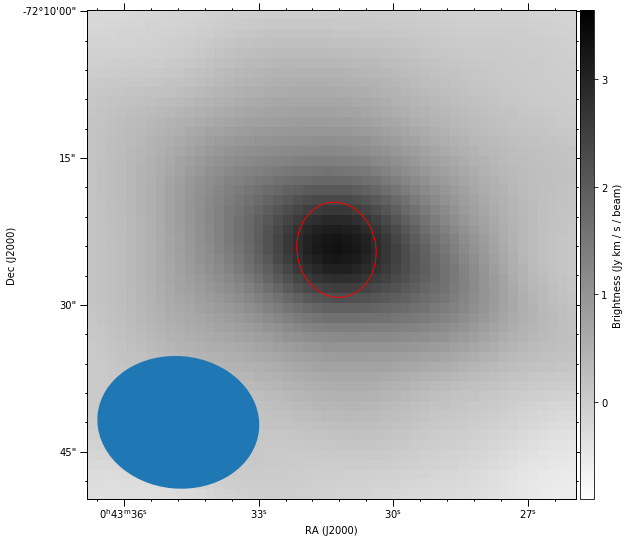

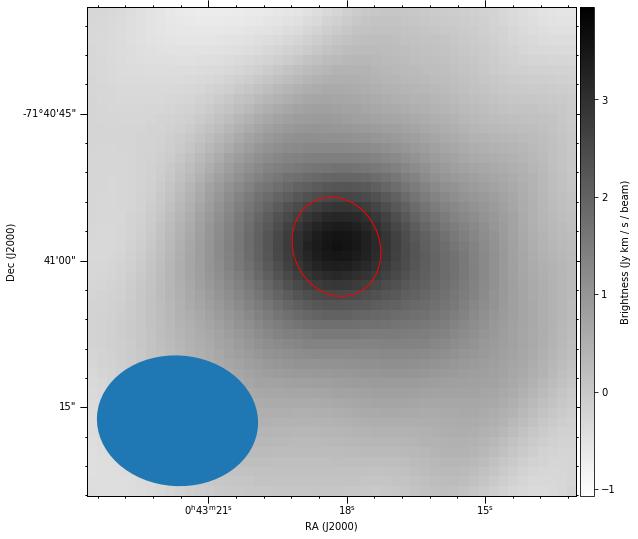

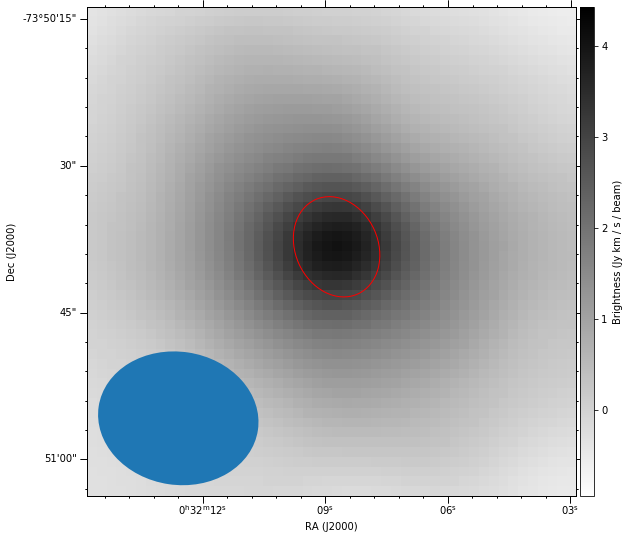

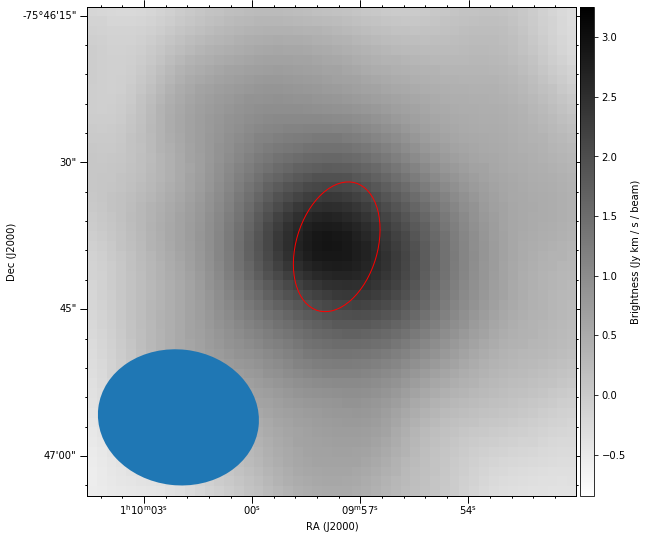

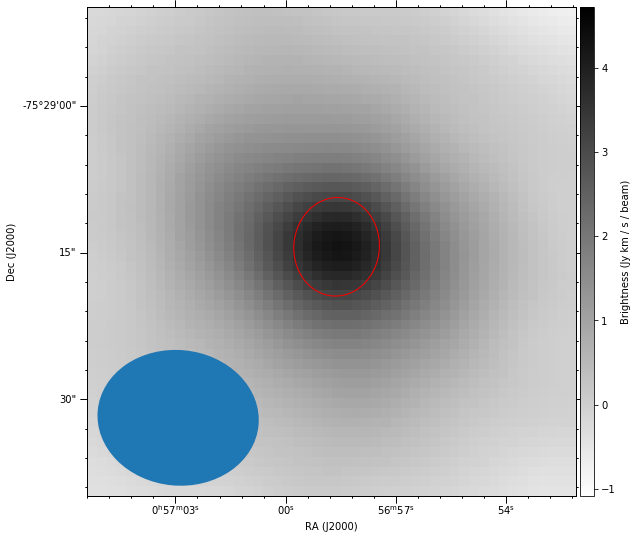

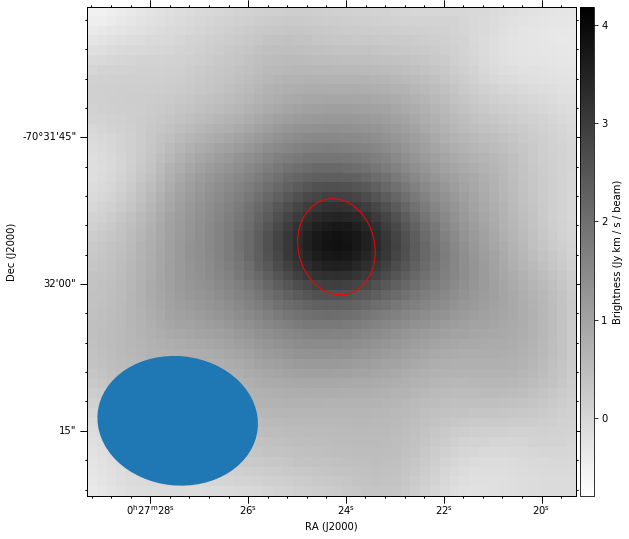

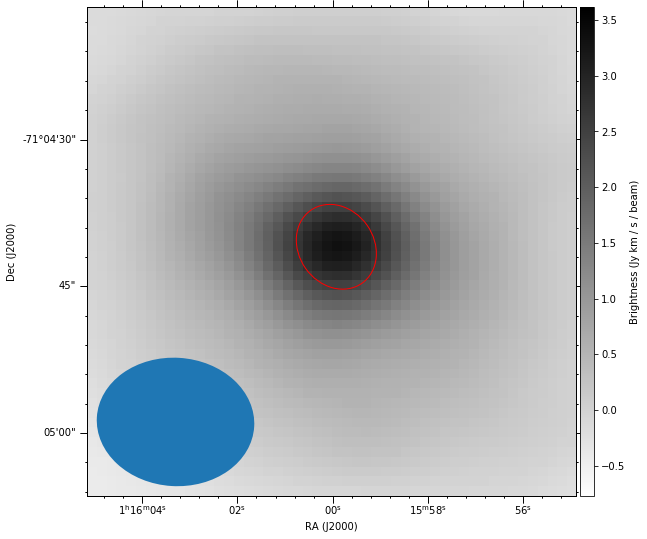

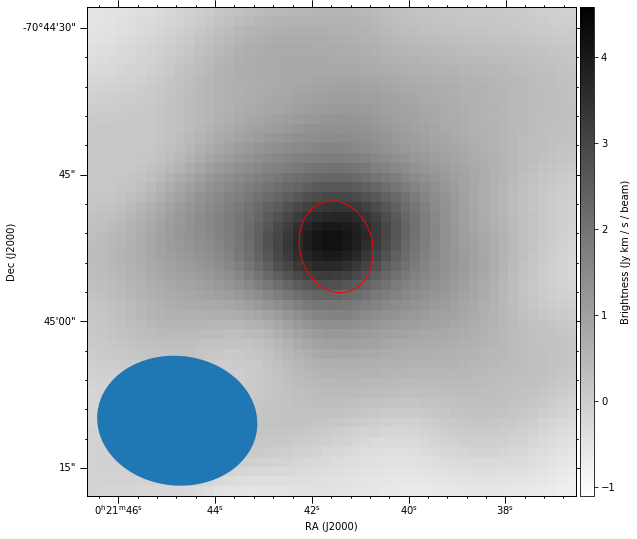

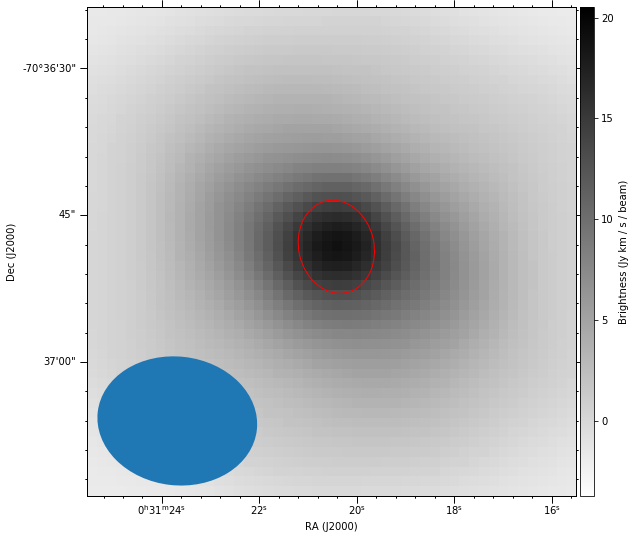

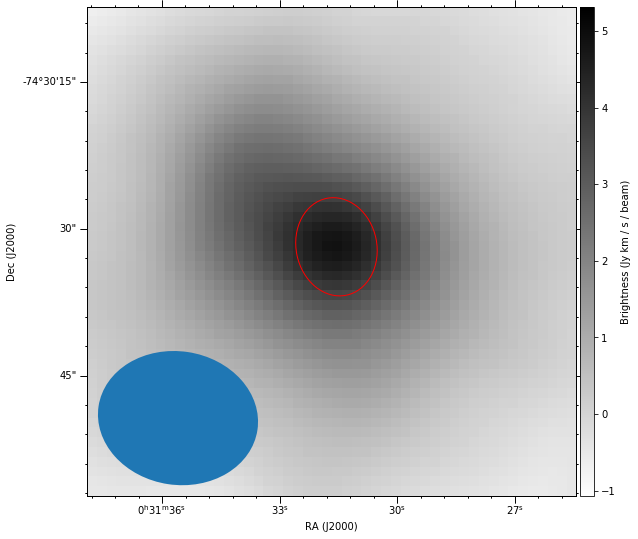

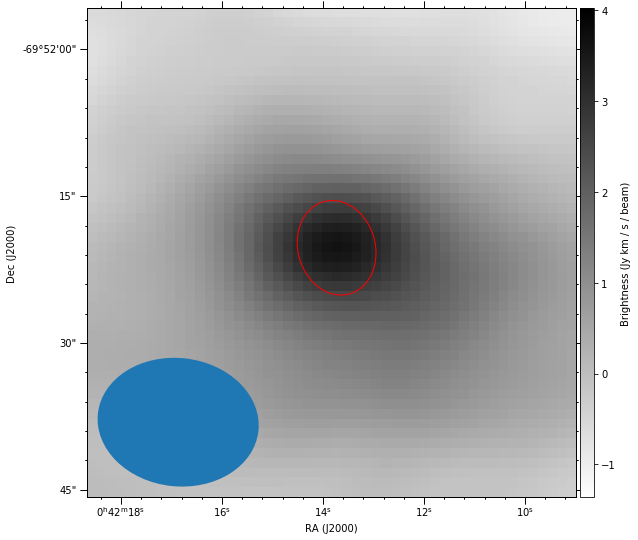

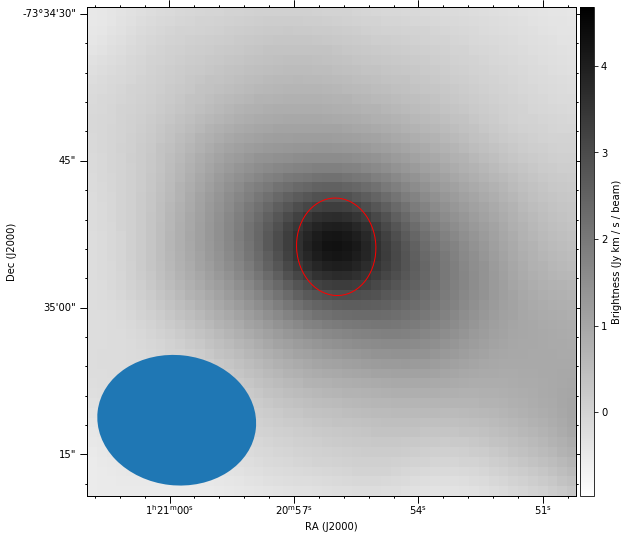

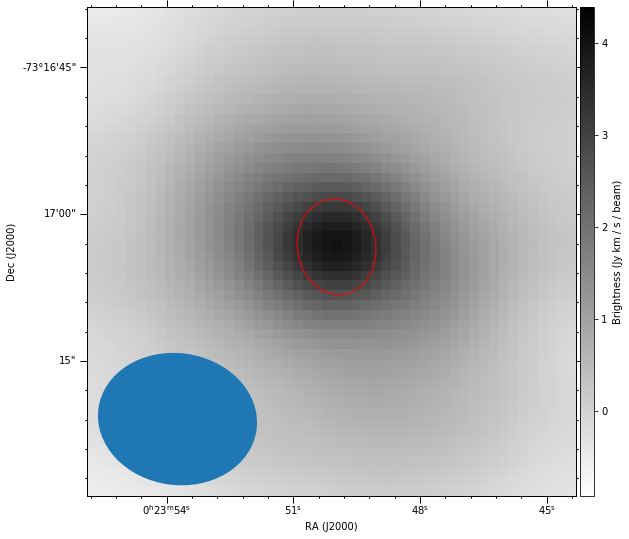

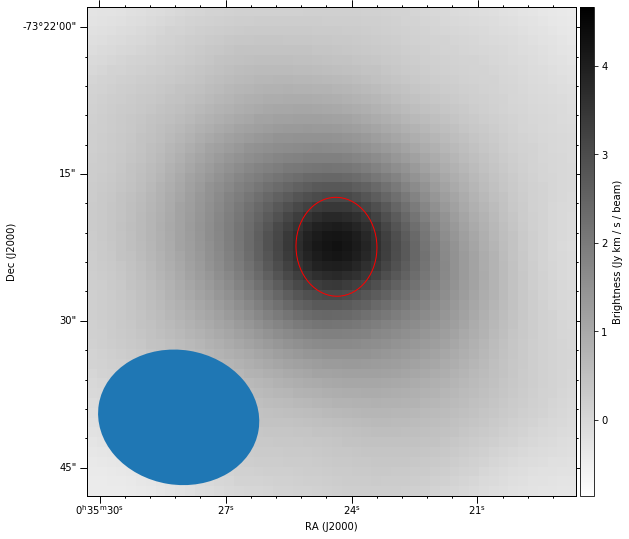

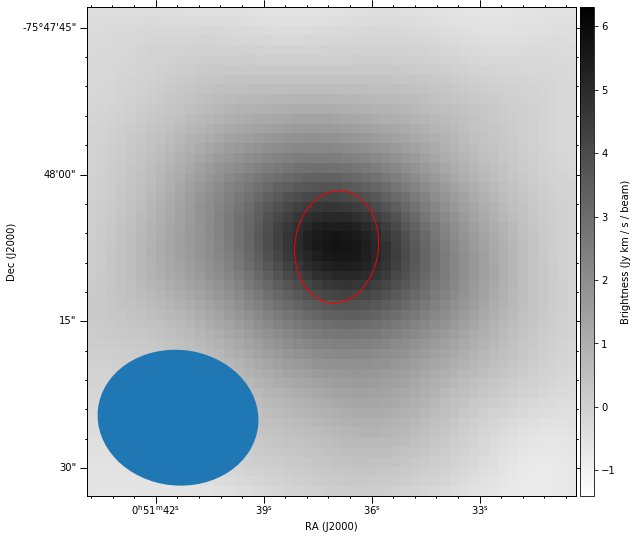

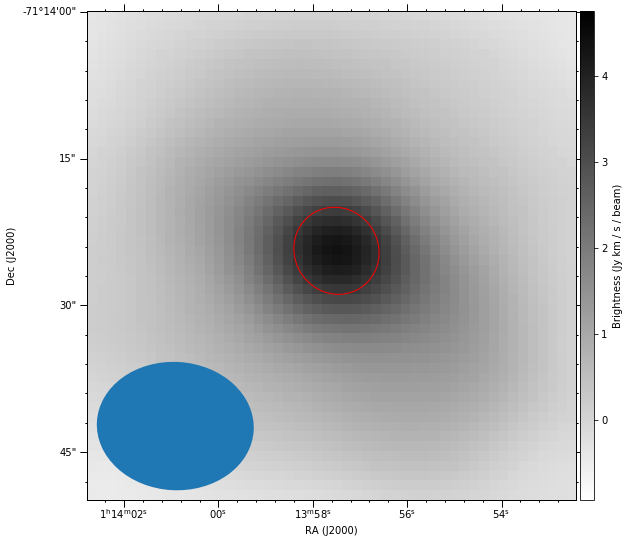

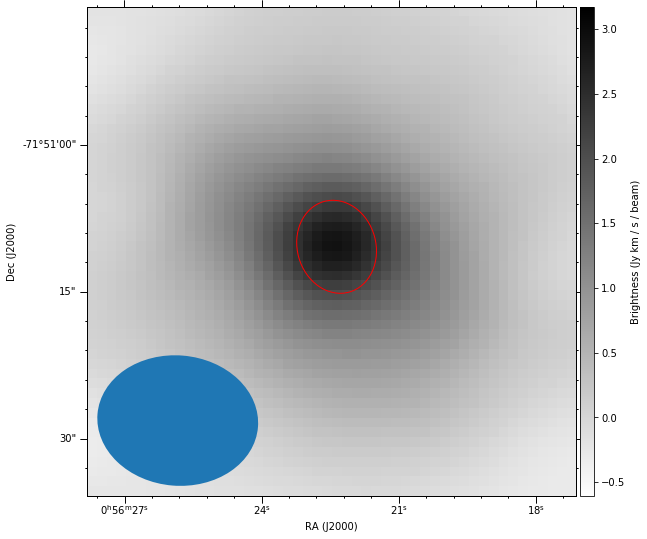

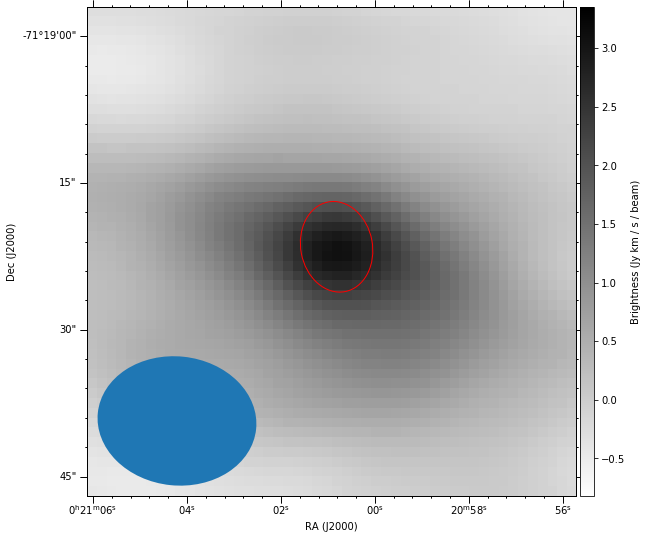

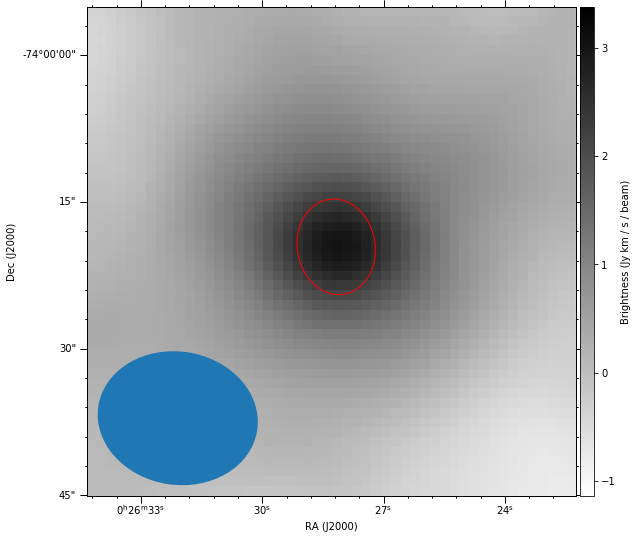

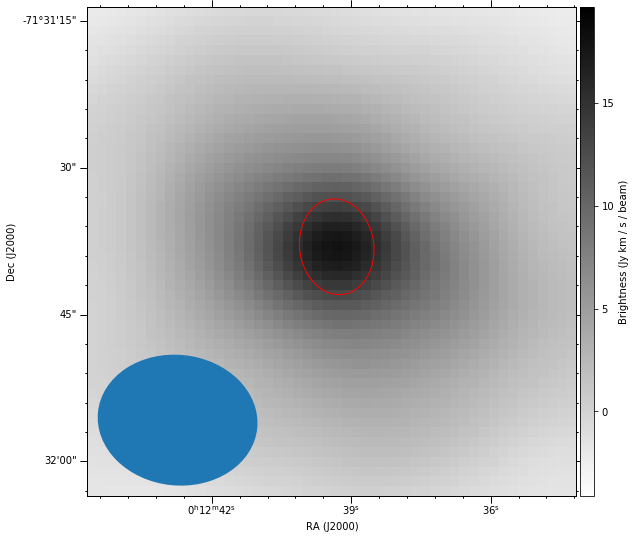

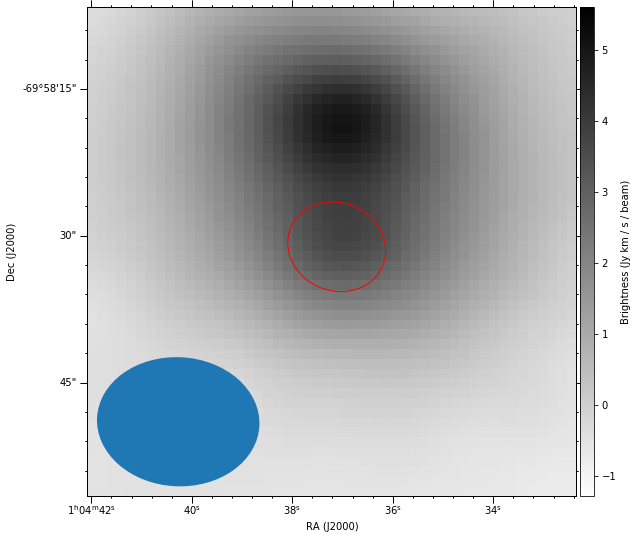

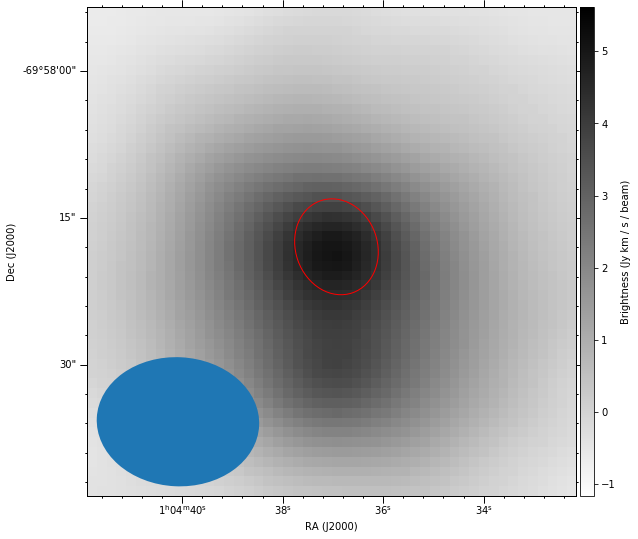

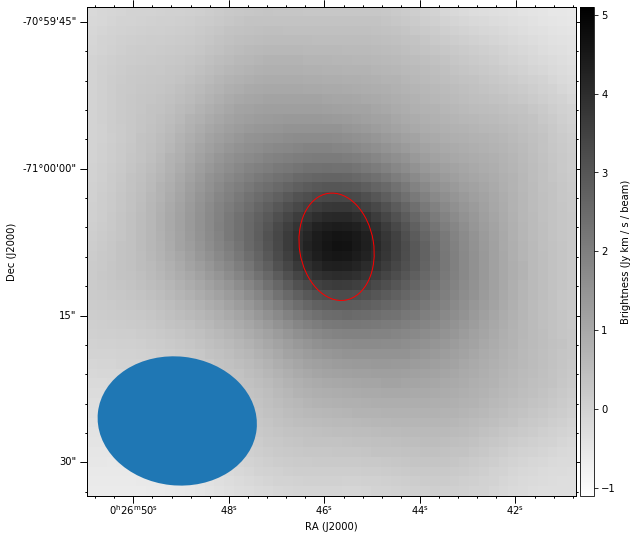

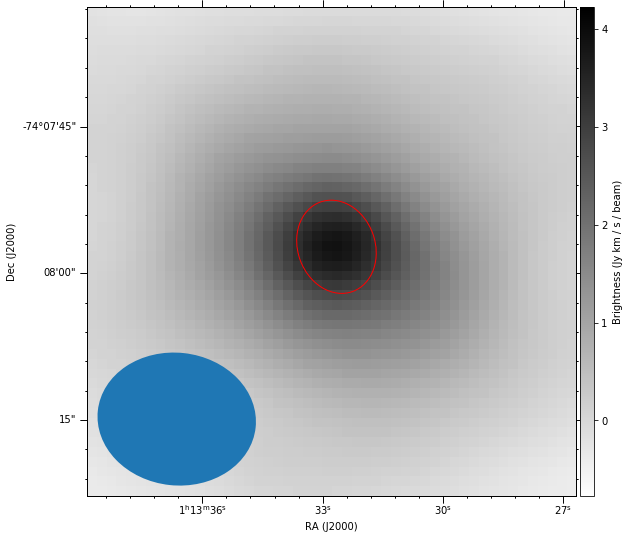

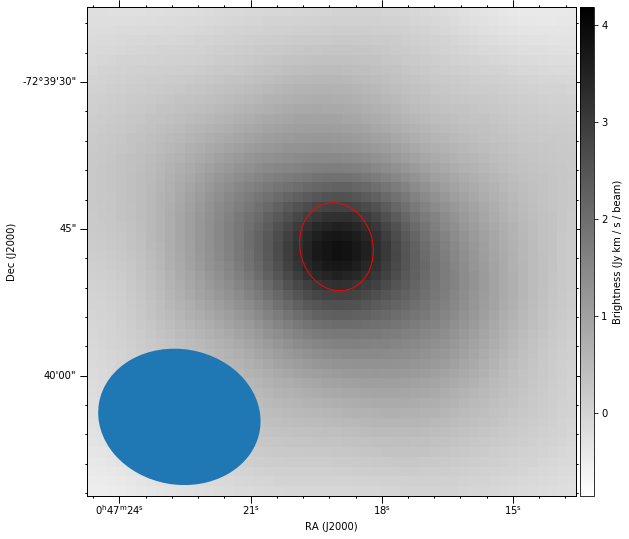

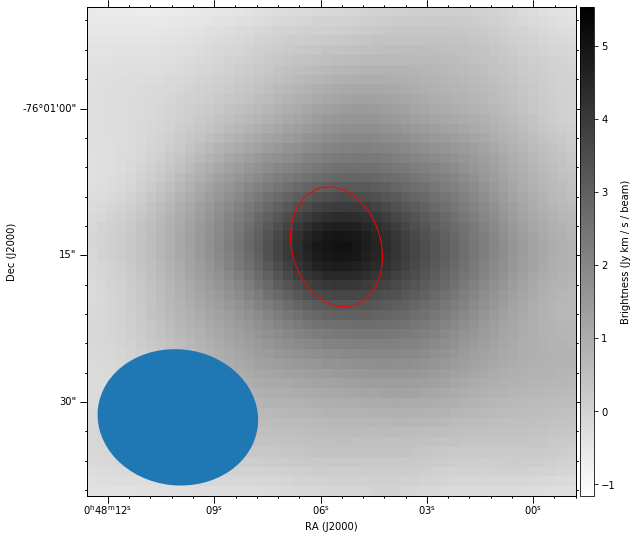

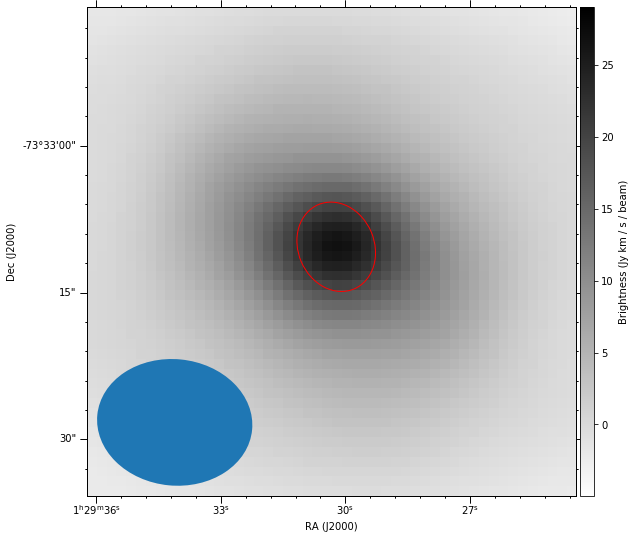

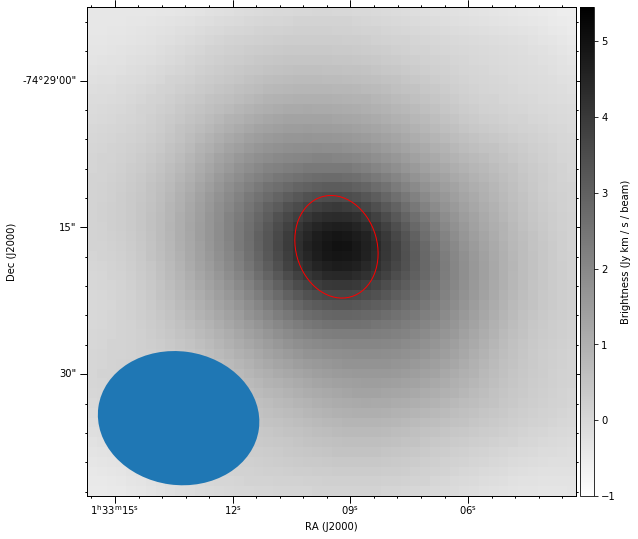

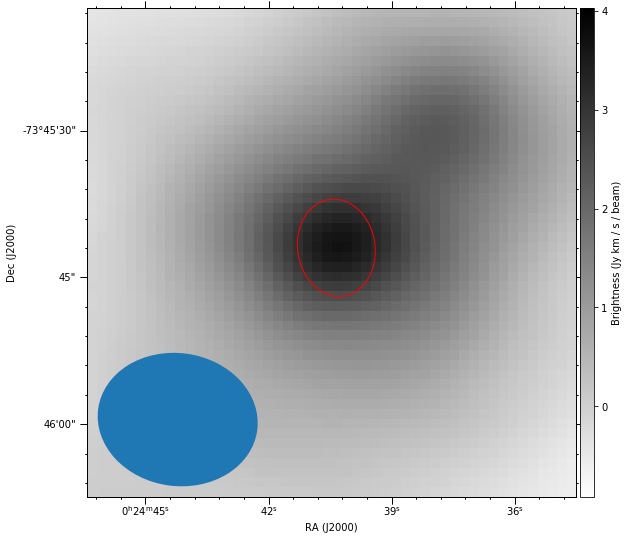

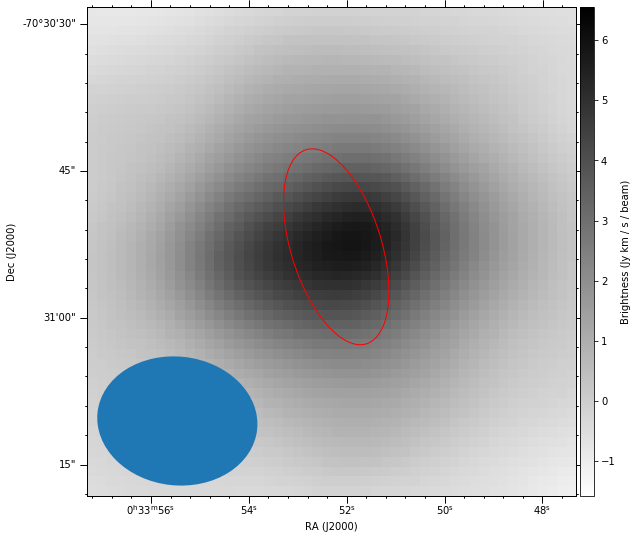

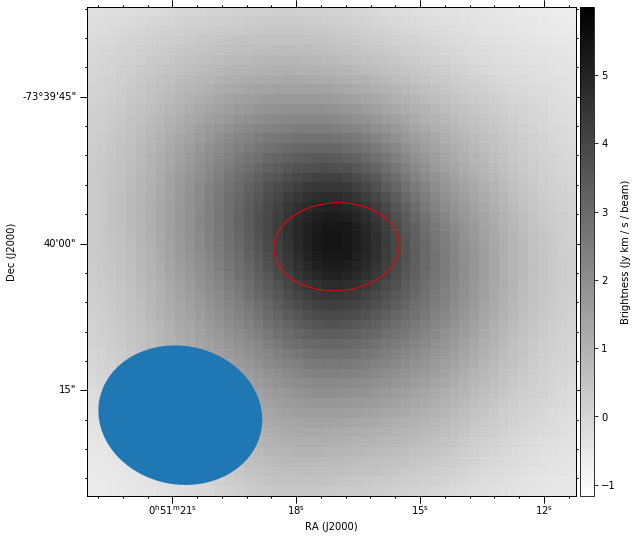

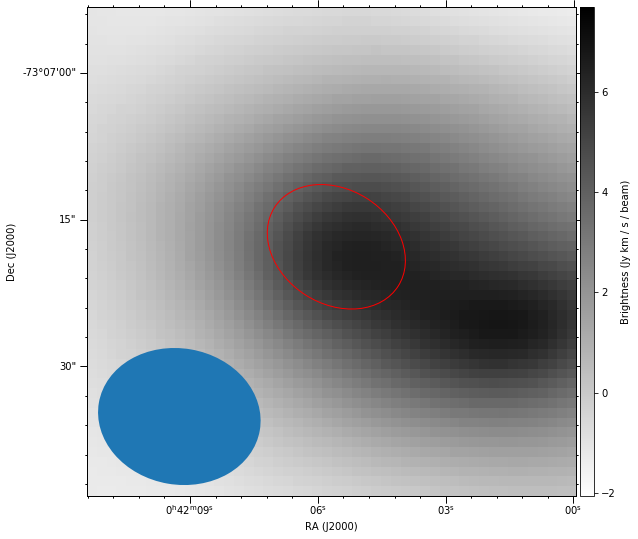

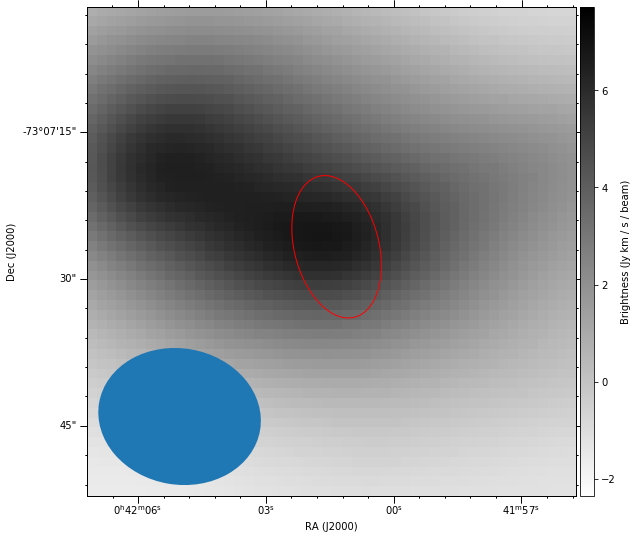

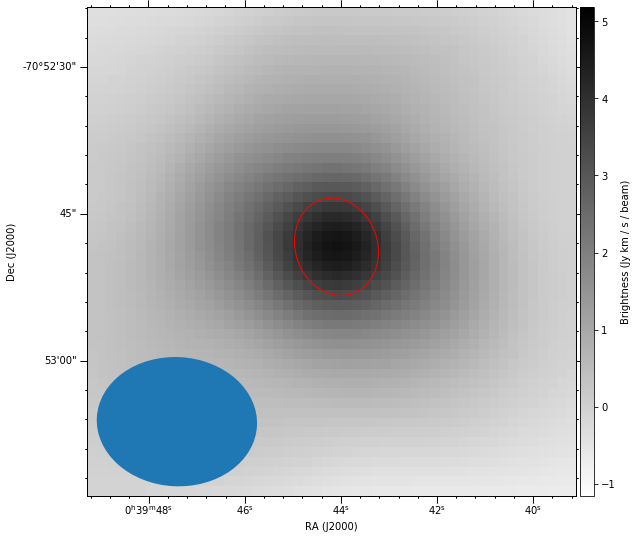

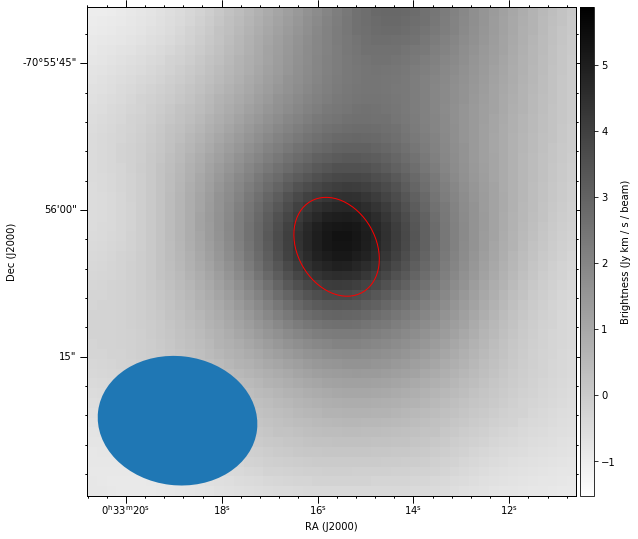

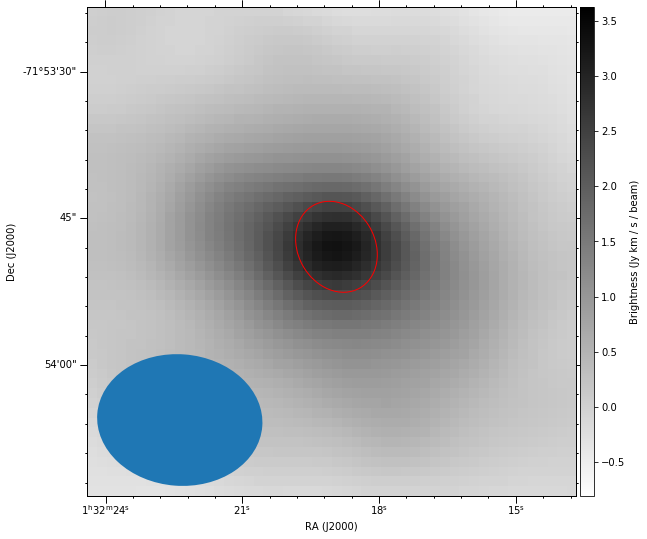

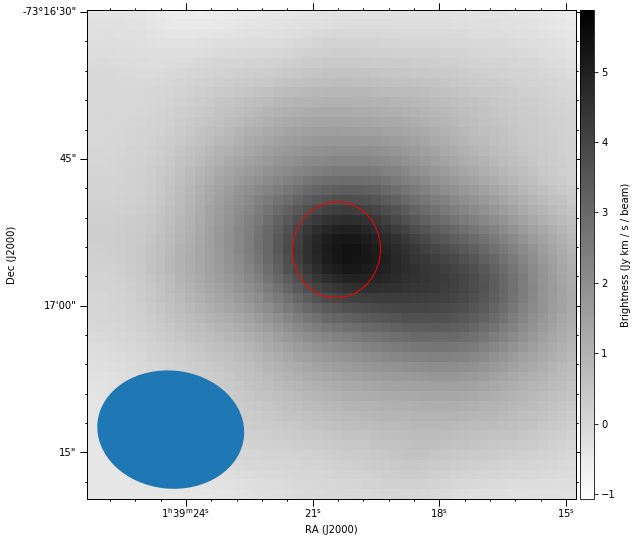

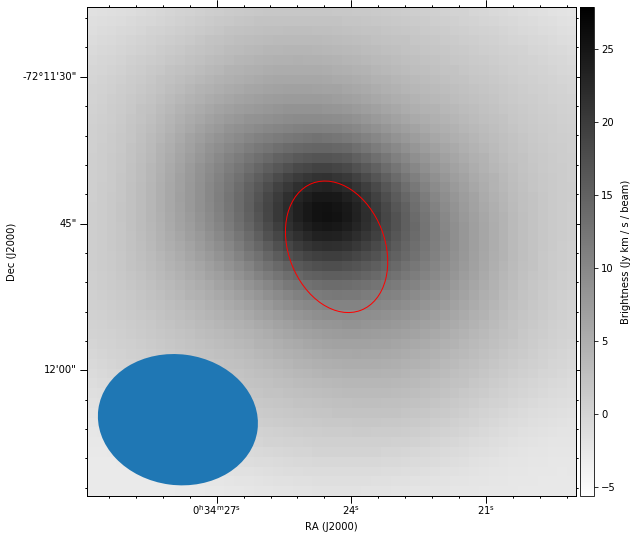

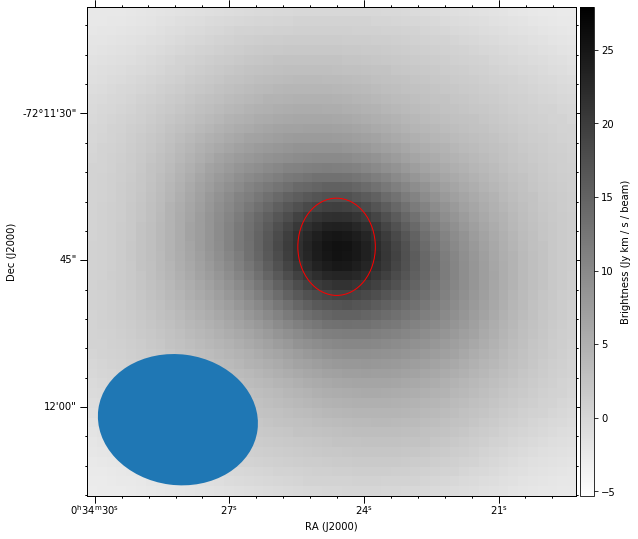

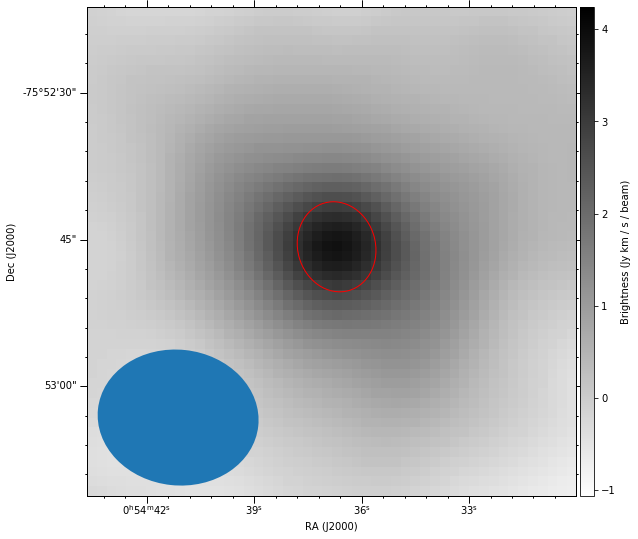

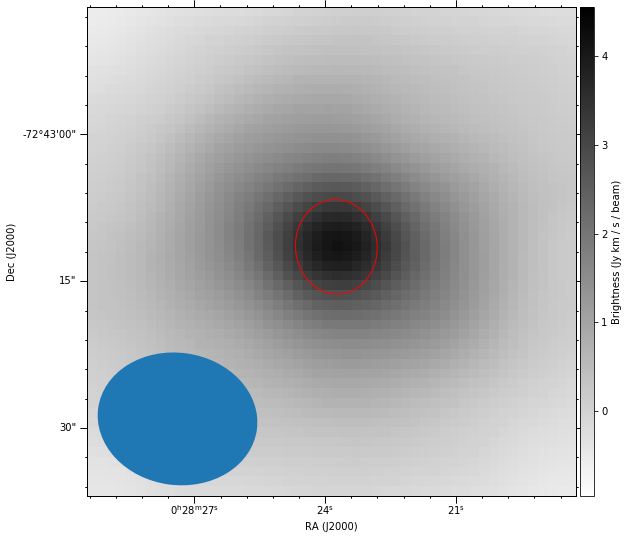

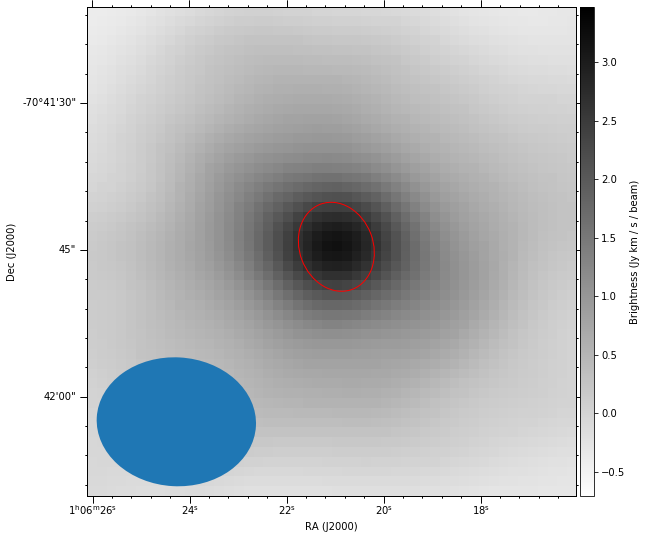

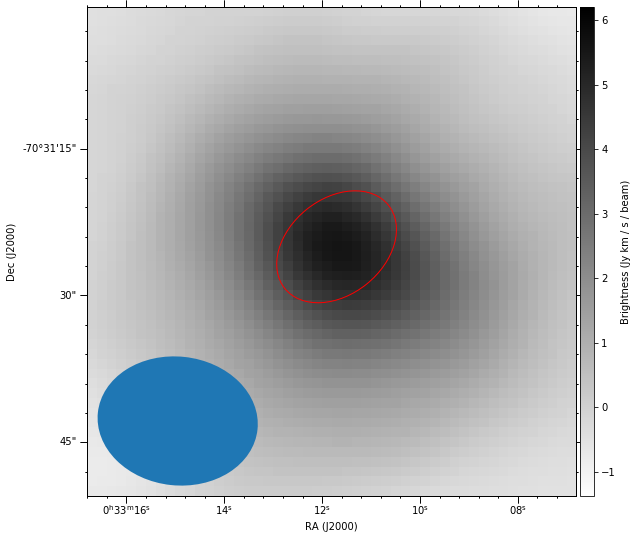

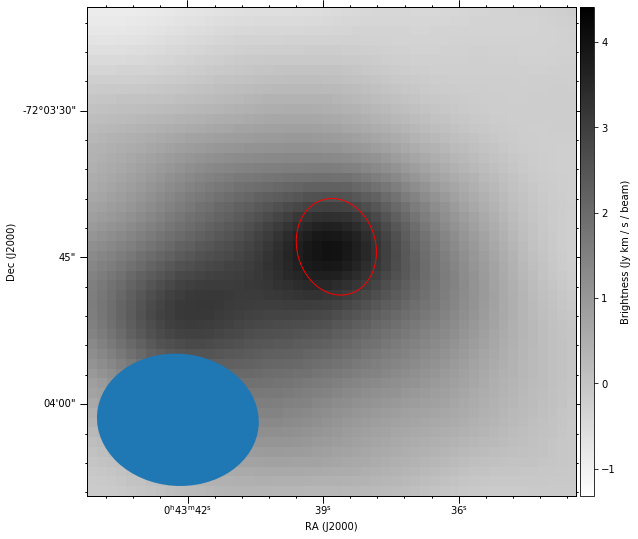

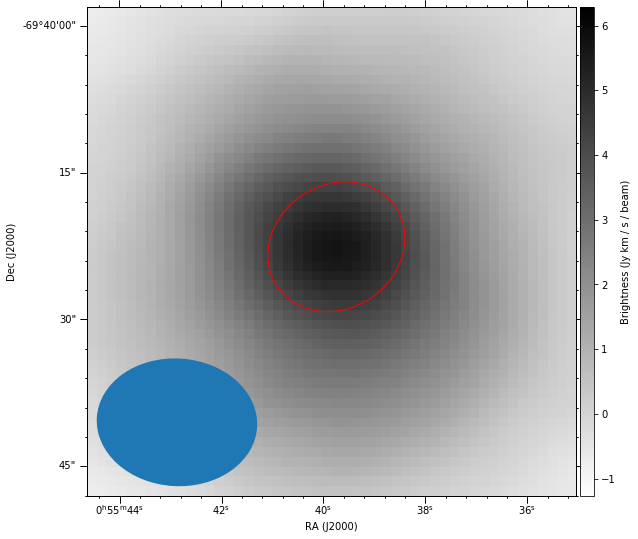

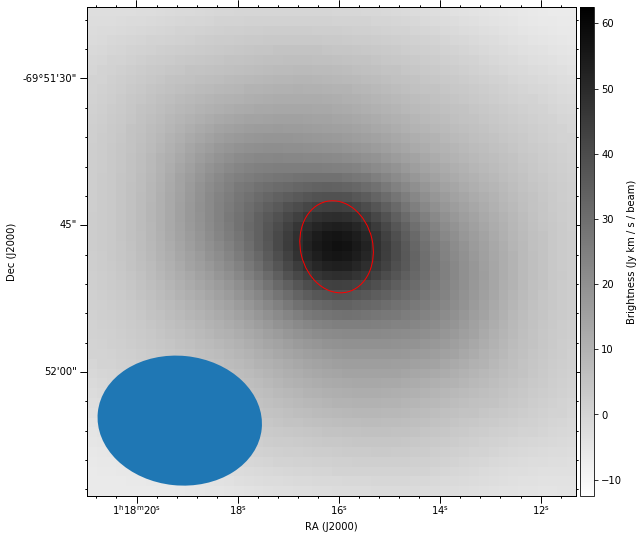

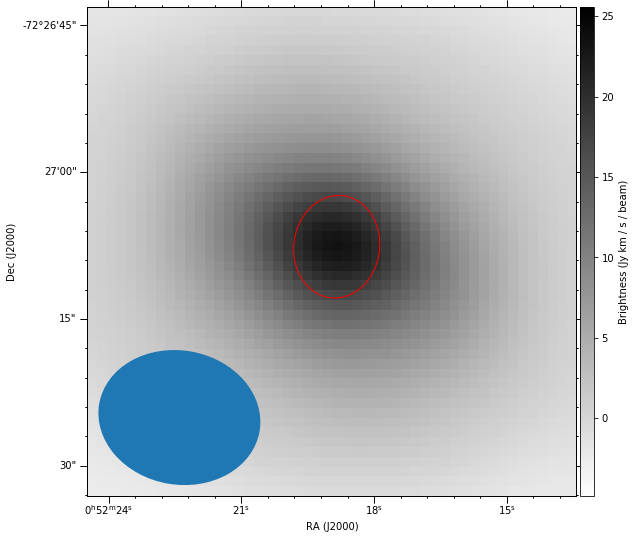

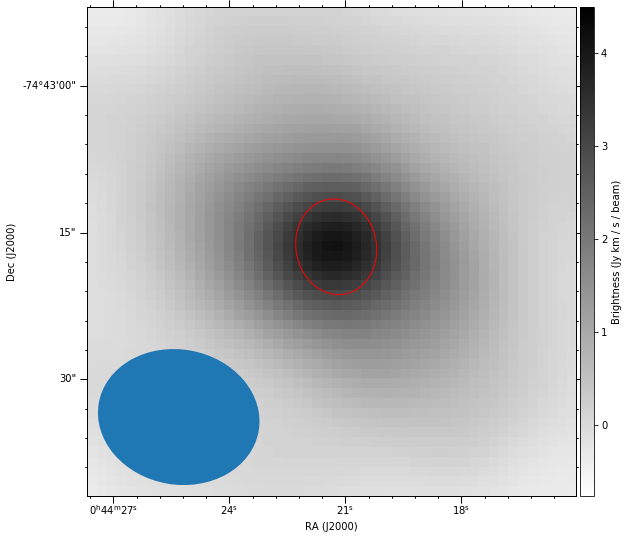

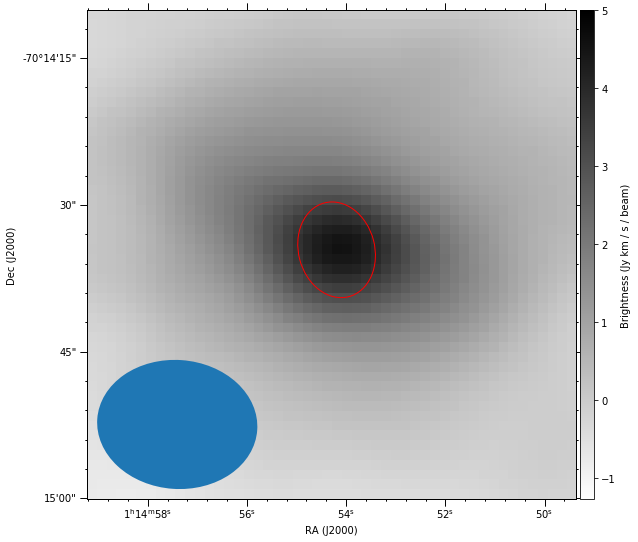

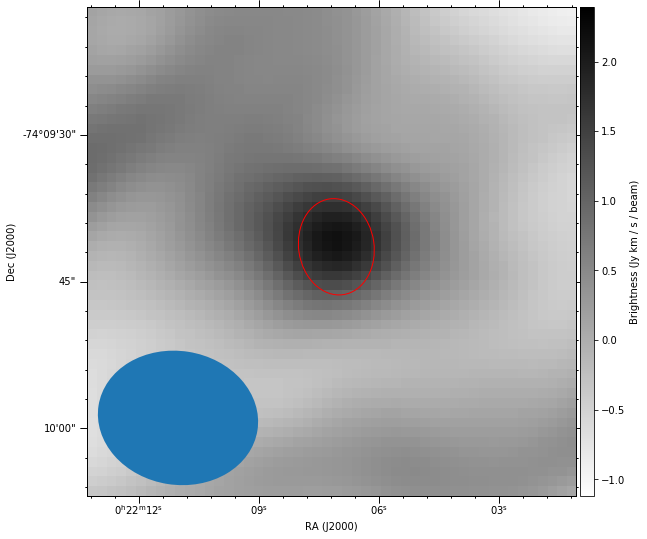

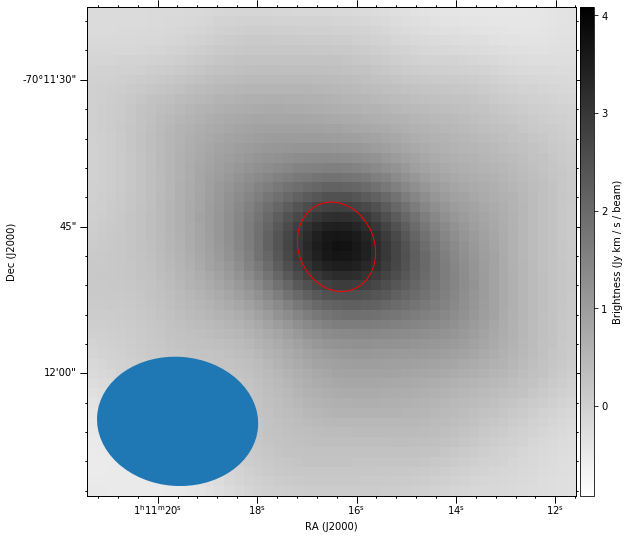

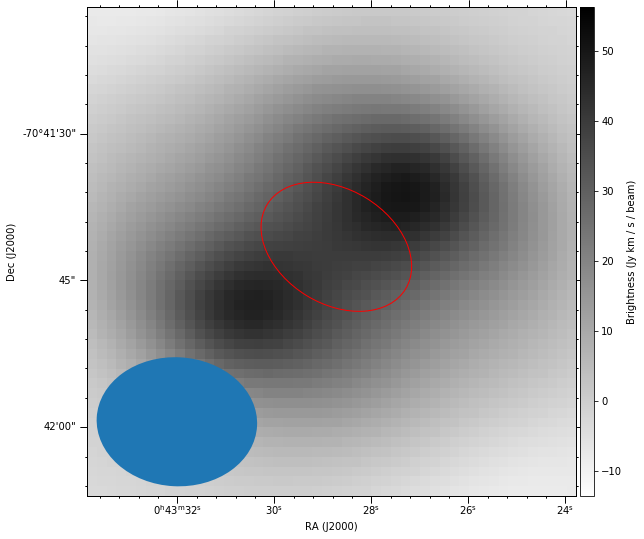

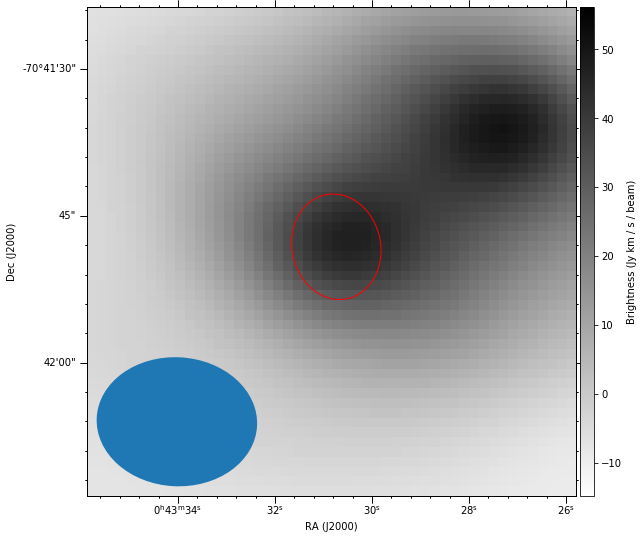

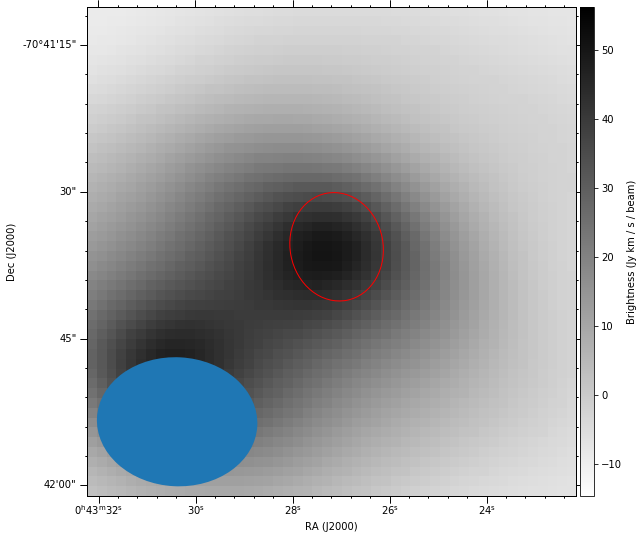

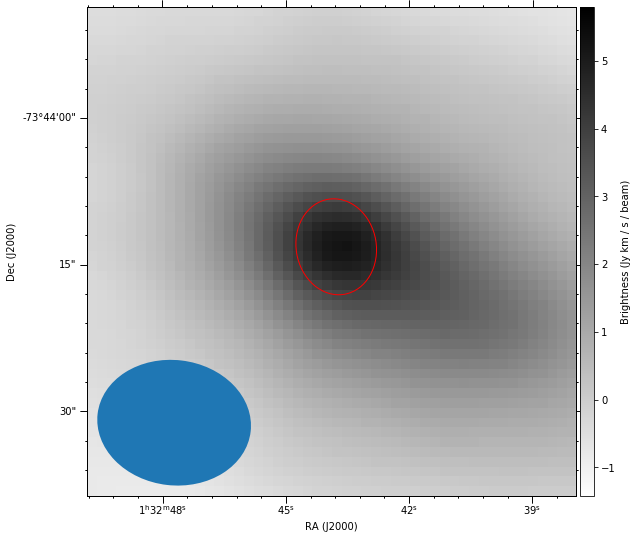

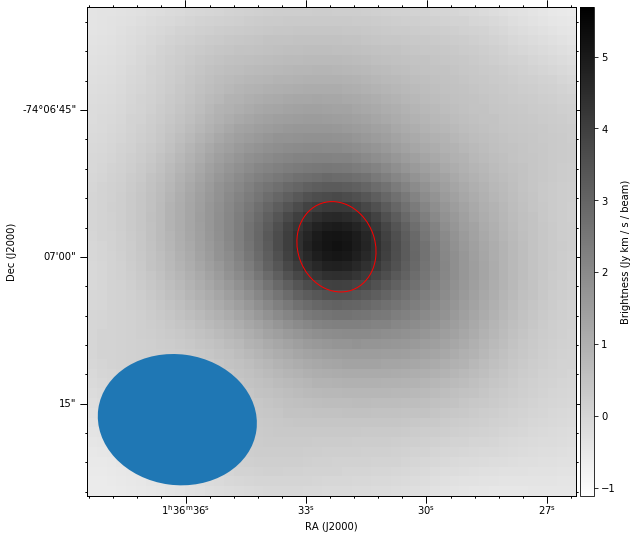

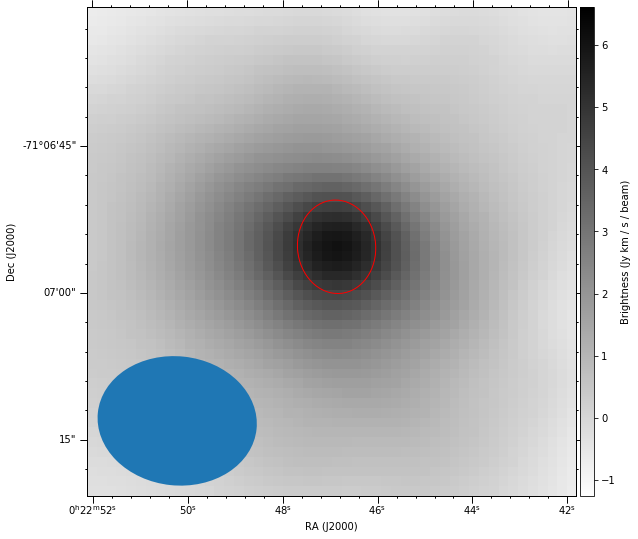

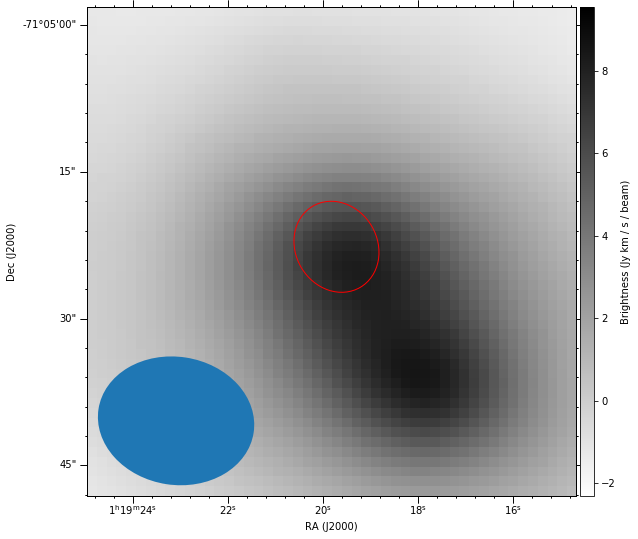

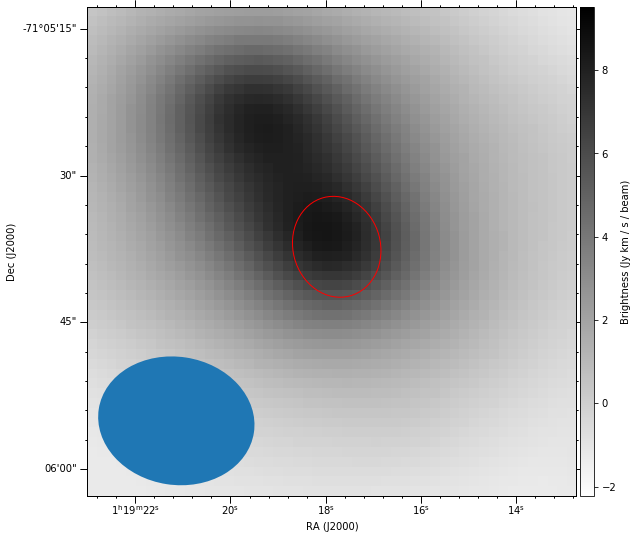

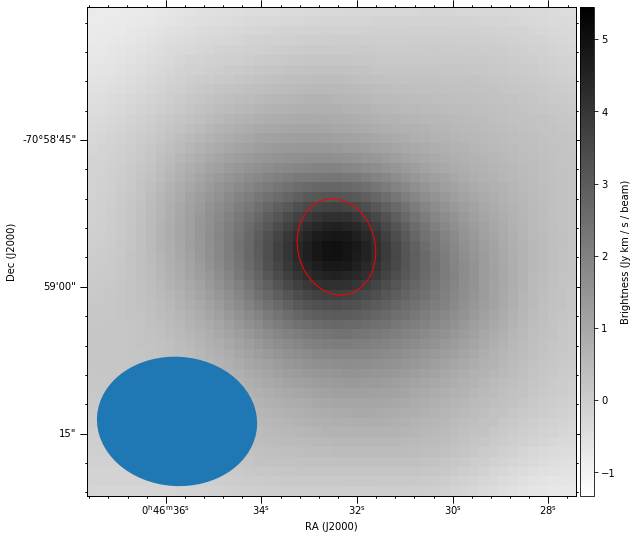

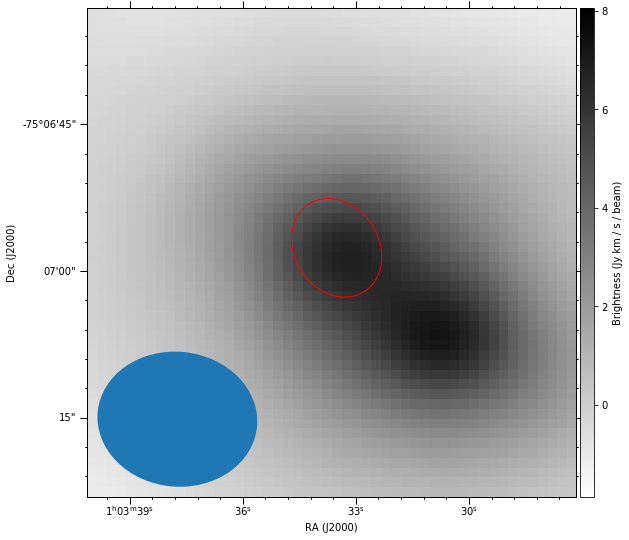

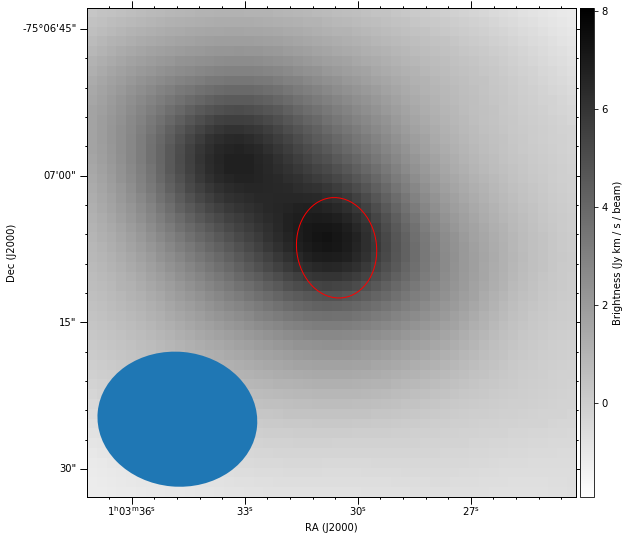

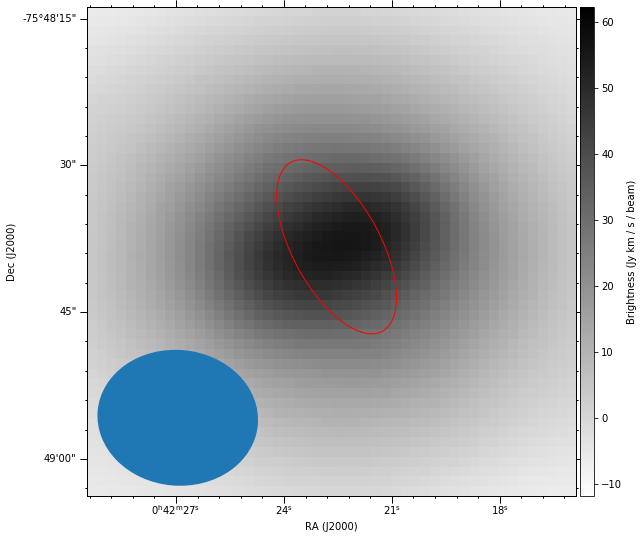

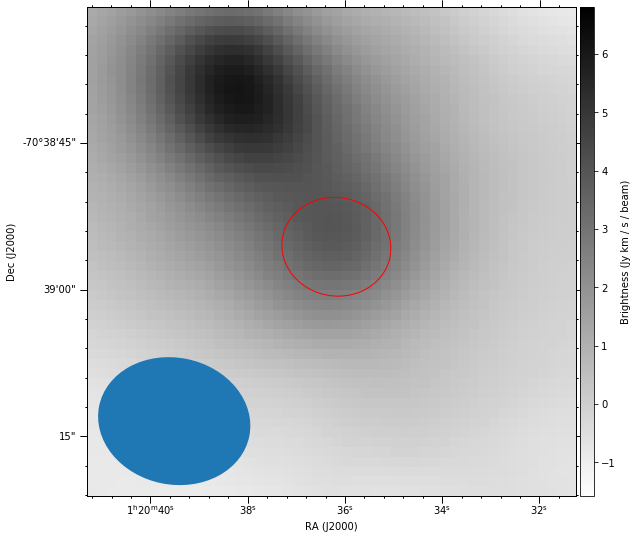

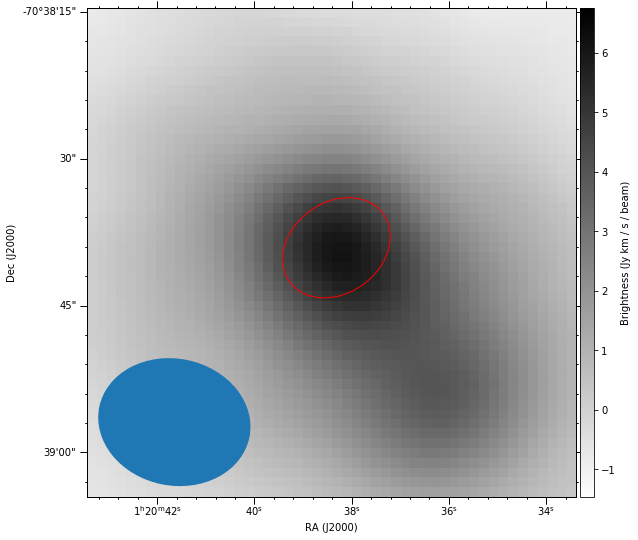

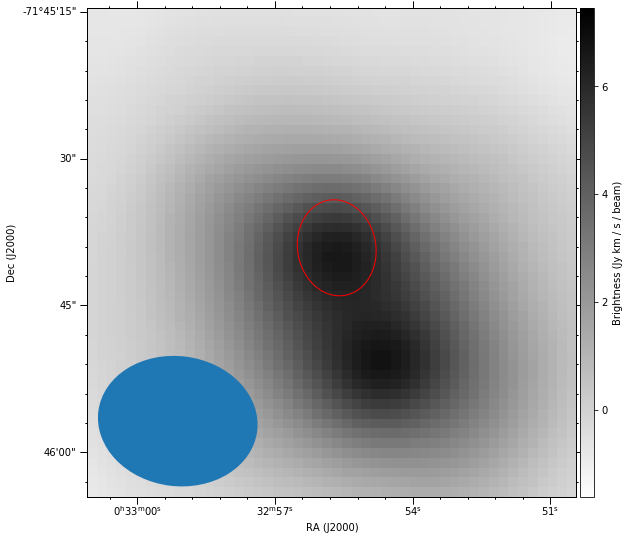

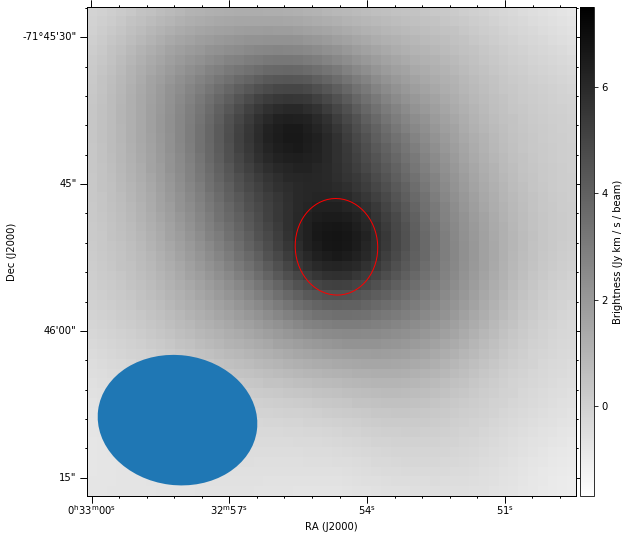

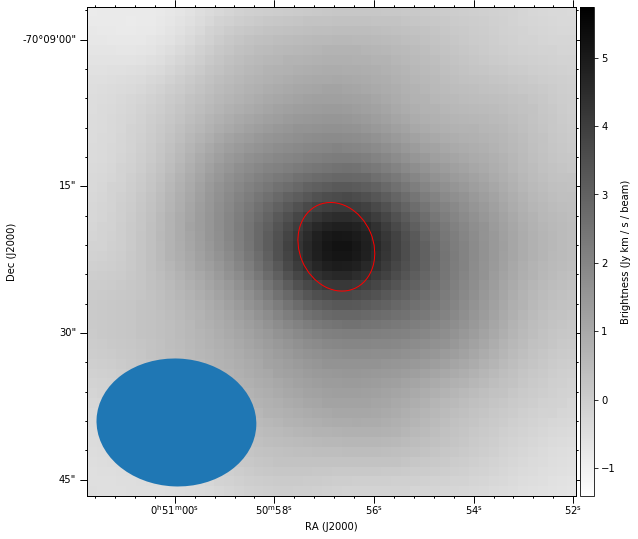

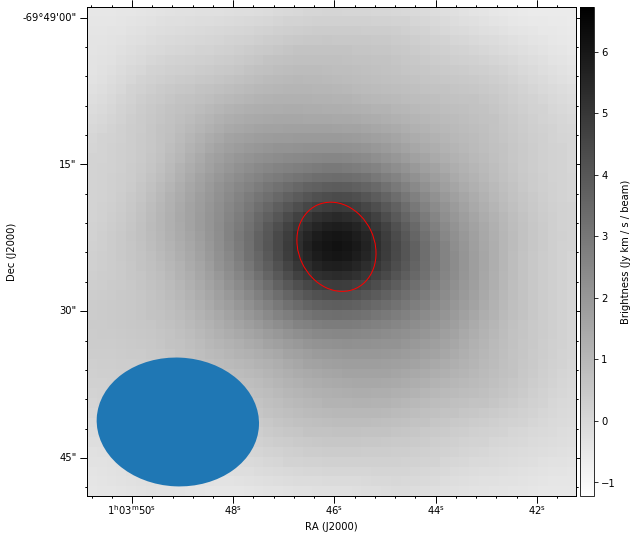

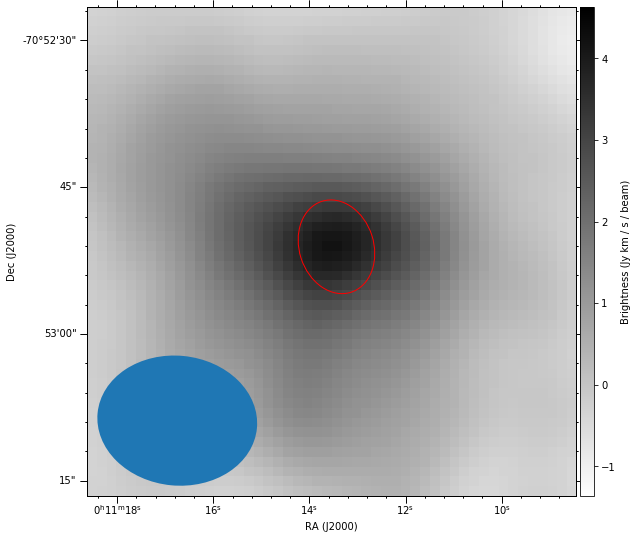

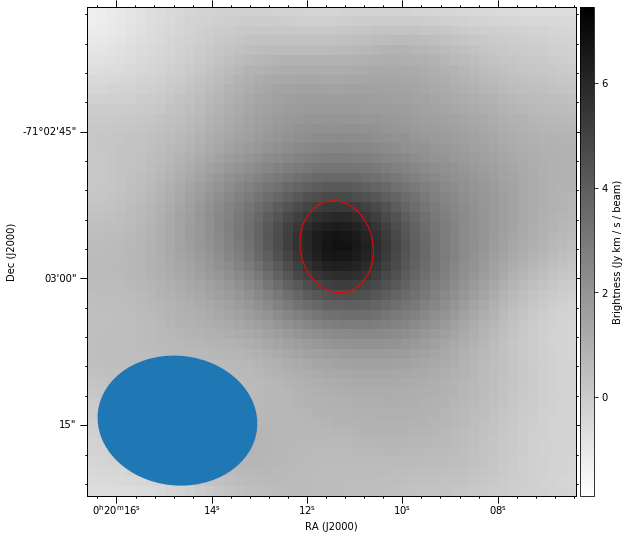

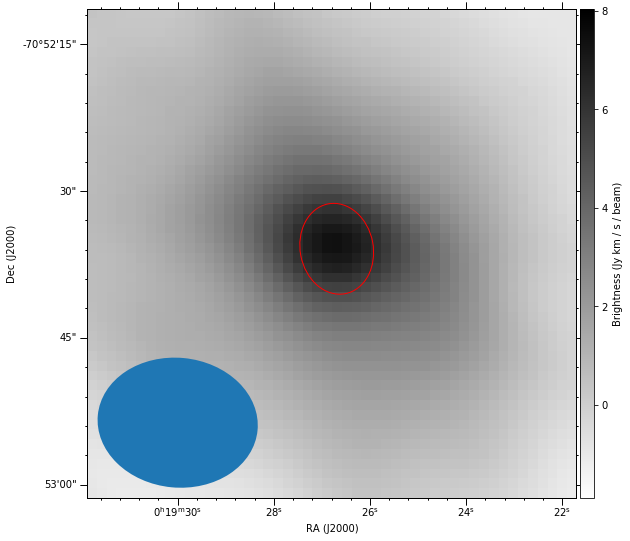

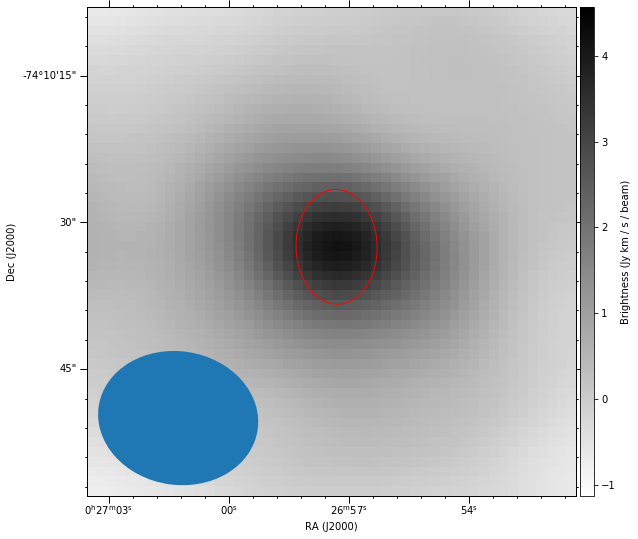

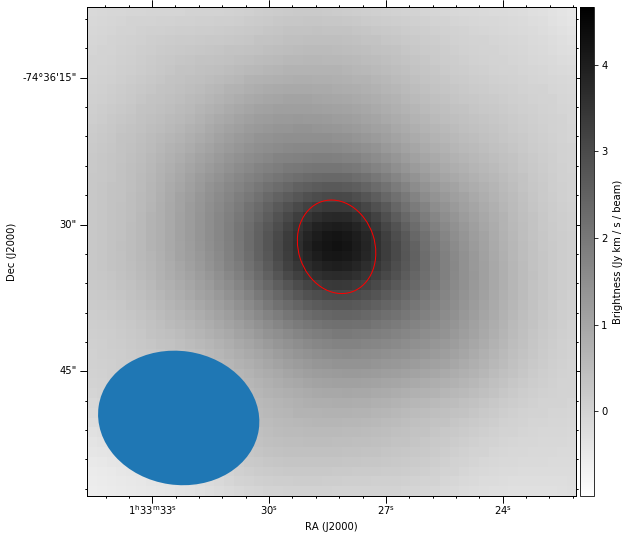

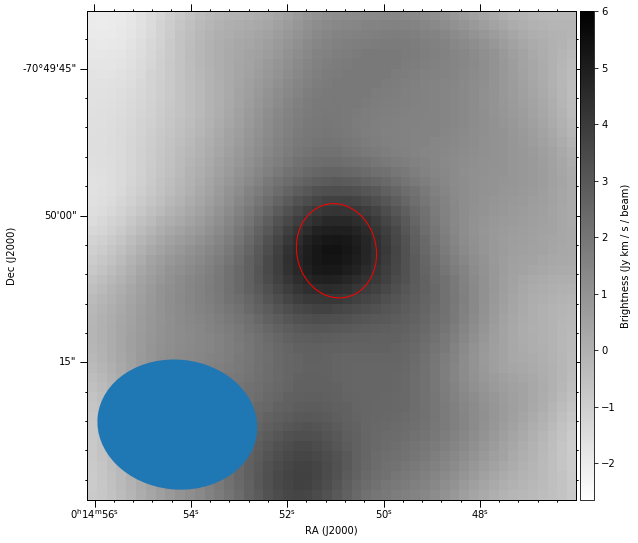

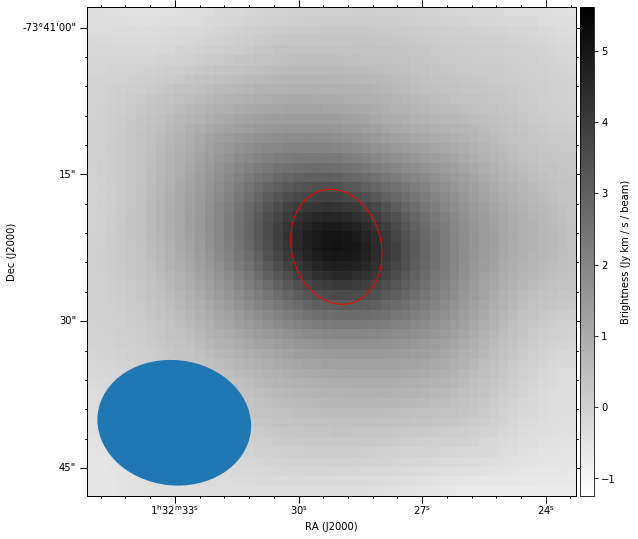

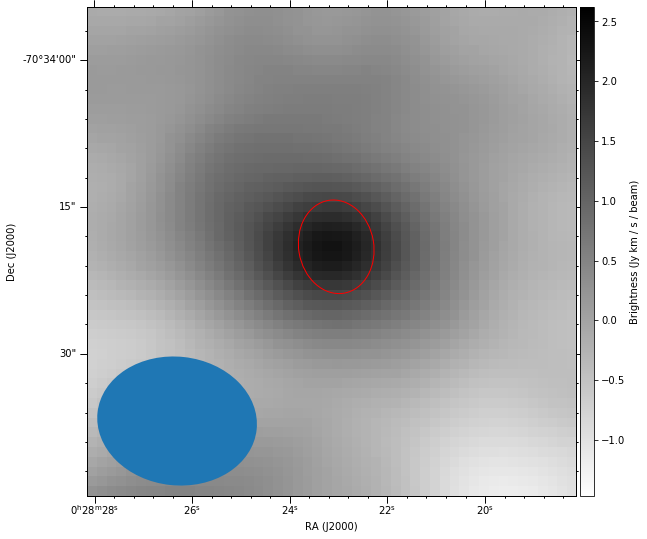

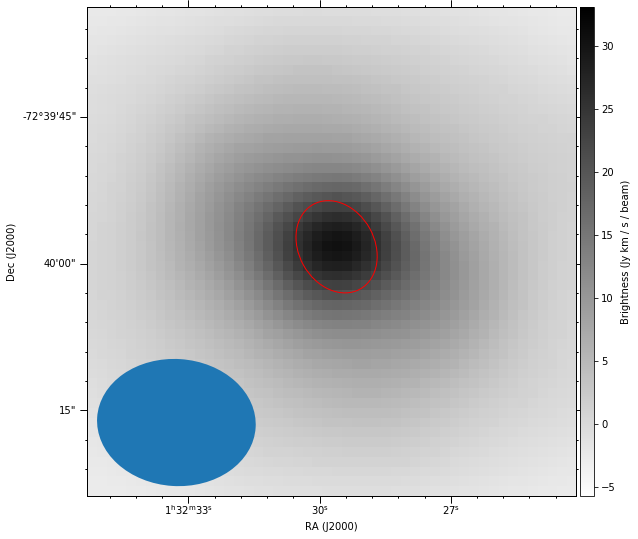

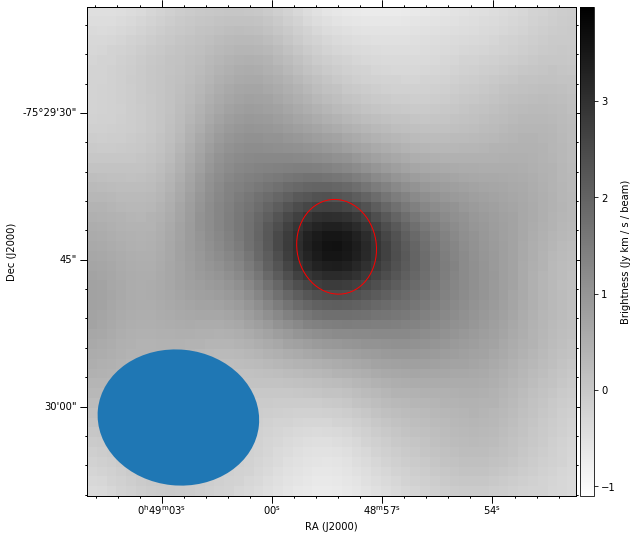

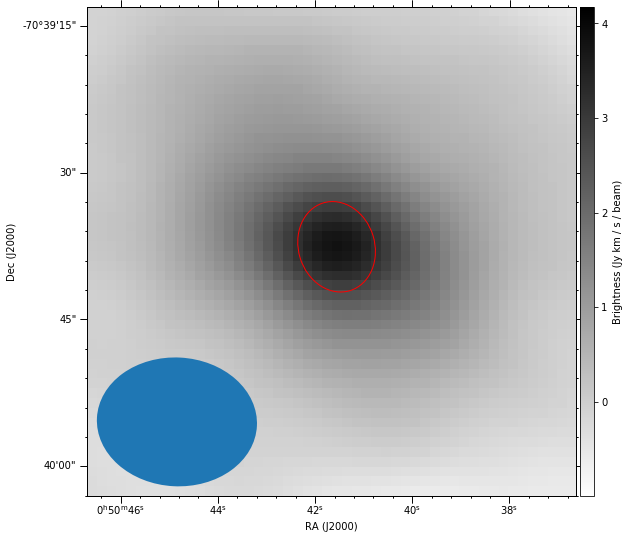

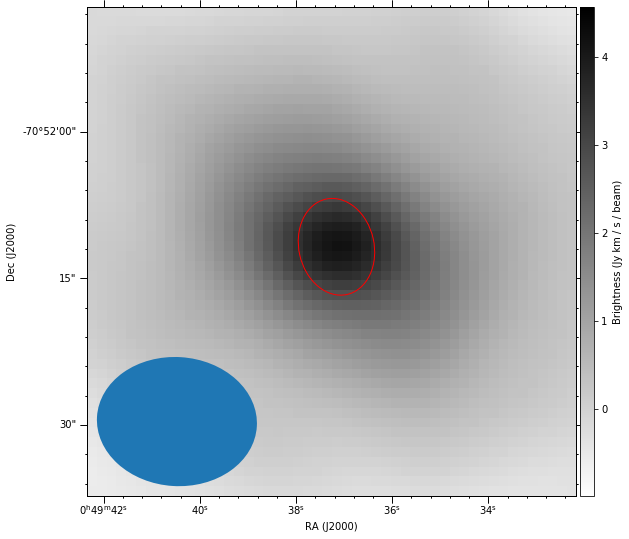

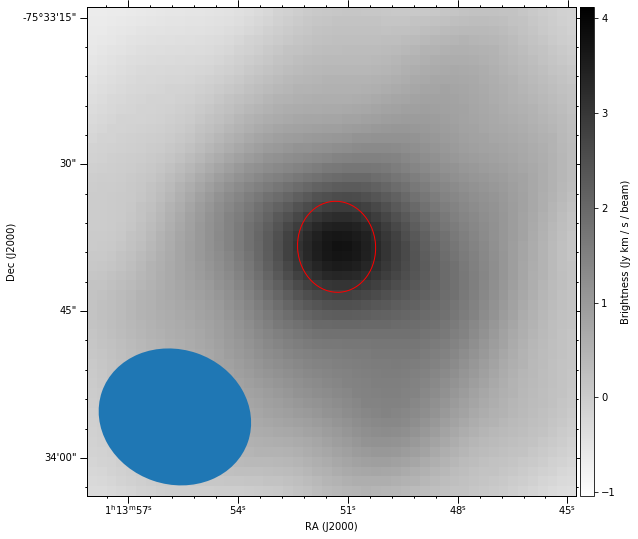

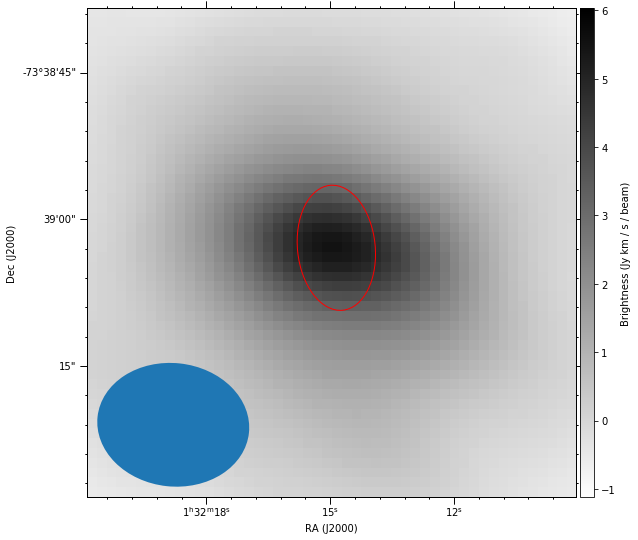

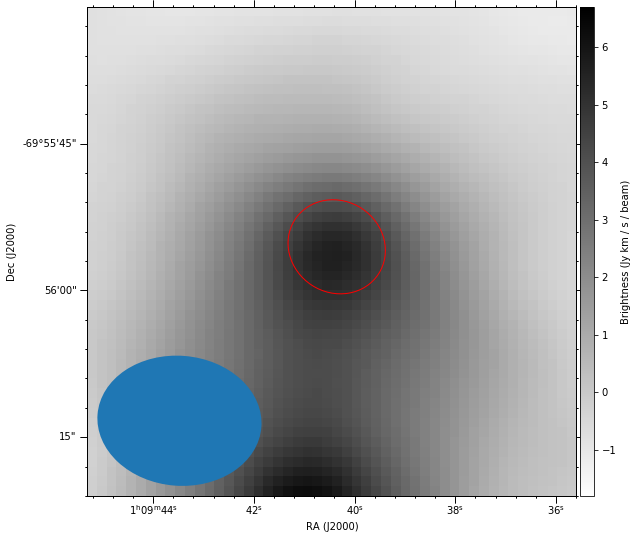

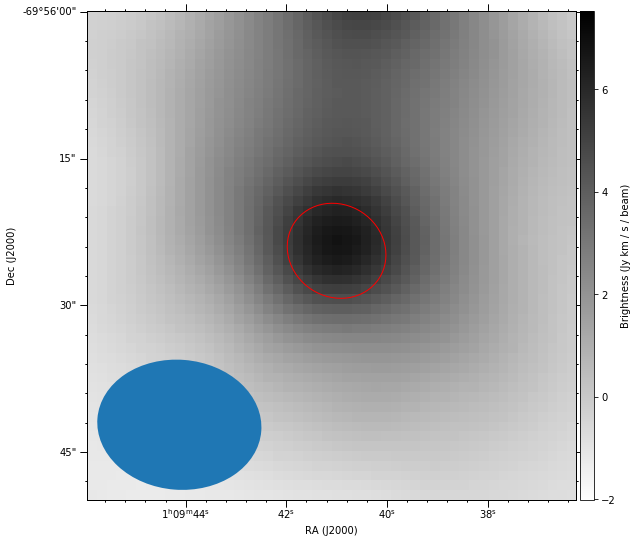

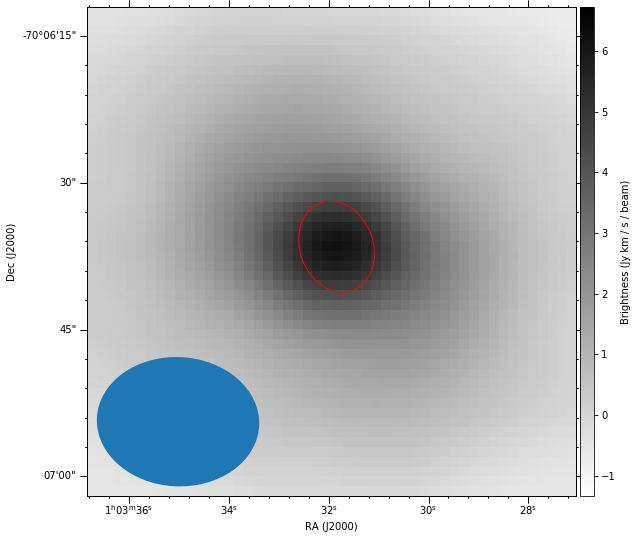

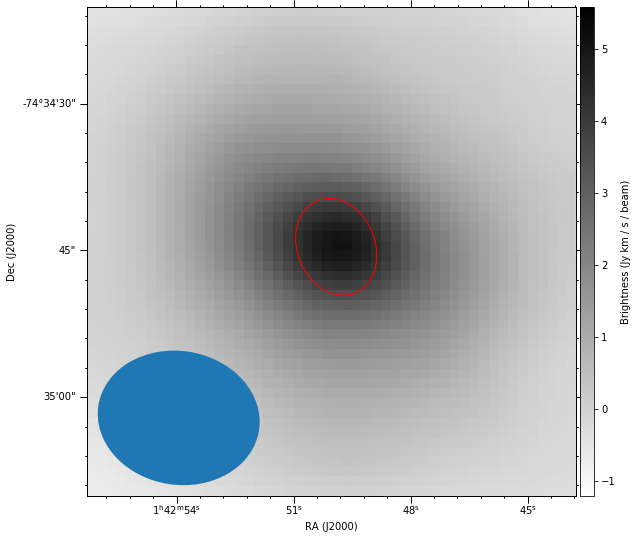

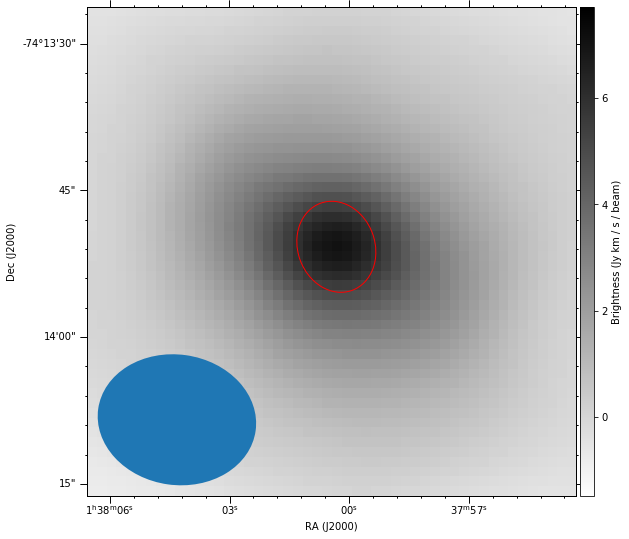

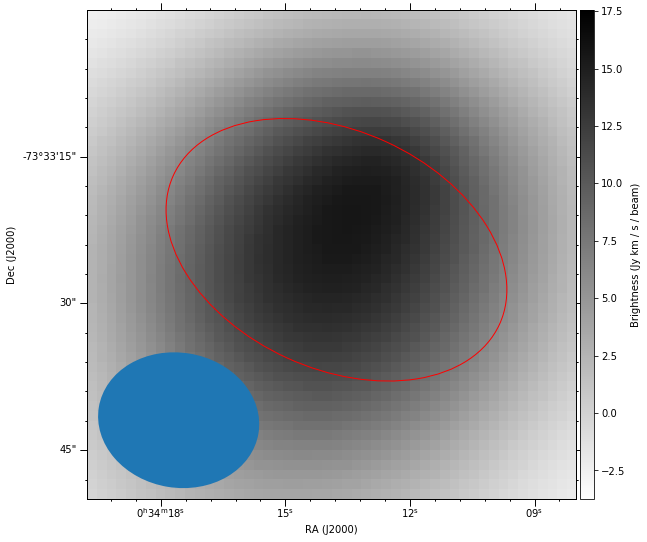

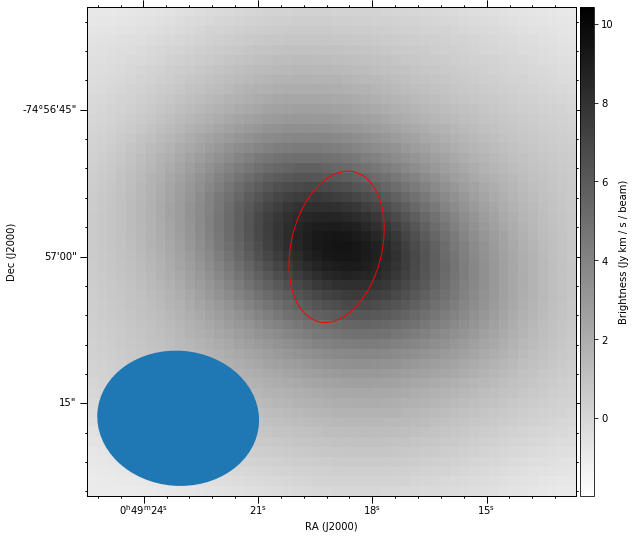

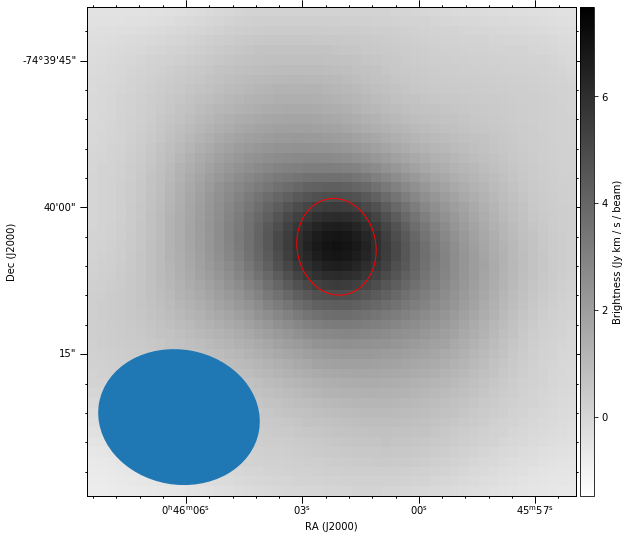

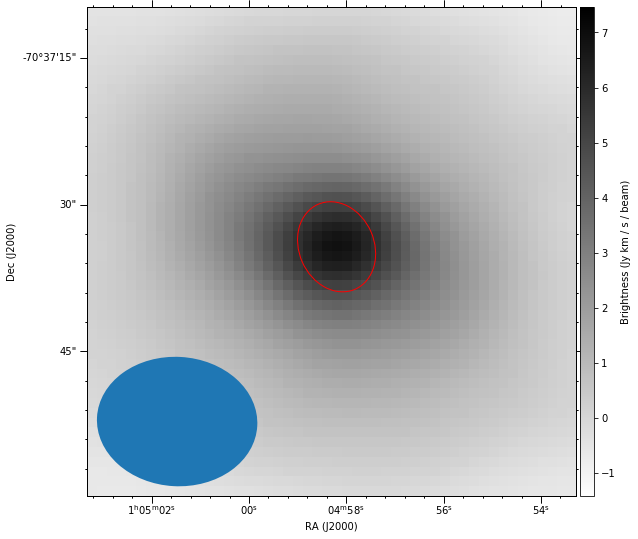

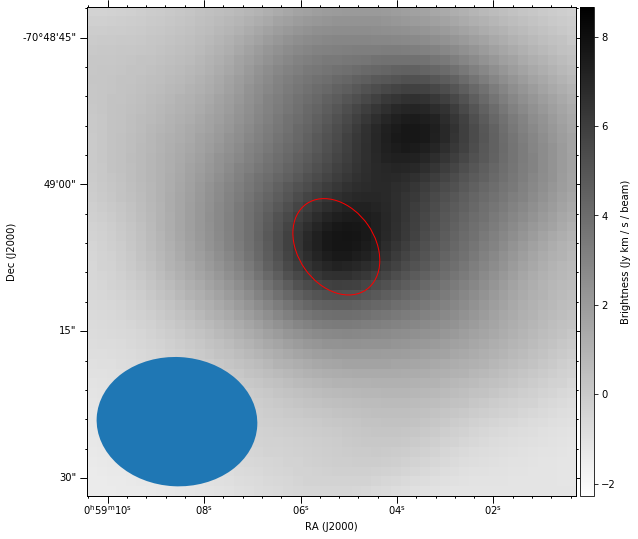

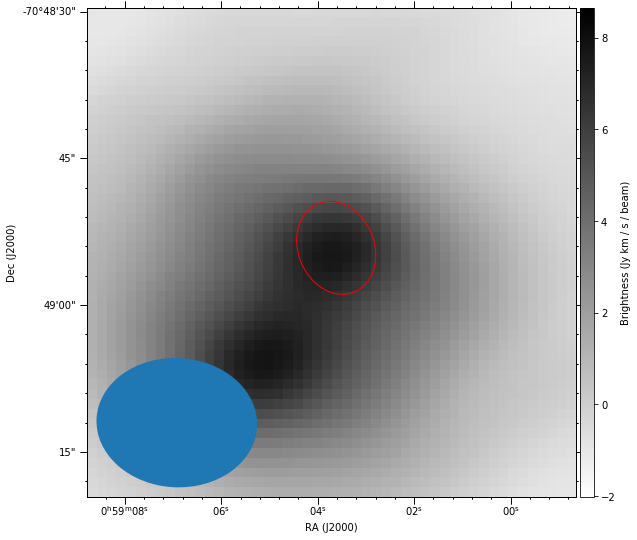

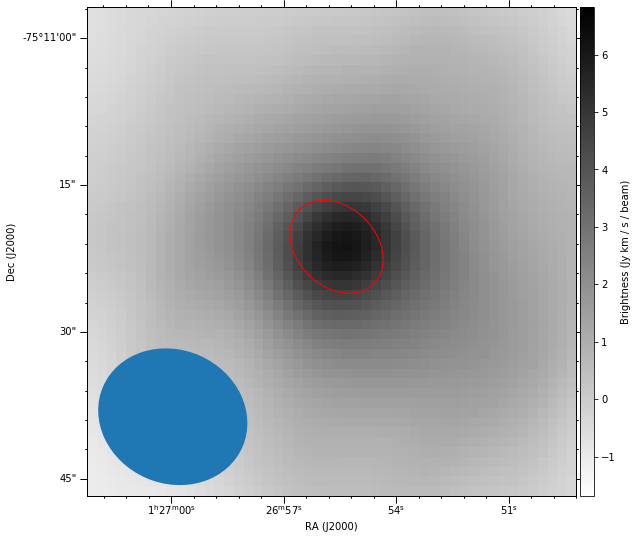

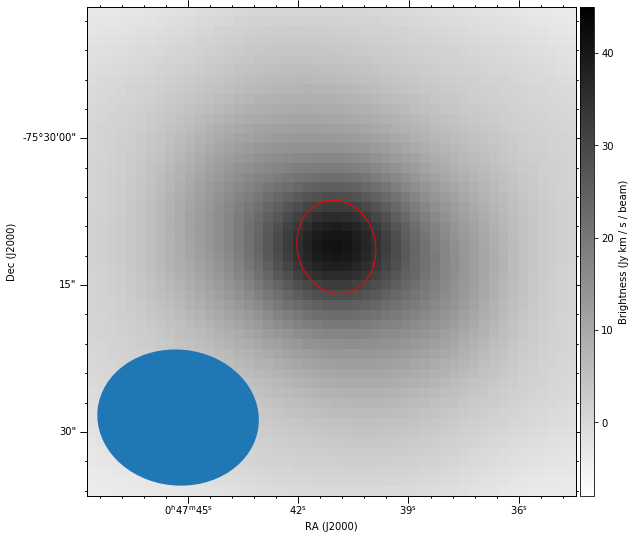

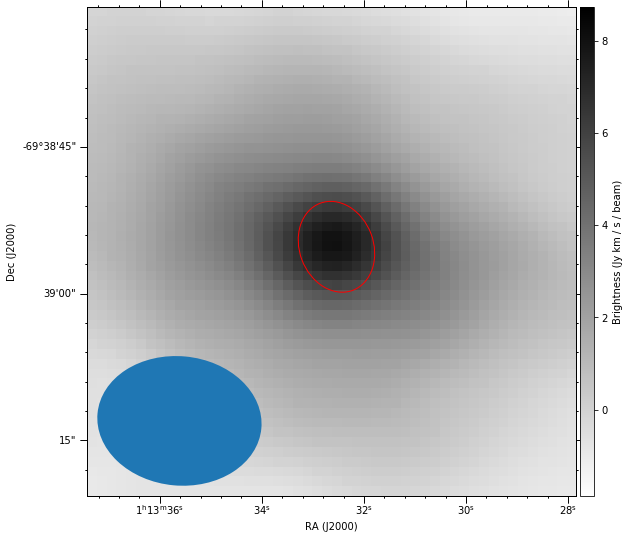

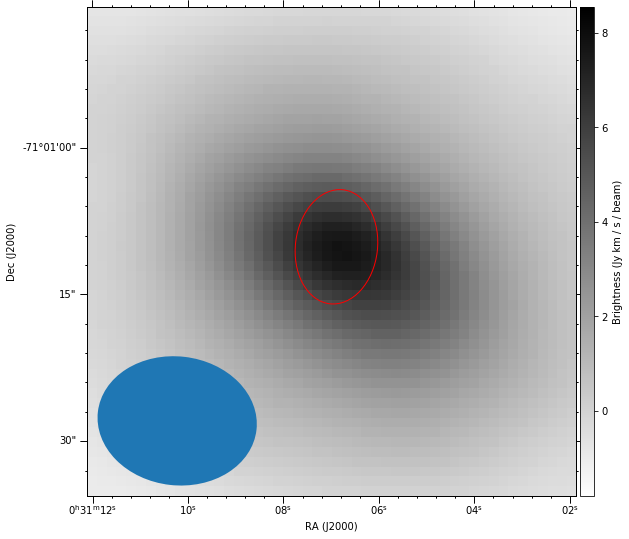

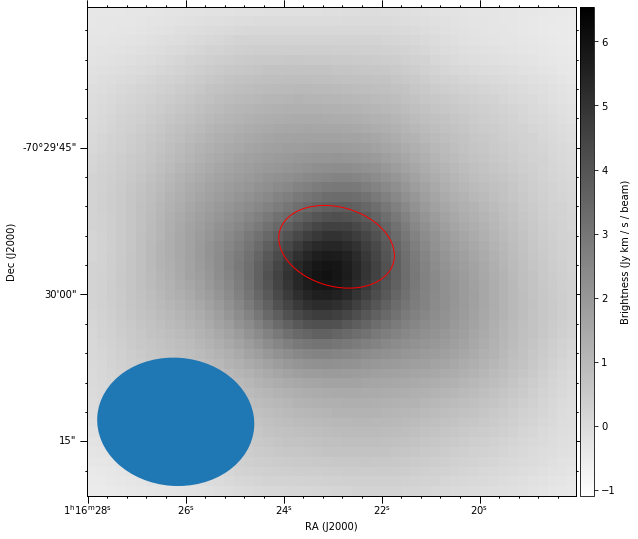

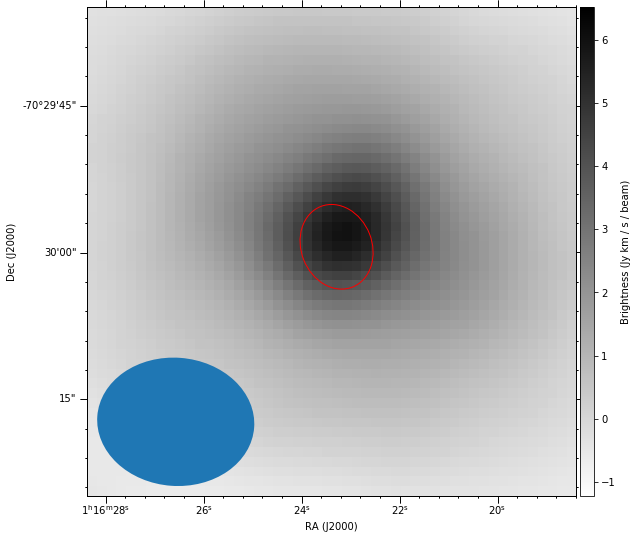

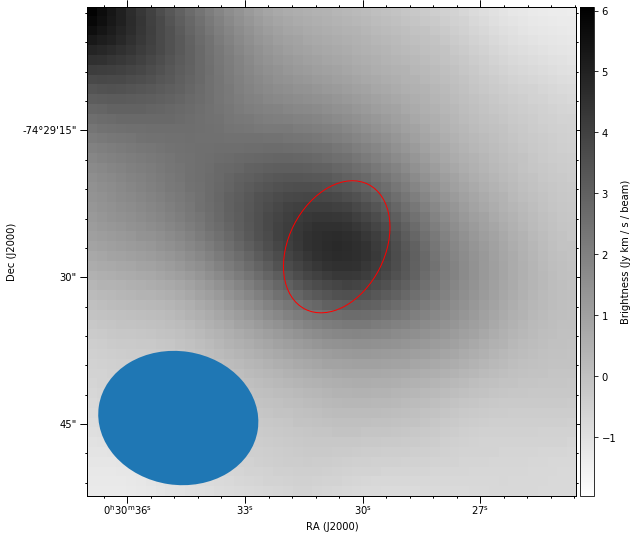

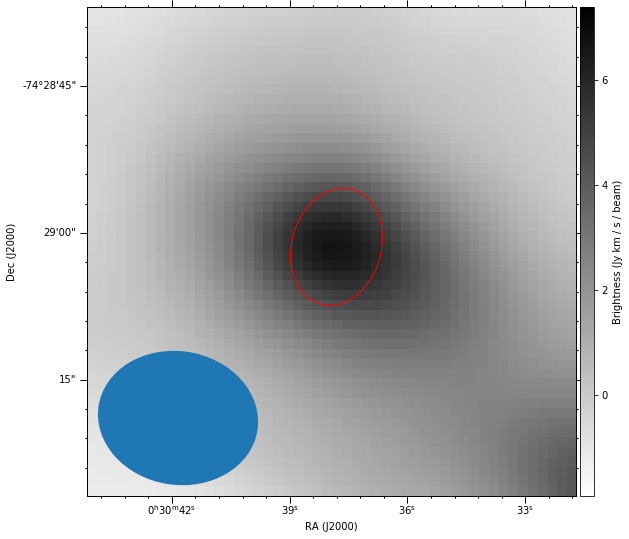

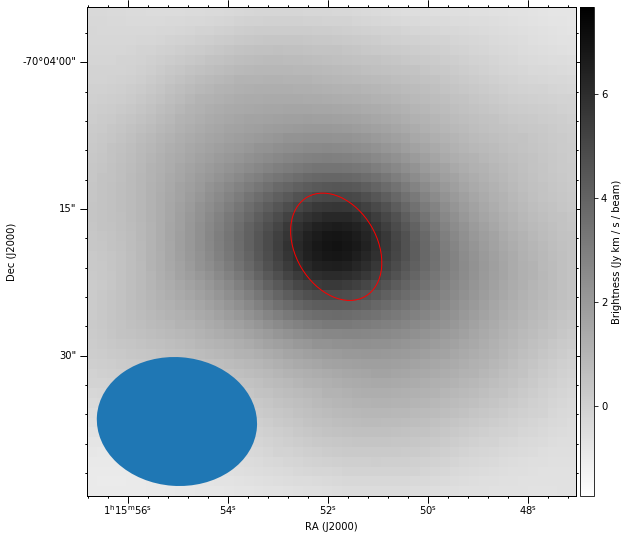

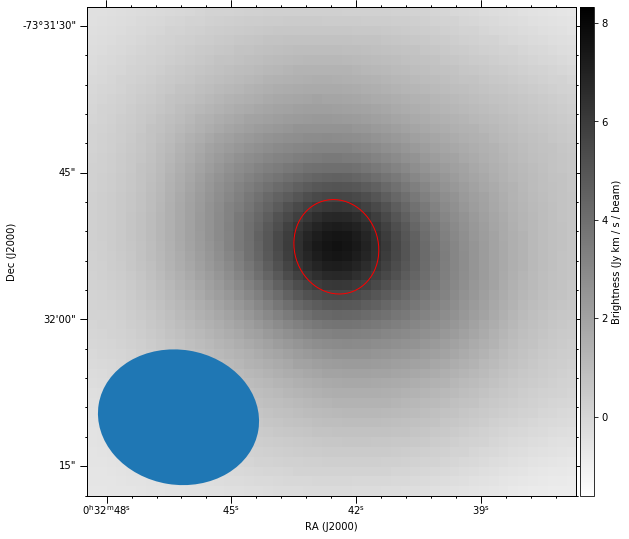

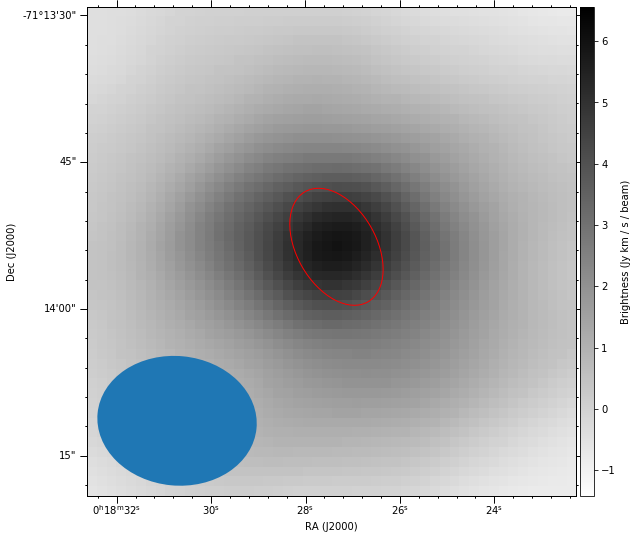

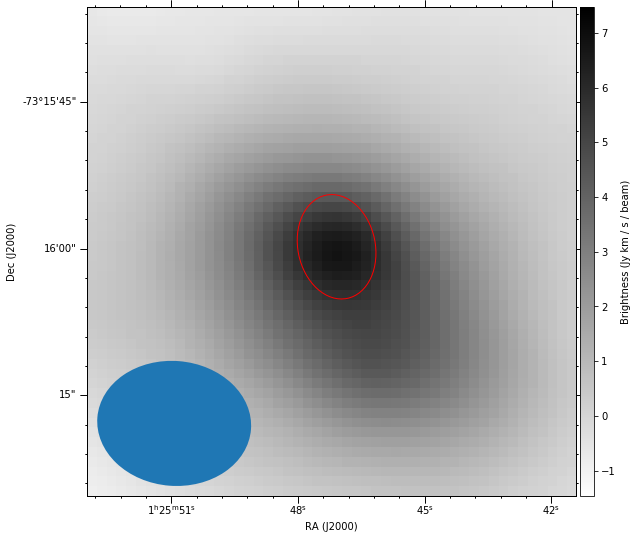

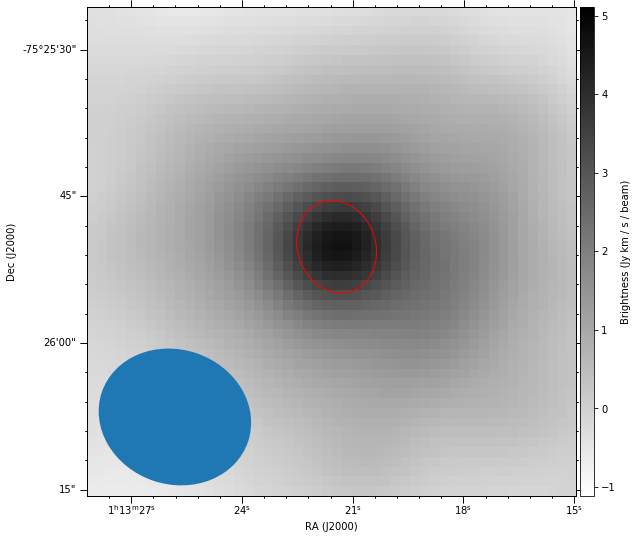

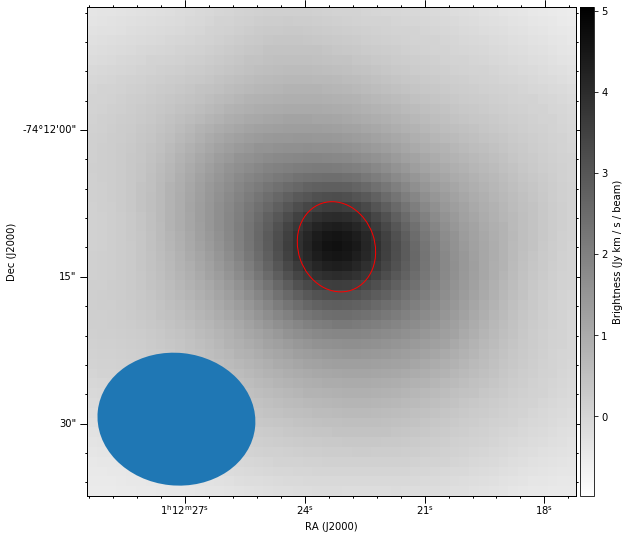

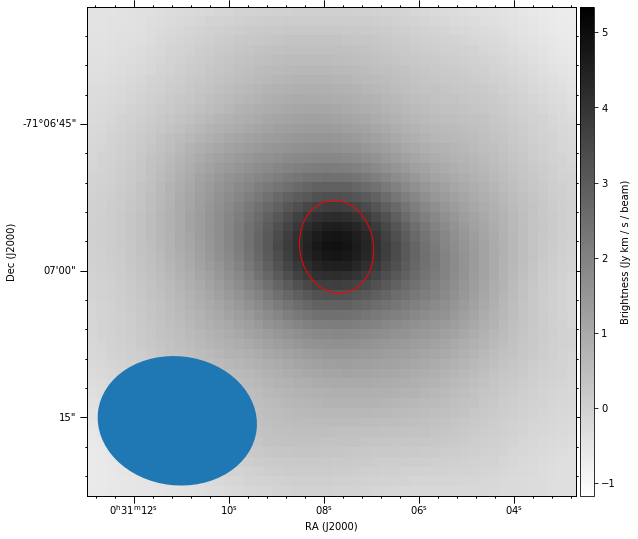

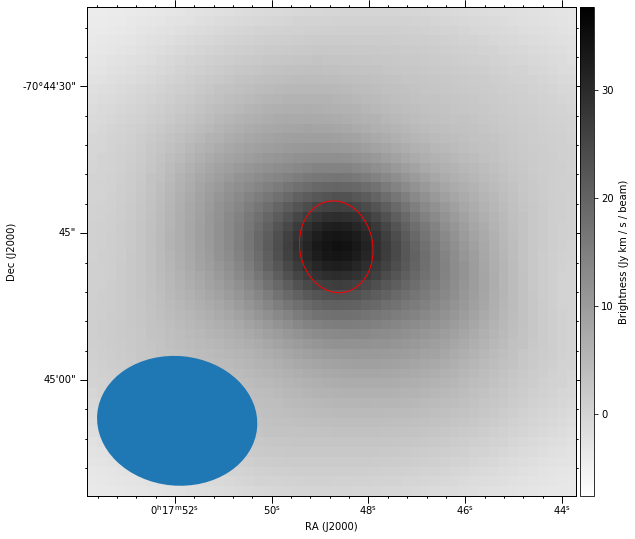

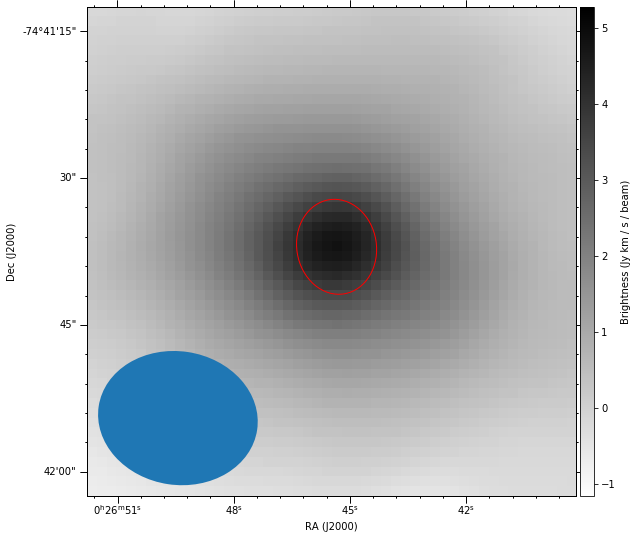

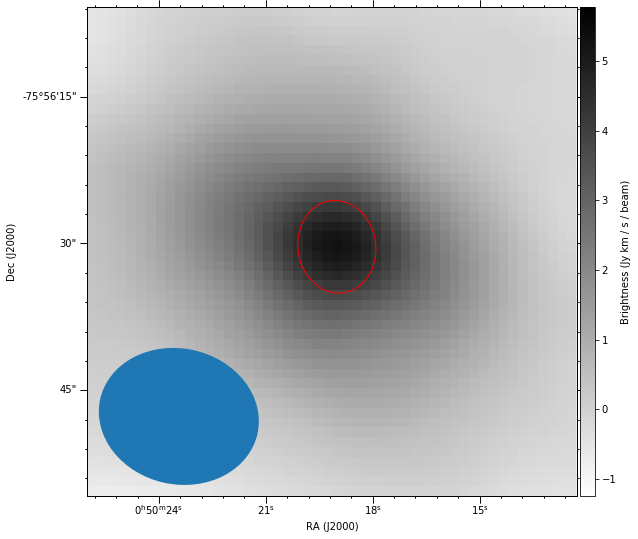

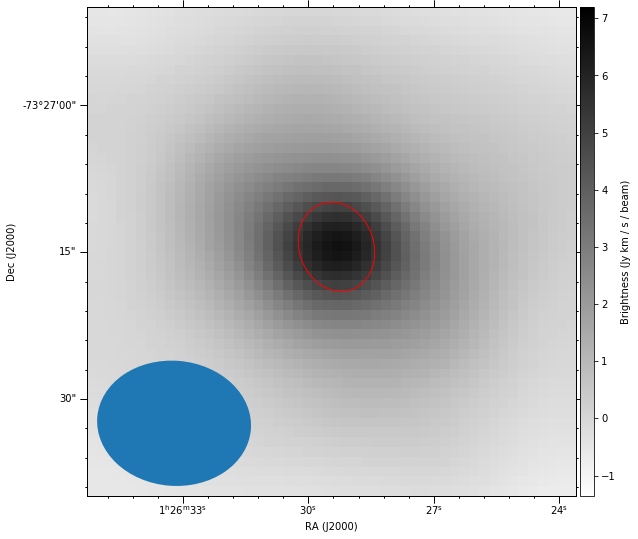

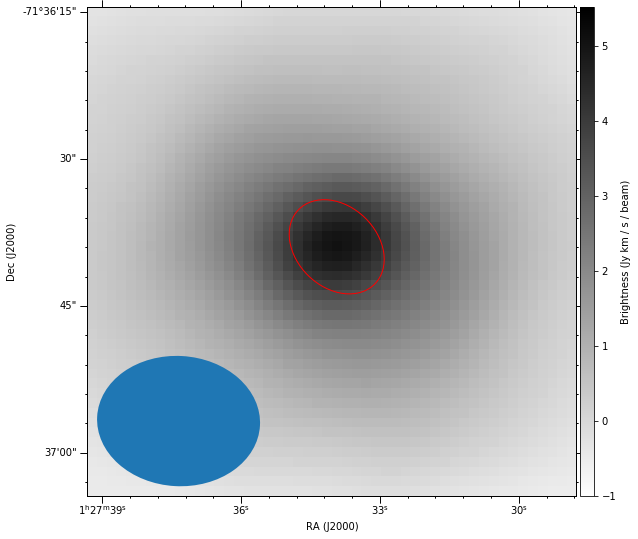

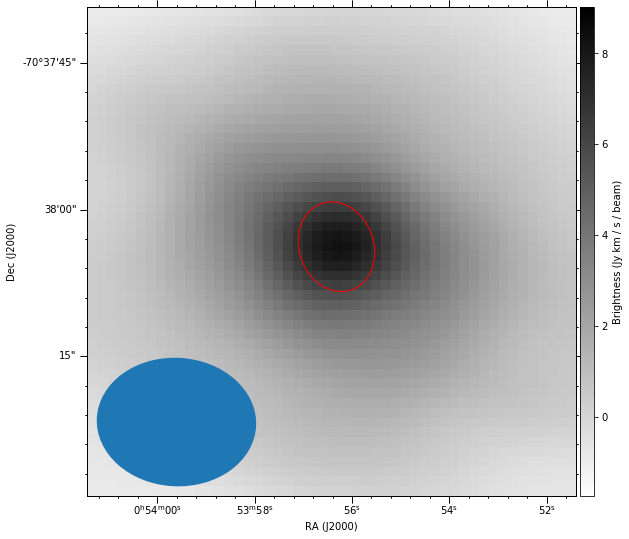

In [83]:

src_table = QTable(names=('id', 'comp_name', 'ra', 'dec', 'rating', 'flux_peak', 'mean_cont', 'sd_cont', 'opacity_range', 'max_s_max_n'),
           dtype=('int', 'U32', 'float64', 'float64', 'str', 'float64', 'float64', 'float64', 'float64', 'float64'),
            meta={'name': 'ASKAP SMC Spectra'})

print('Processing {} cutouts into spectra'.format(len(targets)))

max_spectra = 500
i = 0
for tgt in targets:
    src = get_source(file_list, tgt)
    if not src:
        print('Skipping missing src #{} {}'.format(tgt['id'], tgt['comp_name']))
        continue
    i+=1
    if i > max_spectra:
        print ("Reaching maximum spectra for this run")
        break
        
    print('\nExtracting spectrum for src #{} {}'.format(tgt['id'], tgt['comp_name']))

    plot_mom0(src['fname'], tgt['comp_name'], 'sb8906/figures', src['ra'], src['dec'], 
              src['a'], src['b'], src['pa'])
    
    continuum_start_vel = -100*u.km.to(u.m)
    continuum_end_vel = -60*u.km.to(u.m)
    spectrum = extract_spectrum(src['fname'], src, continuum_start_vel, continuum_end_vel)
    
    mean_cont, sd_cont = spectrum_tools.get_mean_continuum(spectrum.velocity, spectrum.flux, continuum_start_vel, continuum_end_vel)
    opacity = spectrum.flux/mean_cont
    sigma_opacity = sd_cont*np.ones(spectrum.velocity.shape)
    rating, opacity_range, max_s_max_n = spectrum_tools.rate_spectrum(opacity, sd_cont)

    output_spectrum('sb8906/spectra', src, spectrum, opacity, sigma_opacity)
    
    src_table.add_row([tgt['id'], tgt['comp_name'], src['ra']*u.deg, src['dec']*u.deg, 
                       rating, src['flux_peak']*u.Jy, mean_cont*u.Jy, sd_cont, opacity_range, max_s_max_n])
    
               
                                

In [84]:
srcvotable = from_table(src_table)
writeto(srcvotable, 'askap_spectra.vot')


## Scratch area

In [8]:
tgt = targets[0]
fname = '{}{}_sl.fits'.format(folder, tgt['comp_name'])

comp_cat_row= selavy_table[selavy_table['component_name']==tgt['comp_name']][0]
comp_cat_row
src_ra = comp_cat_row['ra_deg_cont']
src_dec = comp_cat_row['dec_deg_cont']
src_maj = comp_cat_row['maj_axis']
src_min = comp_cat_row['min_axis']
src_pa = comp_cat_row['pos_ang']
print ('Component at RA {:.4f} Dec {:.4f} is {:.2f}x{:.2f} arcsec at angle {:.1f} deg'.format(src_ra, src_dec, src_maj, src_min, src_pa))

Component at RA 4.8871 Dec -71.0062 is 9.45x7.43 arcsec at angle 99.0 deg


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


INFO: Auto-setting vmin to -1.255e+01 [aplpy.core]
INFO: Auto-setting vmax to  6.354e+01 [aplpy.core]
INFO: Auto-setting resolution to 7.35835 dpi [aplpy.core]


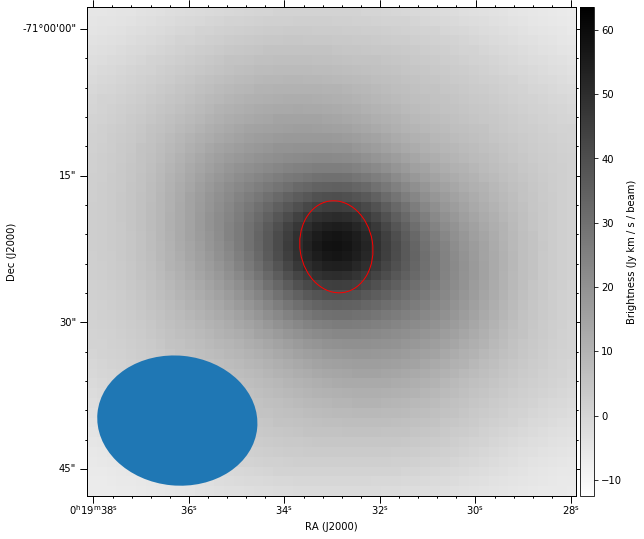

In [9]:
plot_mom0(fname, tgt['comp_name'], 'sb8906/figures', src_ra, src_dec, src_maj, src_min, src_pa)

In [13]:
src = {'ra':src_ra, 'dec':src_dec, 'a':src_maj, 'b':src_min, 'pa': src_pa}

hdulist = fits.open(fname)
image = hdulist[0].data
header = hdulist[0].header
w = WCS(header)
index = np.arange(header['NAXIS3'])
#beam_maj = header['BMAJ'] * 60 * 60
#beam_min = header['BMIN'] * 60 * 60
#beam_area = math.radians(header['BMAJ']) * math.radians(header['BMIN'])
velocities = w.wcs_pix2world(10,10,index[:],0,0)[2]
continuum_start_vel = -100*u.km.to(u.m)
continuum_end_vel = -60*u.km.to(u.m)
num_edge_chan = 10

#c = SkyCoord(src_ra, src_dec, frame='icrs', unit="deg")

img_slice = cube_tools.get_integrated_spectrum(image, w, src, velocities, continuum_start_vel, continuum_end_vel, radius=6)

l_edge, r_edge = cube_tools.find_edges(img_slice, num_edge_chan)
# print("Using data range %d - %d out of %d channels." % (
#    l_edge, r_edge, len(img_slice)))

# plotSpectrum(np.arange(slice.size), slice)
spectrum_array = rec.fromarrays(
    [np.arange(img_slice.size)[l_edge:r_edge],
     velocities[l_edge:r_edge],
     img_slice[l_edge:r_edge]],
    names='plane,velocity,flux')


In [28]:
spec_folder = 'sb8906/spectra'
filename = '{}/{}_spec'.format(spec_folder, tgt['comp_name'])
mean_cont, sd_cont = spectrum_tools.get_mean_continuum(spectrum_array.velocity, spectrum_array.flux, continuum_start_vel, continuum_end_vel)
opacity = spectrum_array.flux/mean_cont
sigma_tau = sd_cont*np.ones(spectrum_array.velocity.shape)

save_spectra(spectrum_array.velocity, opacity, spectrum_array.flux, filename+'.vot', sigma_tau)
#plt.plot(spectrum_array.flux)
spectrum_tools.plot_absorption_spectrum(spectrum_array.velocity, opacity, filename+'.png', tgt['comp_name'], continuum_start_vel, continuum_end_vel, sigma_tau, range=None)
spectrum_tools.plot_absorption_spectrum(spectrum_array.velocity, opacity, filename+'_zoom.png', tgt['comp_name'], continuum_start_vel, continuum_end_vel, sigma_tau, range=(75,275))
rating, opacity_range, max_s_max_n = spectrum_tools.rate_spectrum(opacity, sd_cont)
print ('Source {} rating: {} range:{:.2f}'.format(tgt['comp_name'], rating,opacity_range ) )

Using bins 0 to 39 (velocity range -100000 to -60000) out of 494


Source J001932-710022 rating: B range:0.17


In [40]:
src_table = QTable(names=('id', 'comp_name', 'ra', 'dec', 'rating', 'mean_cont', 'sd_cont'),
           dtype=('int', 'U32', 'float64', 'float64', 'str', 'float64', 'float64'),
            meta={'name': 'ASKAP SMC Spectra'})
#t['comp_name'].length = 32
src_table.add_row([tgt['id'], tgt['comp_name'], src_ra*u.deg, src_dec*u.deg, rating, mean_cont*u.Jy, sd_cont])

In [ ]:
good_beams = cube.identify_bad_beams(threshold=0.01)
good_beams

In [ ]:
#cube = SpectralCube.read(fname)
#print(cube)
#print (cube.beams)
m0 = cube.moment0().to(u.Jy*u.km/(u.beam*u.s))
print(m0)
m0.write('moment-0.fits', overwrite=True)
img_size = m0.shape

fig = aplpy.FITSFigure('moment-0.fits')
center_coord = fig.pixel2world(xp=img_size[0]/2, yp=img_size[1]/2)
#fig.recenter(center_coord[0], center_coord[1], radius=2*u.arcmin.to(u.deg))  # degrees
#fig.show_grayscale(stretch='log', vmin=0, vmid=-0.1)
fig.show_grayscale()#pmax=100)
fig.add_colorbar()
fig.colorbar.set_axis_label_text('Brightness (Jy km / s)')
fig.add_beam()
fig.set_theme('publication')

# Plot ellipse for each source
a_deg = src_maj*u.arcsec.to(u.deg)
b_deg = src_min*u.arcsec.to(u.deg)
fig.show_ellipses(src_ra, src_dec, a_deg, b_deg, angle=src_pa, edgecolor='red') #, 

figname = 'sb8906/figures/{}_mom0.'.format(tgt['comp_name'])
fig.savefig(figname+'.pdf')
fig.savefig(figname+'.png')


In [ ]:
# run agean to identify sources (or use preexisting)
# identify continuum velocity ranges
start_vel=(-90*u.km).to(u.m).value
end_vel=(-30*u.km).to(u.m).value

# Note that we need to make sure the beam info is set:
# sethead BMAJ='0.0047402' BMIN='0.0040442' BPA='83.183' sb8906/casda/sb8906_0029-7228_sl_*K.fits

# loop through and extract spectra for each

In [ ]:
sd_list = {}
max_list = {}
for name in file_list:
    spec, source_ids, islands = cube_tools.extract_spectra(fits_filename=name, 
                      isle_filename='0029-7228_src_isle.vot', src_filename='0029-7228_src_comp.vot',
                      continuum_start_vel=start_vel, continuum_end_vel=end_vel)
    spectrum = list(spec.values())[0]
    spec_mean, spec_sd = spectrum_tools.get_mean_continuum(spectrum.velocity, spectrum.flux, start_vel, end_vel)
    sigma_tau = np.full(spectrum.velocity.shape, spec_sd)
    print (spec_mean, np.max(spectrum.flux))
    spectrum_tools.plot_absorption_spectrum(spectrum.velocity, spectrum.flux/spec_mean, name[:-5]+'_spec.png',
                                           name, start_vel, end_vel, sigma_tau, range=(-100,250))
    
    output_spectra(spectrum.velocity, spectrum.flux/spec_mean, spectrum.flux, name[:-5]+'_spec.xml', sigma_tau)
    #plt.plot(spectrum.velocity/1000, spectrum['flux'])
    #plt.title(name)
    #plt.savefig(name[:-5]+'_spec.png')
    #plt.close()
    sd_list[name] = spec_sd
    max_list[name] = np.max(spectrum.flux/spec_mean)

In [ ]:
print (sd_list)